# Imports and Data Loading

**Experiment**: <br>
1. Inputs : Min, max, Qty, modal at time t-0
2. Output : modal_price from t+1 to t+5
3. Models : 
  1. LSTM.
  2. Bi-Dir LSTM.
  3. Stacked LSTM.
  4. Stacked Bi-Dir LSTM.
  5. Stacked LSTM and Bi-Dir LSTM combination. 
  6. Stacked Bi-Dir LSTM (Hyperparameter tuning)
  7. Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of hidden layers.
  8. Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of nodes in hidden layers.
  9. Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of nodes in hidden layers.
  10. Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of nodes in hidden layers.
  11. Stacked Bi Directional LSTM - Parallel model

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [2]:
from keras.layers import Attention, BatchNormalization

In [3]:
from keras.layers import Dense, Activation, Input, Dropout
#from keras.layers import concatenate, 

In [4]:
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, adadelta

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [6]:
from google. colab import drive
drive.mount ('/content/drive/')

Mounted at /content/drive/


In [7]:
df_tomato = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Tomato_Kolar_2020_23.xlsx')
df_tomato.shape

(1163, 10)

In [8]:
df_tomato.head(5)

state district market commodity variety arrival_date  min_price  \
0  Karnataka    Kolar  Kolar    Tomato  Tomato   2023-01-01        400   
1  Karnataka    Kolar  Kolar    Tomato  Tomato   2023-01-02        400   
2  Karnataka    Kolar  Kolar    Tomato  Tomato   2023-01-03        400   
3  Karnataka    Kolar  Kolar    Tomato  Tomato   2023-01-04        330   
4  Karnataka    Kolar  Kolar    Tomato  Tomato   2023-01-05        330   

   max_price  modal_price  quantity  
0       1330          730      6224  
1       1670          930      4439  
2       1670          930      5983  
3       1330          800      7830  
4       1200          530      6310

# EDA

In [9]:
df_tomato_2 = df_tomato.set_index('arrival_date',drop=True, verify_integrity=True)

In [10]:
df_tomato_2.sort_index(axis=1)

commodity district market  max_price  min_price  modal_price  \
arrival_date                                                                
2023-01-01      Tomato    Kolar  Kolar       1330        400          730   
2023-01-02      Tomato    Kolar  Kolar       1670        400          930   
2023-01-03      Tomato    Kolar  Kolar       1670        400          930   
2023-01-04      Tomato    Kolar  Kolar       1330        330          800   
2023-01-05      Tomato    Kolar  Kolar       1200        330          530   
...                ...      ...    ...        ...        ...          ...   
2020-12-26      Tomato    Kolar  Kolar       1667        333          933   
2020-12-27      Tomato    Kolar  Kolar       2000        667         1200   
2020-12-28      Tomato    Kolar  Kolar       1733        400         1000   
2020-12-29      Tomato    Kolar  Kolar       1600        333          867   
2020-12-30      Tomato    Kolar  Kolar       1667        400          933   

              quantity      state variety  
arrival_date                               
2023-01-01        6224  Karnataka  Tomato  
2023-01-02        4439  Karnataka  Tomato  
2023-01-03        5983  Karnataka  Tomato  
2023-01-04        7830  Karnataka  Tomato  
2023-01-05        6310  Karnataka  Tomato  
...                ...        ...     ...  
2020-12-26       12250  Karnataka  Tomato  
2020-12-27        8530  Karnataka  Tomato  
2020-12-28       10794  Karnataka  Tomato  
2020-12-29       11924  Karnataka  Tomato  
2020-12-30        9679  Karnataka  Tomato  

[1163 rows x 9 columns]

In [11]:
df_tomato_2 = df_tomato_2.drop(['state','district', 'market', 'commodity', 'variety'], axis=1)
df_tomato_2.head()

min_price  max_price  modal_price  quantity
arrival_date                                             
2023-01-01          400       1330          730      6224
2023-01-02          400       1670          930      4439
2023-01-03          400       1670          930      5983
2023-01-04          330       1330          800      7830
2023-01-05          330       1200          530      6310

In [12]:
df_tomato_2.isnull().sum()

min_price      0
max_price      0
modal_price    0
quantity       0
dtype: int64

In [13]:
cor_matrix = df_tomato_2.corr()

Text(0.5, 1.0, 'Heat map of correlation between features')

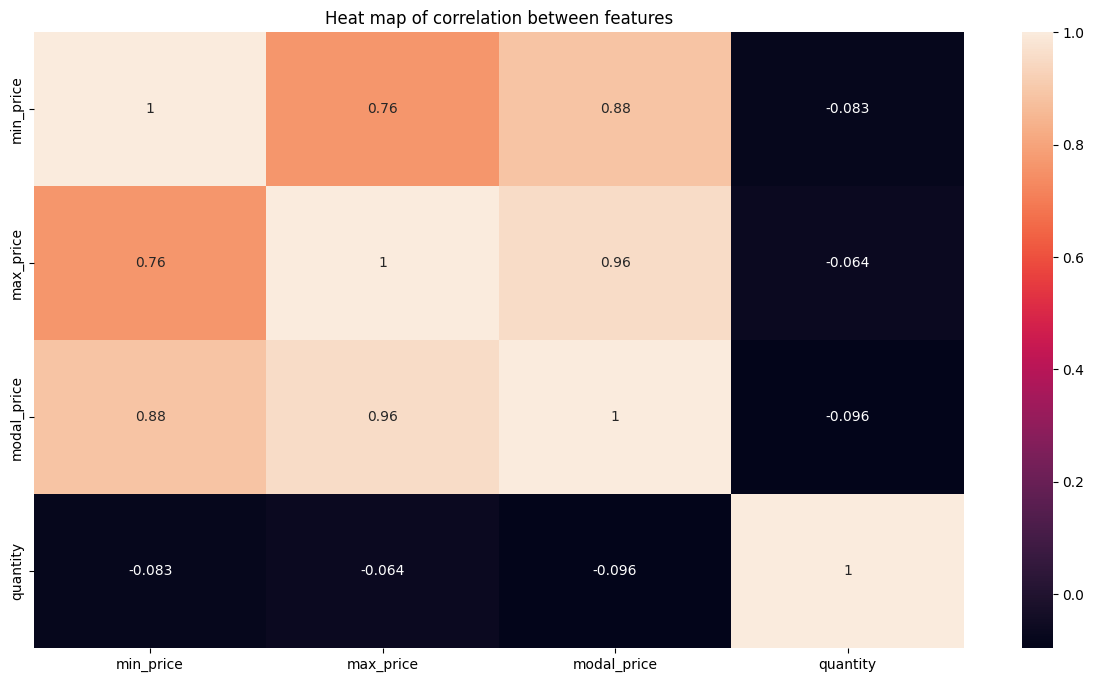

In [14]:
sns.heatmap(cor_matrix,annot=True)
plt.title("Heat map of correlation between features")

In [15]:
# Drop min_price and max_price because of hig auto-correlation 
# df_tomato_3 = df_tomato_2.drop(['min_price','max_price'], axis=1)
# df_tomato_3.head()

In [16]:
df_tomato_2.head()

min_price  max_price  modal_price  quantity
arrival_date                                             
2023-01-01          400       1330          730      6224
2023-01-02          400       1670          930      4439
2023-01-03          400       1670          930      5983
2023-01-04          330       1330          800      7830
2023-01-05          330       1200          530      6310

In [17]:
# Creating a new dataset and Sorting in ascending order of time series
df_tomato_3 = df_tomato_2[['quantity','min_price','max_price','modal_price']]
df_tomato_3.sort_index(ascending=True,inplace=True)
df_tomato_3.head()

quantity  min_price  max_price  modal_price
arrival_date                                             
2020-01-01        4144        333       1467          733
2020-01-02        4430        333       1733          986
2020-01-03        4532        400       2000         1047
2020-01-04        5578        333       2000         1033
2020-01-05        4960        333       2000         1033

# Preparing the dataset for training

### Creating Feature variable

In [18]:
# Function to create as many as features to represent the window size
#def createWindow(winSize):
#  df_temp = pd.DataFrame()
#  for i in range(0,winSize):
#    df_temp["feature_t"+str(i+1)] = df_tomato_3['modal_price'].shift(-i)
#  return df_temp

In [19]:
# Generating new features
#df_newCols = createWindow(35)
#df_newCols.head()

In [20]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

In [21]:
# Replacing null values with 0, thus created window of 30 days as each input.
#for val in df_tomato_4.columns:
#  df_tomato_4[val].fillna(0, inplace=True)
#df_tomato_4.head()

In [22]:
# joining with base dataframe
#df_tomato_4 = df_tomato_3.join(df_newCols)
#df_tomato_4.head()

### Creating Target Variable

In [23]:
def createWindow(winSize):
  df_temp = pd.DataFrame()
  for i in range(1,winSize+1):
    df_temp["target_t"+str(i)] = df_tomato_3['modal_price'].shift(-i)
  return df_temp

In [24]:
# Generating new features
df_newCols = createWindow(5)
df_newCols.head()

target_t1  target_t2  target_t3  target_t4  target_t5
arrival_date                                                       
2020-01-01        986.0     1047.0     1033.0     1033.0     1046.0
2020-01-02       1047.0     1033.0     1033.0     1046.0     1153.0
2020-01-03       1033.0     1033.0     1046.0     1153.0      933.0
2020-01-04       1033.0     1046.0     1153.0      933.0     1133.0
2020-01-05       1046.0     1153.0      933.0     1133.0      933.0

In [25]:
# joining with base dataframe
df_tomato_4 = df_tomato_3.join(df_newCols)
df_tomato_4.head()

quantity  min_price  max_price  modal_price  target_t1  \
arrival_date                                                           
2020-01-01        4144        333       1467          733      986.0   
2020-01-02        4430        333       1733          986     1047.0   
2020-01-03        4532        400       2000         1047     1033.0   
2020-01-04        5578        333       2000         1033     1033.0   
2020-01-05        4960        333       2000         1033     1046.0   

              target_t2  target_t3  target_t4  target_t5  
arrival_date                                              
2020-01-01       1047.0     1033.0     1033.0     1046.0  
2020-01-02       1033.0     1033.0     1046.0     1153.0  
2020-01-03       1033.0     1046.0     1153.0      933.0  
2020-01-04       1046.0     1153.0      933.0     1133.0  
2020-01-05       1153.0      933.0     1133.0      933.0

In [26]:
# Drop all the null values
df_tomato_4.dropna(inplace=True)
df_tomato_4

quantity  min_price  max_price  modal_price  target_t1  \
arrival_date                                                           
2020-01-01        4144        333       1467          733      986.0   
2020-01-02        4430        333       1733          986     1047.0   
2020-01-03        4532        400       2000         1047     1033.0   
2020-01-04        5578        333       2000         1033     1033.0   
2020-01-05        4960        333       2000         1033     1046.0   
...                ...        ...        ...          ...        ...   
2023-03-09        2874        400       1800         1000     1270.0   
2023-03-10        3506        530       2000         1270     1200.0   
2023-03-11        3698        400       1870         1200     1000.0   
2023-03-12        2950        400       1670         1000      930.0   
2023-03-13        3678        330       1430          930      870.0   

              target_t2  target_t3  target_t4  target_t5  
arrival_date                                              
2020-01-01       1047.0     1033.0     1033.0     1046.0  
2020-01-02       1033.0     1033.0     1046.0     1153.0  
2020-01-03       1033.0     1046.0     1153.0      933.0  
2020-01-04       1046.0     1153.0      933.0     1133.0  
2020-01-05       1153.0      933.0     1133.0      933.0  
...                 ...        ...        ...        ...  
2023-03-09       1200.0     1000.0      930.0      870.0  
2023-03-10       1000.0      930.0      870.0      930.0  
2023-03-11        930.0      870.0      930.0      730.0  
2023-03-12        870.0      930.0      730.0      670.0  
2023-03-13        930.0      730.0      670.0      730.0  

[1158 rows x 9 columns]

### Scaling

In [27]:
# Preprocessing the dataset
# Extract the values from the DataFrame
data_to_scale = df_tomato_4.copy()
# Initialize the scaler
scaler = MinMaxScaler()
# Fit the scaler to the data
scaler.fit(data_to_scale)
# Transform the data
scaled_data = scaler.transform(data_to_scale)
# convert the scaled_data array back to a DataFrame with Timestamp index
scaled_data_df = pd.DataFrame(scaled_data, columns=data_to_scale.columns, index=data_to_scale.index)
# combine the scaled data with the Timestamp index column
# scaled_data_df = pd.concat([df_tomato_3.index.to_frame(), scaled_data_df], axis=1)
scaled_data_df.head()

quantity  min_price  max_price  modal_price  target_t1  \
arrival_date                                                           
2020-01-01    0.076304   0.068107   0.129021     0.091897   0.135517   
2020-01-02    0.083274   0.068107   0.161185     0.135517   0.146034   
2020-01-03    0.085760   0.085133   0.193470     0.146034   0.143621   
2020-01-04    0.111252   0.068107   0.193470     0.143621   0.143621   
2020-01-05    0.096191   0.068107   0.193470     0.143621   0.145862   

              target_t2  target_t3  target_t4  target_t5  
arrival_date                                              
2020-01-01     0.146034   0.143621   0.143621   0.145862  
2020-01-02     0.143621   0.143621   0.145862   0.164310  
2020-01-03     0.143621   0.145862   0.164310   0.126379  
2020-01-04     0.145862   0.164310   0.126379   0.160862  
2020-01-05     0.164310   0.126379   0.160862   0.126379

### Train Test Split

In [28]:
# Split the data into train and test sets
train_size = int(len(scaled_data_df) * 0.8)
train_data = scaled_data_df[:train_size]
test_data = scaled_data_df[train_size:]

In [29]:
# Creating Training dataset
train_X = pd.DataFrame(index=train_data.index)
train_y = pd.DataFrame(index=train_data.index)
for i in train_data.columns:
  if i.startswith('target'):
    train_y[i] = train_data[i]
  else:
    train_X[i] = train_data[i]

In [30]:
# Creating Testing dataset
test_X = pd.DataFrame(index=test_data.index)
test_y = pd.DataFrame(index=test_data.index)
for i in test_data.columns:
  if i.startswith('target'):
    test_y[i] = test_data[i]
  else:
    test_X[i] = test_data[i]

In [31]:
# Splitting target and feature variables
#train_X = train_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#train_y = train_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

#test_X = test_data.drop(columns=['target_t1','target_t2','target_t3','target_t4','target_t5'],axis=1)
#test_y = test_data[['target_t1','target_t2','target_t3','target_t4','target_t5']]

In [32]:
# Converting Dataframe to 3D array
vec_train_X = train_X.values
vec_train_y = train_y.values

vec_test_X = test_X.values
vec_test_y = test_y.values

In [33]:
# reshape input to be 3D [samples, look_back, features]
# samples -> are the number of rows in your data set
# look_back -> number of times to feed in the model or LSTM
# features -> number of columns of each sample

vec_train_X = vec_train_X.reshape((int(train_X.shape[0]), 1, train_X.shape[1]))
vec_test_X = vec_test_X.reshape((int(test_X.shape[0]), 1, test_X.shape[1]))

In [34]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 1, 4) (926, 5) (232, 1, 4) (232, 5)


# Model 1 - Simple LSTM

## Model building

In [35]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model.add(Dense(vec_train_y.shape[1]))
model.compile(loss='mae', optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 5)                 255       
                                                                 
Total params: 11,255
Trainable params: 11,255
Non-trainable params: 0
_________________________________________________________________


In [37]:
# fit network
history = model.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                    shuffle=False)

Epoch 1/50
13/13 - 3s - loss: 0.1530 - val_loss: 0.1133 - 3s/epoch - 249ms/step
Epoch 2/50
13/13 - 0s - loss: 0.1216 - val_loss: 0.0827 - 84ms/epoch - 6ms/step
Epoch 3/50
13/13 - 0s - loss: 0.1040 - val_loss: 0.0637 - 87ms/epoch - 7ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0948 - val_loss: 0.0542 - 78ms/epoch - 6ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0882 - val_loss: 0.0485 - 84ms/epoch - 6ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0823 - val_loss: 0.0448 - 87ms/epoch - 7ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0769 - val_loss: 0.0420 - 110ms/epoch - 8ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0715 - val_loss: 0.0396 - 90ms/epoch - 7ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0662 - val_loss: 0.0375 - 91ms/epoch - 7ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0611 - val_loss: 0.0355 - 85ms/epoch - 7ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0561 - val_loss: 0.0337 - 74ms/epoch - 6ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0515 - val_loss: 0.0321 - 77ms/epoch - 6ms/step
Epoch 13/50
13/13 - 0s - loss: 0.047

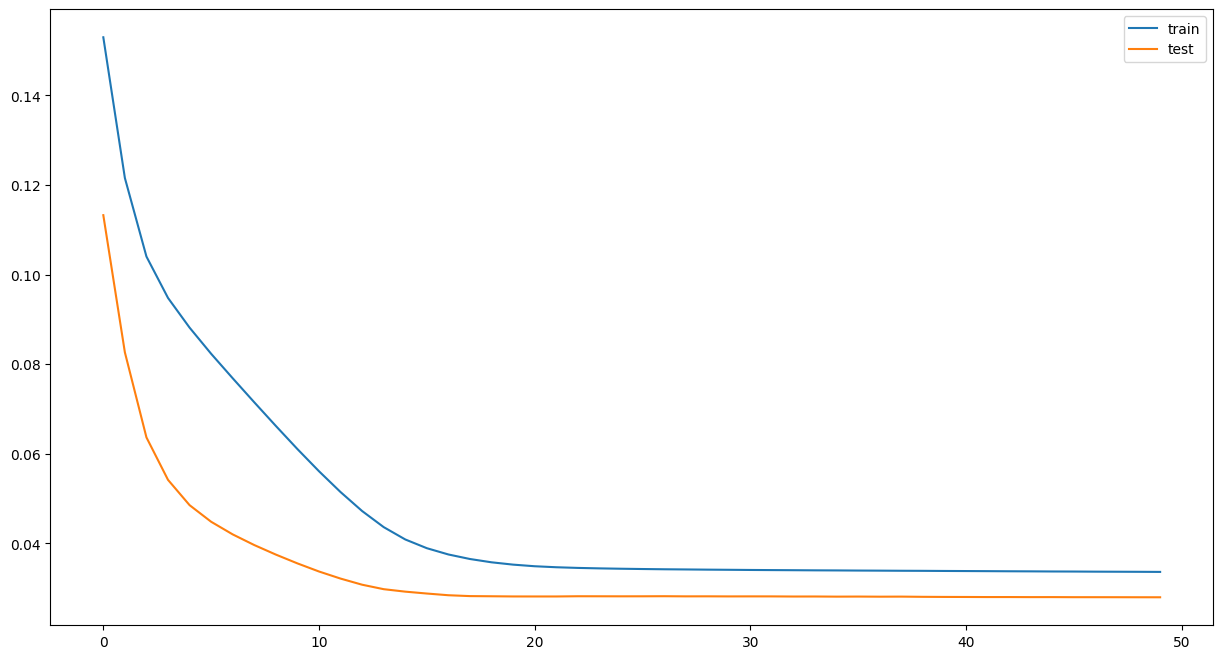

In [38]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [39]:
# make a prediction
pred_y = model.predict(vec_test_X)

8/8 [==============================] - 1s 3ms/step


In [40]:
pred_y[:5]

array([[0.06294252, 0.06525021, 0.06441413, 0.06012362, 0.06497876],
       [0.0702535 , 0.07213435, 0.07130966, 0.06696483, 0.07162932],
       [0.07585685, 0.07725967, 0.0771407 , 0.07486092, 0.07904436],
       [0.0788376 , 0.08025917, 0.08006196, 0.0768116 , 0.08126431],
       [0.07541062, 0.07654835, 0.07620691, 0.07310401, 0.07745403]],
      dtype=float32)

In [41]:
pred_y.shape

(232, 5)

## Resacling Prediction

In [42]:
data_pred = test_data.copy()
for i in data_pred.columns:
  if i.startswith('target'):
    data_pred.drop(columns=i,inplace=True)

In [43]:
for i in range(0,5):
  data_pred['prediction_t'+str(i+1)] = pred_y[:,i]

In [44]:
data_pred

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.062943   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.070253   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.075857   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.078838   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.075411   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.132590   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.166527   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.148833   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.127313   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.108912   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.065250       0.064414       0.060124       0.064979  
2022-07-24         0.072134       0.071310       0.066965       0.071629  
2022-07-25         0.077260       0.077141       0.074861       0.079044  
2022-07-26         0.080259       0.080062       0.076812       0.081264  
2022-07-27         0.076548       0.076207       0.073104       0.077454  
...                     ...            ...            ...            ...  
2023-03-09         0.128947       0.131462       0.134069       0.129881  
2023-03-10         0.162269       0.163451       0.165419       0.159926  
2023-03-11         0.144514       0.146340       0.147764       0.143569  
2023-03-12         0.124055       0.126087       0.127929       0.123920  
2023-03-13         0.106290       0.107939       0.108696       0.105837  

[232 rows x 9 columns]

In [45]:
inv_pred_y = scaler.inverse_transform(data_pred)
inv_pred_y = inv_pred_y[:,-5:]

In [46]:
# Display Predicted values
inv_pred_y[:2,]

array([[565.06661475, 578.45122069, 573.60194623, 548.71698841,
        576.87682807],
       [607.47029334, 618.37920547, 613.59604746, 588.39604259,
        615.45007378]])

## Rescaling Actuals

In [47]:
data_actual= test_data.copy()

In [48]:
inv_test_y = scaler.inverse_transform(data_actual)
inv_test_y = inv_test_y[:,-5:]

In [49]:
# Display Actual target values
inv_test_y[:2,]

array([[730., 670., 730., 730., 470.],
       [670., 730., 730., 470., 530.]])

## Comapring Actuals vs Predicted

In [50]:
pred_df = pd.DataFrame(index=test_data.index)

In [51]:
for i in range(0,5):
  pred_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred_df['prediction_t'+str(i+1)] = inv_pred_y[:,i]

In [52]:
pred_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     565.066615                  670.0   
2022-07-24                    670.0     607.470293                  730.0   
2022-07-25                    730.0     639.969727                  730.0   
2022-07-26                    730.0     657.258099                  470.0   
2022-07-27                    470.0     637.381592                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0     969.020075                 1200.0   
2023-03-10                   1200.0    1165.856186                 1000.0   
2023-03-11                   1000.0    1063.229969                  930.0   
2023-03-12                    930.0     938.414812                  870.0   
2023-03-13                    870.0     831.691968                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       578.451221                  730.0     573.601946   
2022-07-24       618.379205                  730.0     613.596047   
2022-07-25       648.106070                  470.0     647.416082   
2022-07-26       665.503167                  530.0     664.359395   
2022-07-27       643.980403                  600.0     642.000064   
...                     ...                    ...            ...   
2023-03-09       947.891763                 1000.0     962.481806   
2023-03-10      1141.158450                  930.0    1148.018658   
2023-03-11      1038.182551                  870.0    1048.771641   
2023-03-12       919.521452                  930.0     931.301719   
2023-03-13       816.484839                  730.0     826.045969   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     548.716988                  470.0   
2022-07-24                    470.0     588.396043                  530.0   
2022-07-25                    530.0     634.193353                  600.0   
2022-07-26                    600.0     645.507304                  670.0   
2022-07-27                    670.0     624.003252                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0     977.598965                  870.0   
2023-03-10                    870.0    1159.427765                  930.0   
2023-03-11                    930.0    1057.032567                  730.0   
2023-03-12                    730.0     941.988990                  670.0   
2023-03-13                    670.0     830.437830                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       576.876828  
2022-07-24       615.450074  
2022-07-25       658.457270  
2022-07-26       671.332996  
2022-07-27       649.233377  
...                     ...  
2023-03-09       953.310719  
2023-03-10      1127.572340  
2023-03-11      1032.698256  
2023-03-12       918.733716  
2023-03-13       813.854009  

[232 rows x 10 columns]

In [53]:
# Calculate the error
#print("Results of sklearn.metrics:")
#for i in range(1,6):
#  print("MAPE_",i,": %.3f" % mean_absolute_percentage_error(inv_test_y[:,-1*i],inv_pred_y[:,-1*i]))

# Output without the drop NA in features generation

In [54]:
# Calculate the error
error1 = pd.Series()
for i in range(0,5):
  error1['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred_y[:,i])
print("Results of sklearn.metrics:")
print(error1)

Results of sklearn.metrics:
MAPE_1    0.107036
MAPE_2    0.144214
MAPE_3    0.165055
MAPE_4    0.177170
MAPE_5    0.186863
dtype: float64


In [55]:
model_comparision = pd.DataFrame(data = error1)
model_comparision.rename(columns={0:'LSTM'}, inplace= True)
model_comparision

LSTM
MAPE_1  0.107036
MAPE_2  0.144214
MAPE_3  0.165055
MAPE_4  0.177170
MAPE_5  0.186863

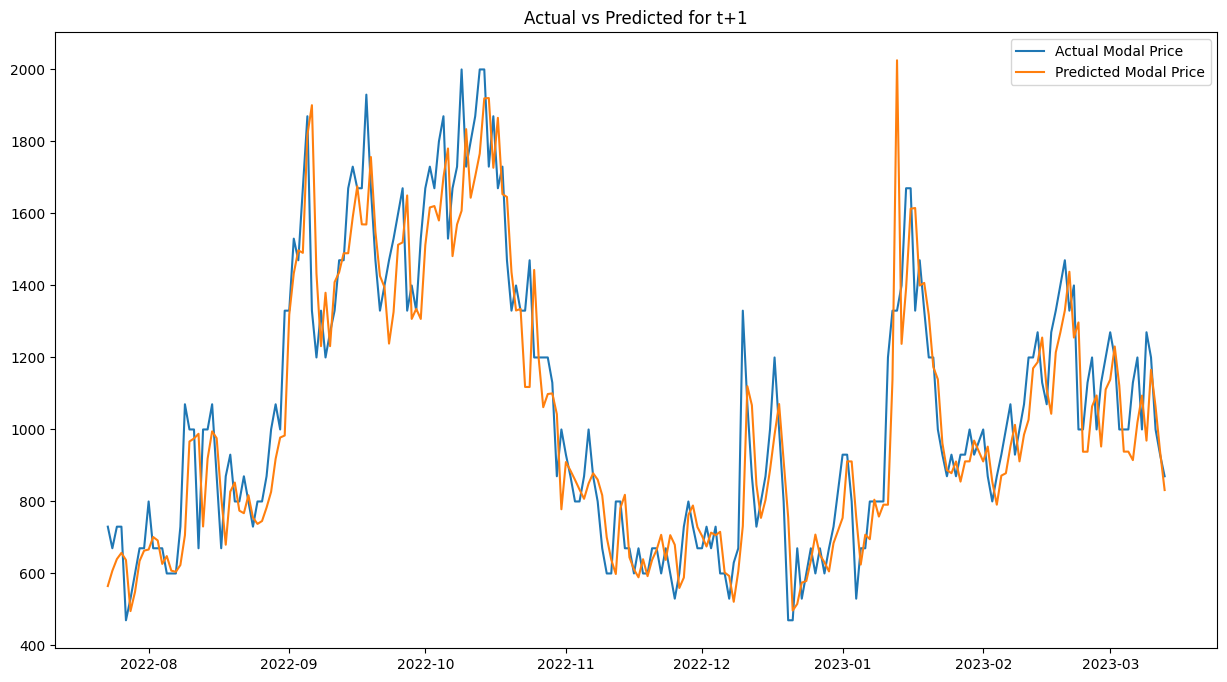

In [56]:
plt.plot(pred_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 2 - Stacked LSTM

## Model Building

In [57]:
# Build the Stacked LSTM model
model_stacked = Sequential()
model_stacked.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_stacked.add(LSTM(50, activation='relu'))
model_stacked.add(Dense(vec_train_y.shape[1]))
model_stacked.compile(optimizer='adam', loss='mae')

In [58]:
# fit network
history_2 = model_stacked.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                              validation_data=(vec_test_X, vec_test_y), verbose=2,
                              shuffle=False)

Epoch 1/50
13/13 - 3s - loss: 0.1619 - val_loss: 0.1286 - 3s/epoch - 255ms/step
Epoch 2/50
13/13 - 0s - loss: 0.1421 - val_loss: 0.1069 - 89ms/epoch - 7ms/step
Epoch 3/50
13/13 - 0s - loss: 0.1230 - val_loss: 0.0840 - 99ms/epoch - 8ms/step
Epoch 4/50
13/13 - 0s - loss: 0.1099 - val_loss: 0.0673 - 100ms/epoch - 8ms/step
Epoch 5/50
13/13 - 0s - loss: 0.1031 - val_loss: 0.0580 - 88ms/epoch - 7ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0980 - val_loss: 0.0521 - 106ms/epoch - 8ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0928 - val_loss: 0.0482 - 97ms/epoch - 7ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0873 - val_loss: 0.0455 - 87ms/epoch - 7ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0811 - val_loss: 0.0436 - 109ms/epoch - 8ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0745 - val_loss: 0.0415 - 101ms/epoch - 8ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0676 - val_loss: 0.0389 - 89ms/epoch - 7ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0611 - val_loss: 0.0359 - 88ms/epoch - 7ms/step
Epoch 13/50
13/13 - 0s - loss: 0.

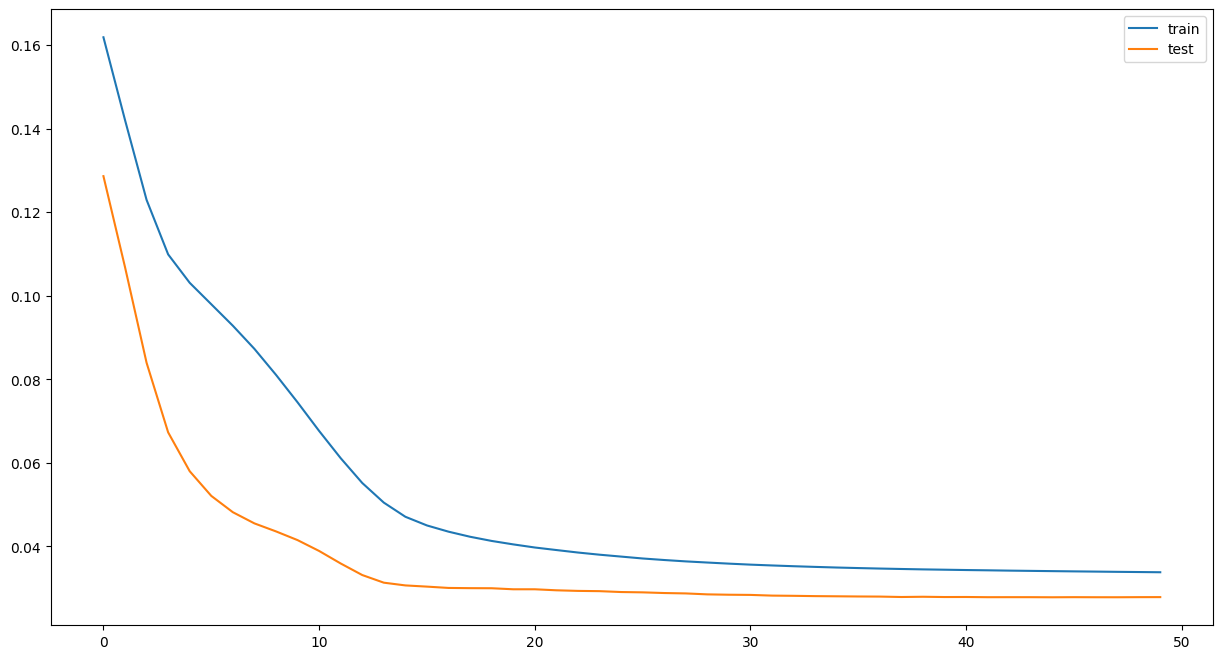

In [59]:
# plot history
plt.plot(history_2.history['loss'], label='train')
plt.plot(history_2.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [60]:
# make a prediction
pred2_y = model_stacked.predict(vec_test_X)

8/8 [==============================] - 0s 3ms/step


In [61]:
pred2_y[:5]

array([[0.06207983, 0.06401536, 0.06434348, 0.06159727, 0.06600018],
       [0.0678839 , 0.06956127, 0.06988465, 0.06706518, 0.07121244],
       [0.07130583, 0.0728907 , 0.07315642, 0.0704035 , 0.07403746],
       [0.07473583, 0.07631177, 0.07655361, 0.0735717 , 0.07743697],
       [0.07081731, 0.07230152, 0.07261562, 0.06999795, 0.07356817]],
      dtype=float32)

In [62]:
pred2_y.shape

(232, 5)

## Rescaling Prediction

In [63]:
data_pred2 = test_data.copy()
for i in data_pred2.columns:
  if i.startswith('target'):
    data_pred2.drop(columns=i,inplace=True)

In [64]:
for i in range(0,5):
  data_pred2['prediction_t'+str(i+1)] = pred2_y[:,i]

In [65]:
data_pred2

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.062080   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.067884   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.071306   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.074736   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.070817   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.137687   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.173502   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.154634   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.131671   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.111485   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.064015       0.064343       0.061597       0.066000  
2022-07-24         0.069561       0.069885       0.067065       0.071212  
2022-07-25         0.072891       0.073156       0.070404       0.074037  
2022-07-26         0.076312       0.076554       0.073572       0.077437  
2022-07-27         0.072302       0.072616       0.069998       0.073568  
...                     ...            ...            ...            ...  
2023-03-09         0.134196       0.136166       0.135166       0.131587  
2023-03-10         0.168708       0.170628       0.169093       0.164429  
2023-03-11         0.150574       0.152536       0.151347       0.147252  
2023-03-12         0.128253       0.130253       0.129389       0.126026  
2023-03-13         0.108775       0.110689       0.110198       0.107596  

[232 rows x 9 columns]

In [66]:
inv_pred2_y = scaler.inverse_transform(data_pred2)
inv_pred2_y = inv_pred2_y[:,-5:]

In [67]:
inv_pred2_y[:2,]

array([[560.06302536, 571.28908038, 573.19219708, 557.26416036,
        582.80103505],
       [593.72662753, 603.45538259, 605.33097237, 588.97804022,
        613.03215623]])

## Comapring Actuals vs Predicted

In [68]:
pred2_df = pd.DataFrame(index=test_data.index)

In [69]:
for i in range(0,5):
  pred2_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred2_df['prediction_t'+str(i+1)] = inv_pred2_y[:,i]

In [70]:
pred2_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     560.063025                  670.0   
2022-07-24                    670.0     593.726628                  730.0   
2022-07-25                    730.0     613.573836                  730.0   
2022-07-26                    730.0     633.467801                  470.0   
2022-07-27                    470.0     610.740378                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0     998.583636                 1200.0   
2023-03-10                   1200.0    1206.308910                 1000.0   
2023-03-11                   1000.0    1096.875206                  930.0   
2023-03-12                    930.0     963.689446                  870.0   
2023-03-13                    870.0     846.613804                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       571.289080                  730.0     573.192197   
2022-07-24       603.455383                  730.0     605.330972   
2022-07-25       622.766054                  470.0     624.307215   
2022-07-26       642.608292                  530.0     644.010955   
2022-07-27       619.348827                  600.0     621.170573   
...                     ...                    ...            ...   
2023-03-09       978.338864                 1000.0     989.763442   
2023-03-10      1178.509232                  930.0    1189.644971   
2023-03-11      1073.328933                  870.0    1084.706408   
2023-03-12       943.865833                  930.0     955.469832   
2023-03-13       830.895805                  730.0     841.998054   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     557.264160                  470.0   
2022-07-24                    470.0     588.978040                  530.0   
2022-07-25                    530.0     608.340308                  600.0   
2022-07-26                    600.0     626.715885                  670.0   
2022-07-27                    670.0     605.988118                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0     983.960405                  870.0   
2023-03-10                    870.0    1180.739993                  930.0   
2023-03-11                    930.0    1077.810505                  730.0   
2023-03-12                    730.0     950.455612                  670.0   
2023-03-13                    670.0     839.147139                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       582.801035  
2022-07-24       613.032156  
2022-07-25       629.417282  
2022-07-26       649.134418  
2022-07-27       626.695359  
...                     ...  
2023-03-09       963.203382  
2023-03-10      1153.690585  
2023-03-11      1054.063722  
2023-03-12       930.949530  
2023-03-13       824.056339  

[232 rows x 10 columns]

In [71]:
# Calculate the error
error2 = pd.Series()
for i in range(0,5):
  error2['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred2_y[:,i])
print("Results of sklearn.metrics:")
print(error2)

Results of sklearn.metrics:
MAPE_1    0.108226
MAPE_2    0.145803
MAPE_3    0.166310
MAPE_4    0.178558
MAPE_5    0.187744
dtype: float64


In [72]:
model_comparision['Stacked_LSTM'] = error2
model_comparision

LSTM  Stacked_LSTM
MAPE_1  0.107036      0.108226
MAPE_2  0.144214      0.145803
MAPE_3  0.165055      0.166310
MAPE_4  0.177170      0.178558
MAPE_5  0.186863      0.187744

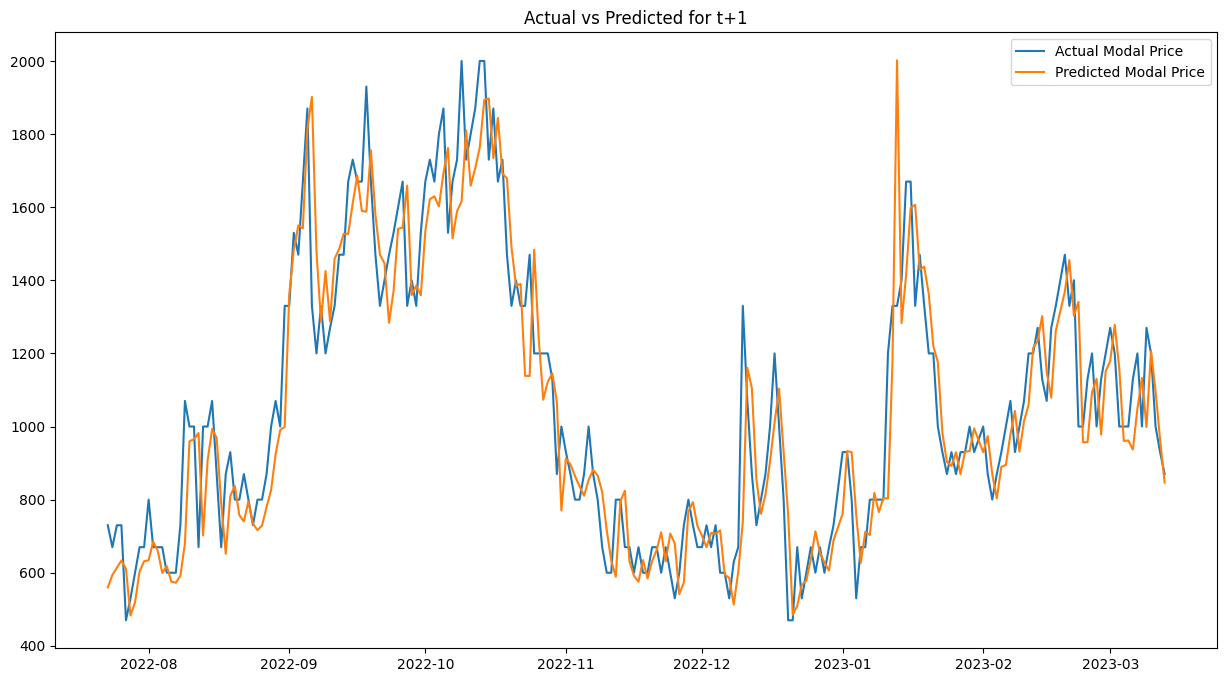

In [73]:
plt.plot(pred2_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred2_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 3 - Bi Directional LSTM

## Model Building

In [74]:
# Build the Bi-Directional LSTM model
model_biDir = Sequential()
model_biDir.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_biDir.add(Dense(vec_train_y.shape[1]))
model_biDir.compile(optimizer='adam', loss='mae')


In [75]:
model_biDir.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              22000     
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 5)                 505       
                                                                 
Total params: 22,505
Trainable params: 22,505
Non-trainable params: 0
_________________________________________________________________


In [76]:
# fit network
history_3 = model_biDir.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                            validation_data=(vec_test_X, vec_test_y), verbose=2,
                            shuffle=False)

Epoch 1/50
13/13 - 4s - loss: 0.1645 - val_loss: 0.1249 - 4s/epoch - 331ms/step
Epoch 2/50
13/13 - 0s - loss: 0.1334 - val_loss: 0.0943 - 87ms/epoch - 7ms/step
Epoch 3/50
13/13 - 0s - loss: 0.1099 - val_loss: 0.0693 - 80ms/epoch - 6ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0986 - val_loss: 0.0565 - 103ms/epoch - 8ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0914 - val_loss: 0.0498 - 85ms/epoch - 7ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0854 - val_loss: 0.0454 - 78ms/epoch - 6ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0798 - val_loss: 0.0423 - 80ms/epoch - 6ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0740 - val_loss: 0.0395 - 92ms/epoch - 7ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0678 - val_loss: 0.0368 - 87ms/epoch - 7ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0616 - val_loss: 0.0343 - 84ms/epoch - 6ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0555 - val_loss: 0.0320 - 84ms/epoch - 6ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0498 - val_loss: 0.0301 - 94ms/epoch - 7ms/step
Epoch 13/50
13/13 - 0s - loss: 0.044

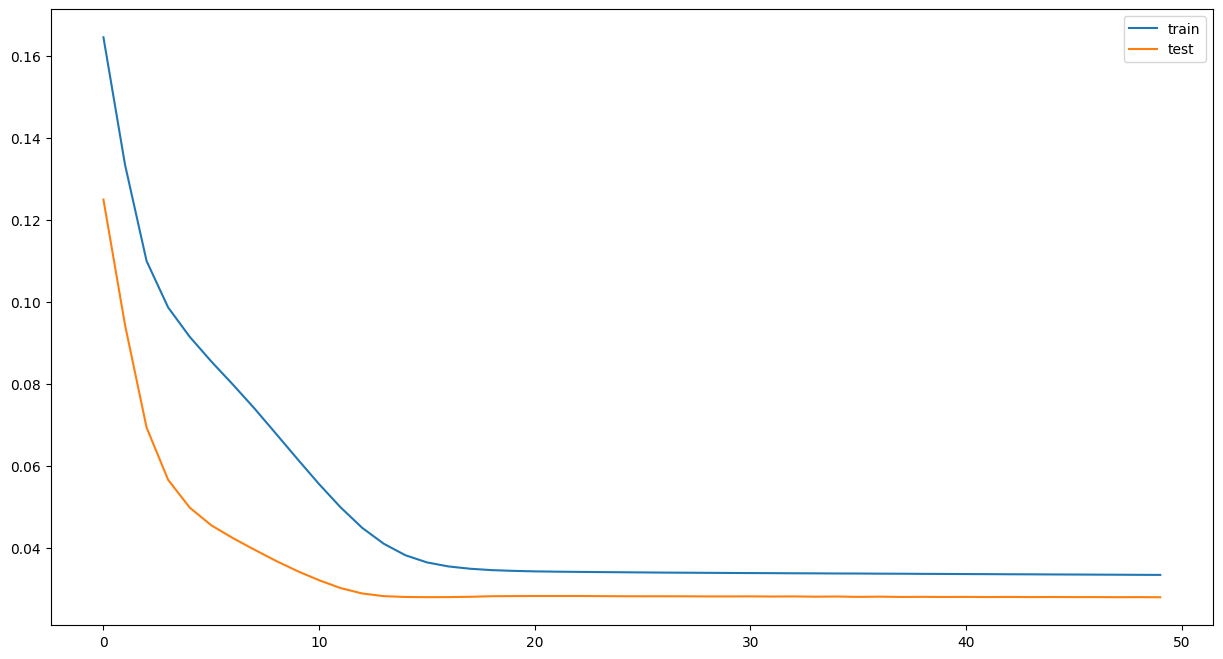

In [77]:
# plot history
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [78]:
# make a prediction
pred3_y = model_biDir.predict(vec_test_X)

8/8 [==============================] - 0s 3ms/step


In [79]:
pred3_y[:5]

array([[0.06273282, 0.06378683, 0.06658287, 0.06259409, 0.06774691],
       [0.06826048, 0.06956924, 0.07261555, 0.0685852 , 0.07307621],
       [0.07203744, 0.07351226, 0.0756828 , 0.07314488, 0.07536548],
       [0.07521992, 0.07703248, 0.07924584, 0.07606864, 0.07897723],
       [0.07131325, 0.07308994, 0.07534343, 0.07247689, 0.07499513]],
      dtype=float32)

In [80]:
pred3_y.shape

(232, 5)

## Rescaling Prediction

In [81]:
data_pred3 = test_data.copy()
for i in data_pred3.columns:
  if i.startswith('target'):
    data_pred3.drop(columns=i,inplace=True)

In [82]:
for i in range(0,5):
  data_pred3['prediction_t'+str(i+1)] = pred3_y[:,i]

In [83]:
data_pred3

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.062733   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.068260   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.072037   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.075220   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.071313   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.134998   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.171002   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.150996   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.129671   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.109858   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.063787       0.066583       0.062594       0.067747  
2022-07-24         0.069569       0.072616       0.068585       0.073076  
2022-07-25         0.073512       0.075683       0.073145       0.075365  
2022-07-26         0.077032       0.079246       0.076069       0.078977  
2022-07-27         0.073090       0.075343       0.072477       0.074995  
...                     ...            ...            ...            ...  
2023-03-09         0.134966       0.134333       0.135365       0.131355  
2023-03-10         0.167961       0.167929       0.168410       0.164268  
2023-03-11         0.150956       0.150536       0.150597       0.147019  
2023-03-12         0.129398       0.129025       0.129802       0.126303  
2023-03-13         0.110622       0.110455       0.110846       0.108305  

[232 rows x 9 columns]

In [84]:
inv_pred3_y = scaler.inverse_transform(data_pred3)
inv_pred3_y = inv_pred3_y[:,-5:]

In [85]:
inv_pred3_y[:5,]

array([[563.85037452, 569.96363997, 586.18066609, 563.0456984 ,
        592.93210655],
       [595.91076076, 603.50162089, 621.17018402, 597.79417217,
        623.84202331],
       [617.81712919, 626.37112886, 638.96021992, 624.24027771,
        637.1197626 ],
       [636.27554625, 646.78836465, 659.62584615, 641.19811058,
        658.06796104],
       [613.61683309, 623.92166555, 636.99189425, 620.36594003,
        634.97175574]])

## Comapring Actuals vs Predicted

In [86]:
pred3_df = pd.DataFrame(index=test_data.index)

In [87]:
for i in range(0,5):
  pred3_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred3_df['prediction_t'+str(i+1)] = inv_pred3_y[:,i]

In [88]:
pred3_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     563.850375                  670.0   
2022-07-24                    670.0     595.910761                  730.0   
2022-07-25                    730.0     617.817129                  730.0   
2022-07-26                    730.0     636.275546                  470.0   
2022-07-27                    470.0     613.616833                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0     982.986635                 1200.0   
2023-03-10                   1200.0    1191.812122                 1000.0   
2023-03-11                   1000.0    1075.776452                  930.0   
2023-03-12                    930.0     952.094436                  870.0   
2023-03-13                    870.0     837.175918                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       569.963640                  730.0     586.180666   
2022-07-24       603.501621                  730.0     621.170184   
2022-07-25       626.371129                  470.0     638.960220   
2022-07-26       646.788365                  530.0     659.625846   
2022-07-27       623.921666                  600.0     636.991894   
...                     ...                    ...            ...   
2023-03-09       982.800126                 1000.0     979.132262   
2023-03-10      1174.175882                  930.0    1173.987386   
2023-03-11      1075.543618                  870.0    1073.109582   
2023-03-12       950.510752                  930.0     948.344985   
2023-03-13       841.606541                  730.0     840.641586   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     563.045698                  470.0   
2022-07-24                    470.0     597.794172                  530.0   
2022-07-25                    530.0     624.240278                  600.0   
2022-07-26                    600.0     641.198111                  670.0   
2022-07-27                    670.0     620.365940                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0     985.116622                  870.0   
2023-03-10                    870.0    1176.780352                  930.0   
2023-03-11                    930.0    1073.464796                  730.0   
2023-03-12                    730.0     952.849892                  670.0   
2023-03-13                    670.0     842.907393                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       592.932107  
2022-07-24       623.842023  
2022-07-25       637.119763  
2022-07-26       658.067961  
2022-07-27       634.971756  
...                     ...  
2023-03-09       961.856595  
2023-03-10      1152.753288  
2023-03-11      1052.712095  
2023-03-12       932.555857  
2023-03-13       828.170252  

[232 rows x 10 columns]

In [89]:
# Calculate the error
error3 = pd.Series()
for i in range(0,5):
  error3['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred3_y[:,i])
print("Results of sklearn.metrics:")
print(error3)

Results of sklearn.metrics:
MAPE_1    0.107729
MAPE_2    0.146773
MAPE_3    0.165301
MAPE_4    0.178150
MAPE_5    0.187349
dtype: float64


In [90]:
model_comparision['BiDir_LSTM'] = error3
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM
MAPE_1  0.107036      0.108226    0.107729
MAPE_2  0.144214      0.145803    0.146773
MAPE_3  0.165055      0.166310    0.165301
MAPE_4  0.177170      0.178558    0.178150
MAPE_5  0.186863      0.187744    0.187349

# Model 4 - Stacked Bi Directional LSTM

## Model Building

In [91]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir = Sequential()
model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir.compile(optimizer='adam', loss='mae')


In [92]:
# fit network
history_4 = model_Stacked_biDir.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
13/13 - 8s - loss: 0.1582 - val_loss: 0.1198 - 8s/epoch - 592ms/step
Epoch 2/50
13/13 - 0s - loss: 0.1273 - val_loss: 0.0834 - 134ms/epoch - 10ms/step
Epoch 3/50
13/13 - 0s - loss: 0.1050 - val_loss: 0.0583 - 122ms/epoch - 9ms/step
Epoch 4/50
13/13 - 0s - loss: 0.0948 - val_loss: 0.0487 - 144ms/epoch - 11ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0871 - val_loss: 0.0449 - 122ms/epoch - 9ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0796 - val_loss: 0.0430 - 117ms/epoch - 9ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0716 - val_loss: 0.0404 - 122ms/epoch - 9ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0632 - val_loss: 0.0365 - 128ms/epoch - 10ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0548 - val_loss: 0.0322 - 158ms/epoch - 12ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0473 - val_loss: 0.0292 - 135ms/epoch - 10ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0422 - val_loss: 0.0290 - 125ms/epoch - 10ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0398 - val_loss: 0.0297 - 133ms/epoch - 10ms/step
Epoch 13/50
13/13 -

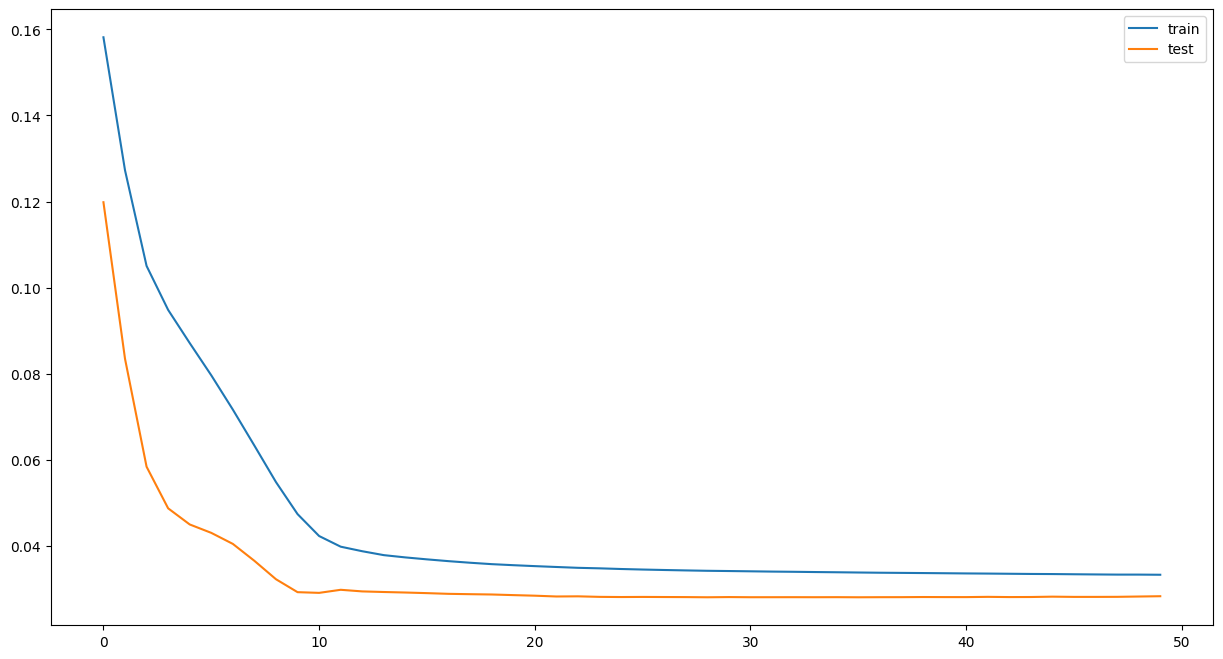

In [93]:
# plot history
plt.plot(history_4.history['loss'], label='train')
plt.plot(history_4.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [94]:
# make a prediction
pred4_y = model_Stacked_biDir.predict(vec_test_X)

8/8 [==============================] - 1s 5ms/step


In [95]:
pred4_y[:5]

array([[0.06172288, 0.06182472, 0.06211506, 0.06358956, 0.06579234],
       [0.06699438, 0.06709307, 0.06699058, 0.06824679, 0.07083874],
       [0.06937554, 0.06989332, 0.06955452, 0.07058336, 0.07303938],
       [0.0728448 , 0.0733356 , 0.0728033 , 0.07390234, 0.07669513],
       [0.06926128, 0.06968243, 0.06935763, 0.07037534, 0.07296832]],
      dtype=float32)

In [96]:
pred4_y.shape

(232, 5)

## Rescaling Prediction

In [97]:
data_pred4 = test_data.copy()
for i in data_pred4.columns:
  if i.startswith('target'):
    data_pred4.drop(columns=i,inplace=True)

In [98]:
for i in range(0,5):
  data_pred4['prediction_t'+str(i+1)] = pred4_y[:,i]

In [99]:
data_pred4

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.061723   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.066994   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.069376   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.072845   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.069261   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.139697   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.174914   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.156352   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.133927   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.113384   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.061825       0.062115       0.063590       0.065792  
2022-07-24         0.067093       0.066991       0.068247       0.070839  
2022-07-25         0.069893       0.069555       0.070583       0.073039  
2022-07-26         0.073336       0.072803       0.073902       0.076695  
2022-07-27         0.069682       0.069358       0.070375       0.072968  
...                     ...            ...            ...            ...  
2023-03-09         0.138414       0.138730       0.138725       0.139610  
2023-03-10         0.172700       0.172962       0.172425       0.173583  
2023-03-11         0.154792       0.155064       0.154701       0.155913  
2023-03-12         0.132607       0.132865       0.132881       0.133740  
2023-03-13         0.112501       0.112760       0.112839       0.113686  

[232 rows x 9 columns]

In [100]:
inv_pred4_y = scaler.inverse_transform(data_pred4)
inv_pred4_y = inv_pred4_y[:,-5:]

In [101]:
inv_pred4_y[:2,]

array([[557.99269453, 558.58335644, 560.26735976, 568.81943643,
        581.59555495],
       [588.56738359, 589.13978785, 588.54534477, 595.8313778 ,
        610.86470336]])

## Comapring Actuals vs Predicted

In [102]:
pred4_df = pd.DataFrame(index=test_data.index)

In [103]:
for i in range(0,5):
  pred4_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred4_df['prediction_t'+str(i+1)] = inv_pred4_y[:,i]

In [104]:
pred4_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     557.992695                  670.0   
2022-07-24                    670.0     588.567384                  730.0   
2022-07-25                    730.0     602.378117                  730.0   
2022-07-26                    730.0     622.499816                  470.0   
2022-07-27                    470.0     601.715440                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0    1010.241565                 1200.0   
2023-03-10                   1200.0    1214.498881                 1000.0   
2023-03-11                   1000.0    1106.841591                  930.0   
2023-03-12                    930.0     976.779121                  870.0   
2023-03-13                    870.0     857.624786                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       558.583356                  730.0     560.267360   
2022-07-24       589.139788                  730.0     588.545345   
2022-07-25       605.381230                  470.0     603.416188   
2022-07-26       625.346453                  530.0     622.259161   
2022-07-27       604.158118                  600.0     602.274232   
...                     ...                    ...            ...   
2023-03-09      1002.802470                 1000.0    1004.634804   
2023-03-10      1201.661053                  930.0    1203.181645   
2023-03-11      1097.795996                  870.0    1099.370864   
2023-03-12       969.118774                  930.0     970.614907   
2023-03-13       852.507934                  730.0     854.006530   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     568.819436                  470.0   
2022-07-24                    470.0     595.831378                  530.0   
2022-07-25                    530.0     609.383479                  600.0   
2022-07-26                    600.0     628.633565                  670.0   
2022-07-27                    670.0     608.176962                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0    1004.604554                  870.0   
2023-03-10                    870.0    1200.065789                  930.0   
2023-03-11                    930.0    1097.267842                  730.0   
2023-03-12                    730.0     970.709285                  670.0   
2023-03-13                    670.0     854.463339                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       581.595555  
2022-07-24       610.864703  
2022-07-25       623.628376  
2022-07-26       644.831750  
2022-07-27       623.216251  
...                     ...  
2023-03-09      1009.736574  
2023-03-10      1206.779504  
2023-03-11      1104.297274  
2023-03-12       975.690317  
2023-03-13       859.381582  

[232 rows x 10 columns]

In [105]:
# Calculate the error
error4 = pd.Series()
for i in range(0,5):
  error4['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred4_y[:,i])
print("Results of sklearn.metrics:")
print(error4)

Results of sklearn.metrics:
MAPE_1    0.110836
MAPE_2    0.149013
MAPE_3    0.169834
MAPE_4    0.182323
MAPE_5    0.192973
dtype: float64


In [106]:
model_comparision['Stacked_BiDir_LSTM'] = error4
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM
MAPE_1  0.107036      0.108226    0.107729            0.110836
MAPE_2  0.144214      0.145803    0.146773            0.149013
MAPE_3  0.165055      0.166310    0.165301            0.169834
MAPE_4  0.177170      0.178558    0.178150            0.182323
MAPE_5  0.186863      0.187744    0.187349            0.192973

# Model 5 - Stacked Bi Directional LSTM With LSTM

## Model Building

In [107]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir2 = Sequential()
model_Stacked_biDir2.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir2.add(LSTM(50, activation='relu'))
model_Stacked_biDir2.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir2.compile(optimizer='adam', loss='mae')


In [108]:
# fit network
history_5 = model_Stacked_biDir2.fit(vec_train_X, vec_train_y, epochs=50, batch_size=72, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/50
13/13 - 6s - loss: 0.1613 - val_loss: 0.1271 - 6s/epoch - 425ms/step
Epoch 2/50
13/13 - 0s - loss: 0.1389 - val_loss: 0.1018 - 108ms/epoch - 8ms/step
Epoch 3/50
13/13 - 0s - loss: 0.1177 - val_loss: 0.0762 - 122ms/epoch - 9ms/step
Epoch 4/50
13/13 - 0s - loss: 0.1056 - val_loss: 0.0609 - 117ms/epoch - 9ms/step
Epoch 5/50
13/13 - 0s - loss: 0.0982 - val_loss: 0.0526 - 125ms/epoch - 10ms/step
Epoch 6/50
13/13 - 0s - loss: 0.0915 - val_loss: 0.0477 - 119ms/epoch - 9ms/step
Epoch 7/50
13/13 - 0s - loss: 0.0844 - val_loss: 0.0448 - 136ms/epoch - 10ms/step
Epoch 8/50
13/13 - 0s - loss: 0.0769 - val_loss: 0.0430 - 108ms/epoch - 8ms/step
Epoch 9/50
13/13 - 0s - loss: 0.0694 - val_loss: 0.0403 - 118ms/epoch - 9ms/step
Epoch 10/50
13/13 - 0s - loss: 0.0620 - val_loss: 0.0367 - 114ms/epoch - 9ms/step
Epoch 11/50
13/13 - 0s - loss: 0.0550 - val_loss: 0.0332 - 114ms/epoch - 9ms/step
Epoch 12/50
13/13 - 0s - loss: 0.0495 - val_loss: 0.0309 - 108ms/epoch - 8ms/step
Epoch 13/50
13/13 - 0s -

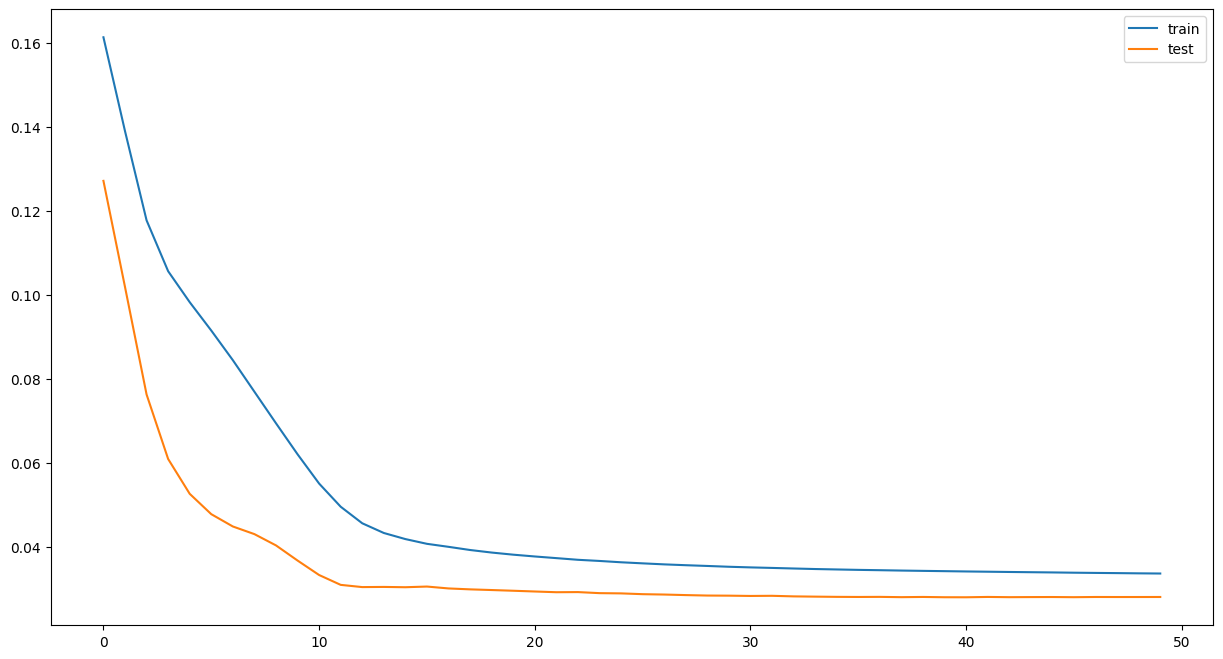

In [109]:
# plot history
plt.plot(history_5.history['loss'], label='train')
plt.plot(history_5.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [110]:
# make a prediction
pred5_y = model_Stacked_biDir2.predict(vec_test_X)

8/8 [==============================] - 1s 5ms/step


In [111]:
pred5_y[:5]

array([[0.06153534, 0.0628589 , 0.06206358, 0.06093082, 0.06438419],
       [0.0669012 , 0.0677291 , 0.06610844, 0.06581492, 0.06918982],
       [0.07092655, 0.07078427, 0.06914535, 0.06965671, 0.07274449],
       [0.07415731, 0.07378884, 0.0720584 , 0.07233272, 0.07593764],
       [0.07015408, 0.0701485 , 0.0685249 , 0.06897131, 0.07212321]],
      dtype=float32)

In [112]:
pred5_y.shape

(232, 5)

## Rescaling Prediction

In [113]:
data_pred5 = test_data.copy()
for i in data_pred5.columns:
  if i.startswith('target'):
    data_pred5.drop(columns=i,inplace=True)

In [114]:
for i in range(0,5):
  data_pred5['prediction_t'+str(i+1)] = pred5_y[:,i]

In [115]:
data_pred5

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.061535   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.066901   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.070927   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.074157   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.070154   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.138949   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.174155   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.155506   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.132597   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.111733   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.062859       0.062064       0.060931       0.064384  
2022-07-24         0.067729       0.066108       0.065815       0.069190  
2022-07-25         0.070784       0.069145       0.069657       0.072744  
2022-07-26         0.073789       0.072058       0.072333       0.075938  
2022-07-27         0.070148       0.068525       0.068971       0.072123  
...                     ...            ...            ...            ...  
2023-03-09         0.135719       0.137773       0.136792       0.134743  
2023-03-10         0.169958       0.171186       0.169995       0.167700  
2023-03-11         0.151870       0.153546       0.152395       0.150504  
2023-03-12         0.129644       0.131562       0.130689       0.128710  
2023-03-13         0.109559       0.111371       0.110888       0.109240  

[232 rows x 9 columns]

In [116]:
inv_pred5_y = scaler.inverse_transform(data_pred5)
inv_pred5_y = inv_pred5_y[:,-5:]

In [117]:
inv_pred5_y[:2,]

array([[556.90499246, 564.58163112, 559.968777  , 553.39876786,
        573.42831492],
       [588.02695721, 592.82878339, 583.42892528, 581.72653466,
        601.30093694]])

## Comapring Actuals vs Predicted

In [118]:
pred5_df = pd.DataFrame(index=test_data.index)

In [119]:
for i in range(0,5):
  pred5_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred5_df['prediction_t'+str(i+1)] = inv_pred5_y[:,i]

In [120]:
pred5_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     556.904992                  670.0   
2022-07-24                    670.0     588.026957                  730.0   
2022-07-25                    730.0     611.374016                  730.0   
2022-07-26                    730.0     630.112413                  470.0   
2022-07-27                    470.0     606.893654                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0    1005.903807                 1200.0   
2023-03-10                   1200.0    1210.101143                 1000.0   
2023-03-11                   1000.0    1101.933762                  930.0   
2023-03-12                    930.0     969.060349                  870.0   
2023-03-13                    870.0     848.051685                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       564.581631                  730.0     559.968777   
2022-07-24       592.828783                  730.0     583.428925   
2022-07-25       610.548770                  470.0     601.043040   
2022-07-26       627.975252                  530.0     617.938732   
2022-07-27       606.861287                  600.0     597.444446   
...                     ...                    ...            ...   
2023-03-09       987.173060                 1000.0     999.086034   
2023-03-10      1185.754040                  930.0    1192.879578   
2023-03-11      1080.844343                  870.0    1090.564412   
2023-03-12       951.933509                  930.0     963.059482   
2023-03-13       835.443753                  730.0     845.953935   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     553.398768                  470.0   
2022-07-24                    470.0     581.726535                  530.0   
2022-07-25                    530.0     604.008946                  600.0   
2022-07-26                    600.0     619.529761                  670.0   
2022-07-27                    670.0     600.033619                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0     993.396303                  870.0   
2023-03-10                    870.0    1185.969761                  930.0   
2023-03-11                    930.0    1083.889934                  730.0   
2023-03-12                    730.0     957.998851                  670.0   
2023-03-13                    670.0     843.152153                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       573.428315  
2022-07-24       601.300937  
2022-07-25       621.918035  
2022-07-26       640.438290  
2022-07-27       618.314601  
...                     ...  
2023-03-09       981.511071  
2023-03-10      1172.661513  
2023-03-11      1072.925752  
2023-03-12       946.515244  
2023-03-13       833.593270  

[232 rows x 10 columns]

In [121]:
# Calculate the error
error5 = pd.Series()
for i in range(0,5):
  error5['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred5_y[:,i])
print("Results of sklearn.metrics:")
print(error5)

Results of sklearn.metrics:
MAPE_1    0.109185
MAPE_2    0.146995
MAPE_3    0.168869
MAPE_4    0.179073
MAPE_5    0.188950
dtype: float64


In [122]:
model_comparision['Stacked_BiDir_LSTM_2'] = error5
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  
MAPE_1              0.109185  
MAPE_2              0.146995  
MAPE_3              0.168869  
MAPE_4              0.179073  
MAPE_5              0.188950

# Model 6 - Stacked Bi Directional LSTM (Model 4 with more Epochs)

## Model Building

In [123]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir3 = Sequential()
model_Stacked_biDir3.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir3.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir3.add(Dense(vec_train_y.shape[1]))
model_Stacked_biDir3.compile(optimizer='adam', loss='mae')

In [124]:
# fit network
history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, epochs=300, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y), verbose=2,
                                    shuffle=False)

Epoch 1/300
10/10 - 7s - loss: 0.1629 - val_loss: 0.1290 - 7s/epoch - 688ms/step
Epoch 2/300
10/10 - 0s - loss: 0.1421 - val_loss: 0.1052 - 126ms/epoch - 13ms/step
Epoch 3/300
10/10 - 0s - loss: 0.1196 - val_loss: 0.0773 - 129ms/epoch - 13ms/step
Epoch 4/300
10/10 - 0s - loss: 0.1053 - val_loss: 0.0593 - 116ms/epoch - 12ms/step
Epoch 5/300
10/10 - 0s - loss: 0.0980 - val_loss: 0.0519 - 134ms/epoch - 13ms/step
Epoch 6/300
10/10 - 0s - loss: 0.0928 - val_loss: 0.0483 - 122ms/epoch - 12ms/step
Epoch 7/300
10/10 - 0s - loss: 0.0880 - val_loss: 0.0458 - 140ms/epoch - 14ms/step
Epoch 8/300
10/10 - 0s - loss: 0.0827 - val_loss: 0.0436 - 125ms/epoch - 13ms/step
Epoch 9/300
10/10 - 0s - loss: 0.0768 - val_loss: 0.0413 - 112ms/epoch - 11ms/step
Epoch 10/300
10/10 - 0s - loss: 0.0703 - val_loss: 0.0390 - 112ms/epoch - 11ms/step
Epoch 11/300
10/10 - 0s - loss: 0.0635 - val_loss: 0.0364 - 130ms/epoch - 13ms/step
Epoch 12/300
10/10 - 0s - loss: 0.0570 - val_loss: 0.0336 - 124ms/epoch - 12ms/step
Epo

In [125]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

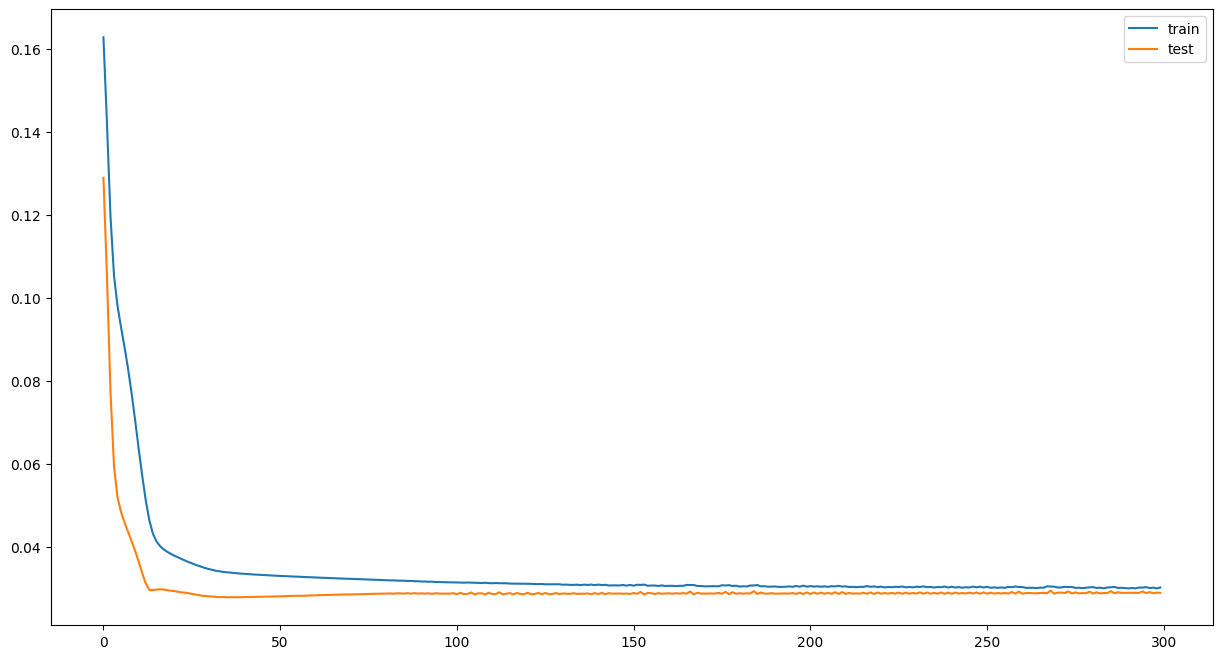

In [126]:
# plot history
plt.plot(history_6.history['loss'], label='train')
plt.plot(history_6.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [127]:
# make a prediction
pred6_y = model_Stacked_biDir3.predict(vec_test_X)

8/8 [==============================] - 1s 3ms/step


In [128]:
pred6_y[:5]

array([[0.08490772, 0.08553983, 0.0824645 , 0.08517434, 0.08367664],
       [0.09323552, 0.09285641, 0.08926026, 0.09193052, 0.09026054],
       [0.08633125, 0.08806962, 0.08637008, 0.08826355, 0.08681564],
       [0.09304111, 0.09255987, 0.08953217, 0.0916108 , 0.09031907],
       [0.09197325, 0.09315687, 0.09103298, 0.09316699, 0.091404  ]],
      dtype=float32)

In [129]:
pred6_y.shape

(232, 5)

## Rescaling Prediction

In [130]:
data_pred6 = test_data.copy()
for i in data_pred6.columns:
  if i.startswith('target'):
    data_pred6.drop(columns=i,inplace=True)

In [131]:
for i in range(0,5):
  data_pred6['prediction_t'+str(i+1)] = pred6_y[:,i]

In [132]:
data_pred6

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.084908   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.093236   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.086331   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.093041   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.091973   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.136086   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.181393   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.162185   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.133653   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.117408   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.085540       0.082465       0.085174       0.083677  
2022-07-24         0.092856       0.089260       0.091931       0.090261  
2022-07-25         0.088070       0.086370       0.088264       0.086816  
2022-07-26         0.092560       0.089532       0.091611       0.090319  
2022-07-27         0.093157       0.091033       0.093167       0.091404  
...                     ...            ...            ...            ...  
2023-03-09         0.134573       0.136061       0.136727       0.137745  
2023-03-10         0.181895       0.181761       0.183437       0.186228  
2023-03-11         0.161441       0.161646       0.162684       0.164820  
2023-03-12         0.131714       0.132545       0.132969       0.133891  
2023-03-13         0.114090       0.114396       0.114059       0.114270  

[232 rows x 9 columns]

In [133]:
inv_pred6_y = scaler.inverse_transform(data_pred6)
inv_pred6_y = inv_pred6_y[:,-5:]

In [134]:
inv_pred6_y[:2,]

array([[692.46476442, 696.13102973, 678.29410732, 694.01119798,
        685.32453328],
       [740.76598734, 738.56720477, 717.70949513, 733.19699317,
        723.51114899]])

## Comapring Actuals vs Predicted

In [135]:
pred6_df = pd.DataFrame(index=test_data.index)

In [136]:
for i in range(0,5):
  pred6_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred6_df['prediction_t'+str(i+1)] = inv_pred6_y[:,i]

In [137]:
pred6_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     692.464764                  670.0   
2022-07-24                    670.0     740.765987                  730.0   
2022-07-25                    730.0     700.721240                  730.0   
2022-07-26                    730.0     739.638421                  470.0   
2022-07-27                    470.0     733.444865                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0     989.297256                 1200.0   
2023-03-10                   1200.0    1252.079126                 1000.0   
2023-03-11                   1000.0    1140.675583                  930.0   
2023-03-12                    930.0     975.189561                  870.0   
2023-03-13                    870.0     880.967653                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       696.131030                  730.0     678.294107   
2022-07-24       738.567205                  730.0     717.709495   
2022-07-25       710.803783                  470.0     700.946468   
2022-07-26       736.847226                  530.0     719.286567   
2022-07-27       740.309870                  600.0     727.991295   
...                     ...                    ...            ...   
2023-03-09       980.523819                 1000.0     989.152232   
2023-03-10      1254.989201                  930.0    1254.215163   
2023-03-11      1136.355889                  870.0    1137.548146   
2023-03-12       963.938615                  930.0     968.760535   
2023-03-13       861.721499                  730.0     863.494717   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     694.011198                  470.0   
2022-07-24                    470.0     733.196993                  530.0   
2022-07-25                    530.0     711.928584                  600.0   
2022-07-26                    600.0     731.342621                  670.0   
2022-07-27                    670.0     740.368554                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0     993.018705                  870.0   
2023-03-10                    870.0    1263.934973                  930.0   
2023-03-11                    930.0    1143.565261                  730.0   
2023-03-12                    730.0     971.223092                  670.0   
2023-03-13                    670.0     861.544324                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       685.324533  
2022-07-24       723.511149  
2022-07-25       703.530714  
2022-07-26       723.850633  
2022-07-27       730.143191  
...                     ...  
2023-03-09       998.919576  
2023-03-10      1280.121577  
2023-03-11      1155.954620  
2023-03-12       976.570141  
2023-03-13       862.763892  

[232 rows x 10 columns]

In [138]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred6_y[:,0])

0.10687896954936317

In [139]:
# Calculate the error
error6 = pd.Series()
for i in range(0,5):
  error6['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred6_y[:,i])
print("Results of sklearn.metrics:")
print(error6)

Results of sklearn.metrics:
MAPE_1    0.106879
MAPE_2    0.149848
MAPE_3    0.177406
MAPE_4    0.193330
MAPE_5    0.206578
dtype: float64


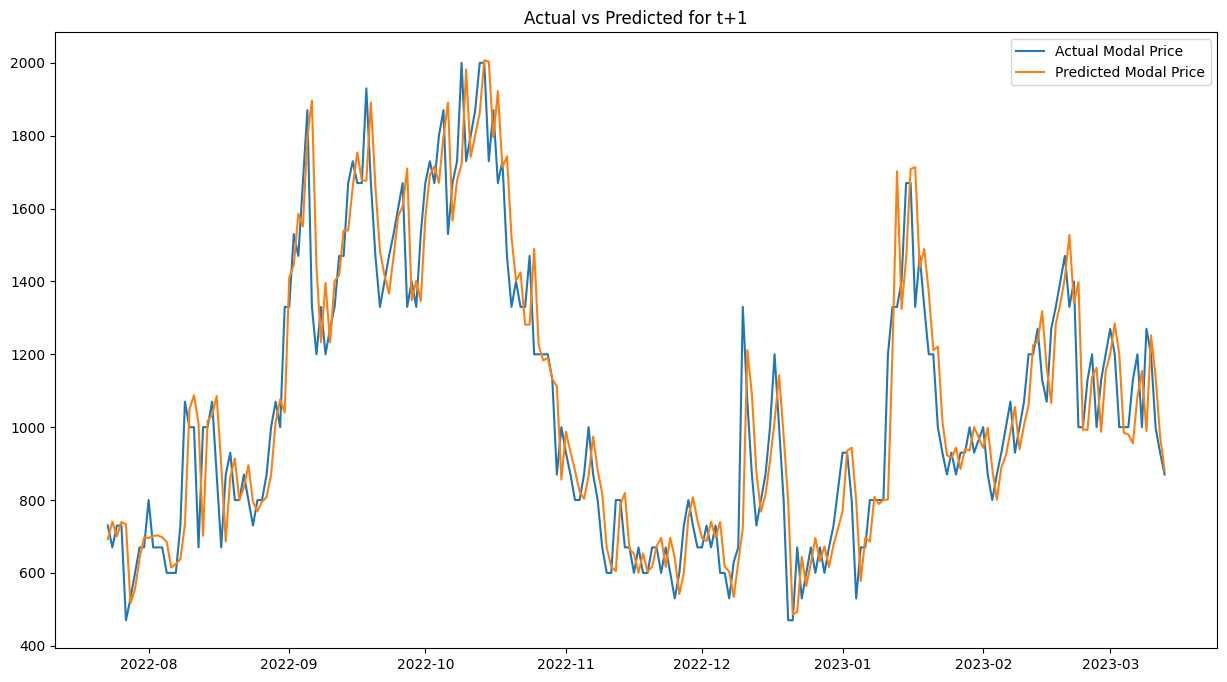

In [140]:
plt.plot(pred6_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred6_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

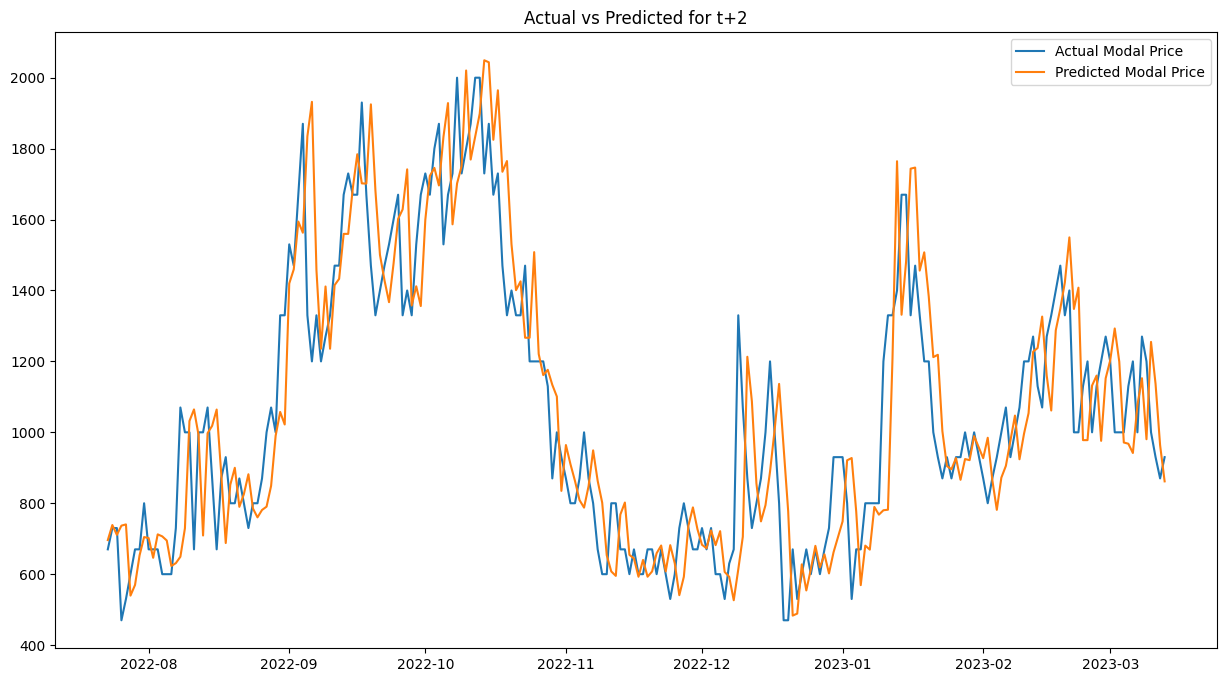

In [141]:
plt.plot(pred6_df['modal_price_actual_t2'], label='Actual Modal Price')
plt.plot(pred6_df['prediction_t2'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+2')
plt.show()

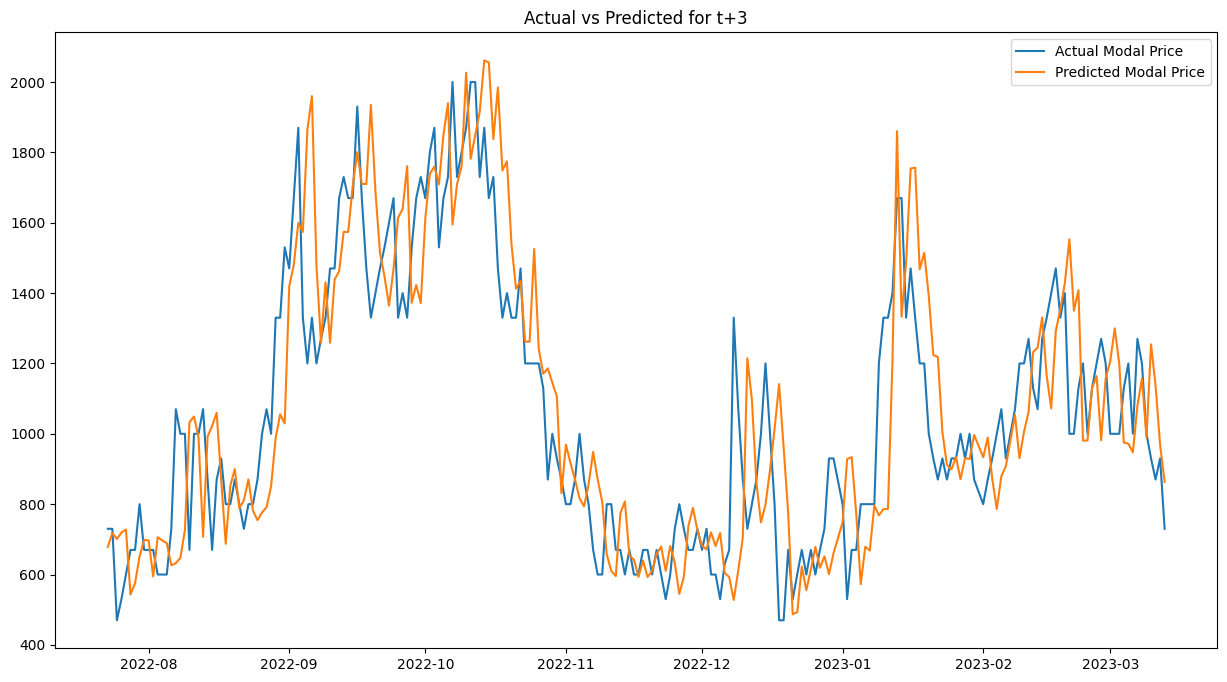

In [142]:
plt.plot(pred6_df['modal_price_actual_t3'], label='Actual Modal Price')
plt.plot(pred6_df['prediction_t3'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+3')
plt.show()

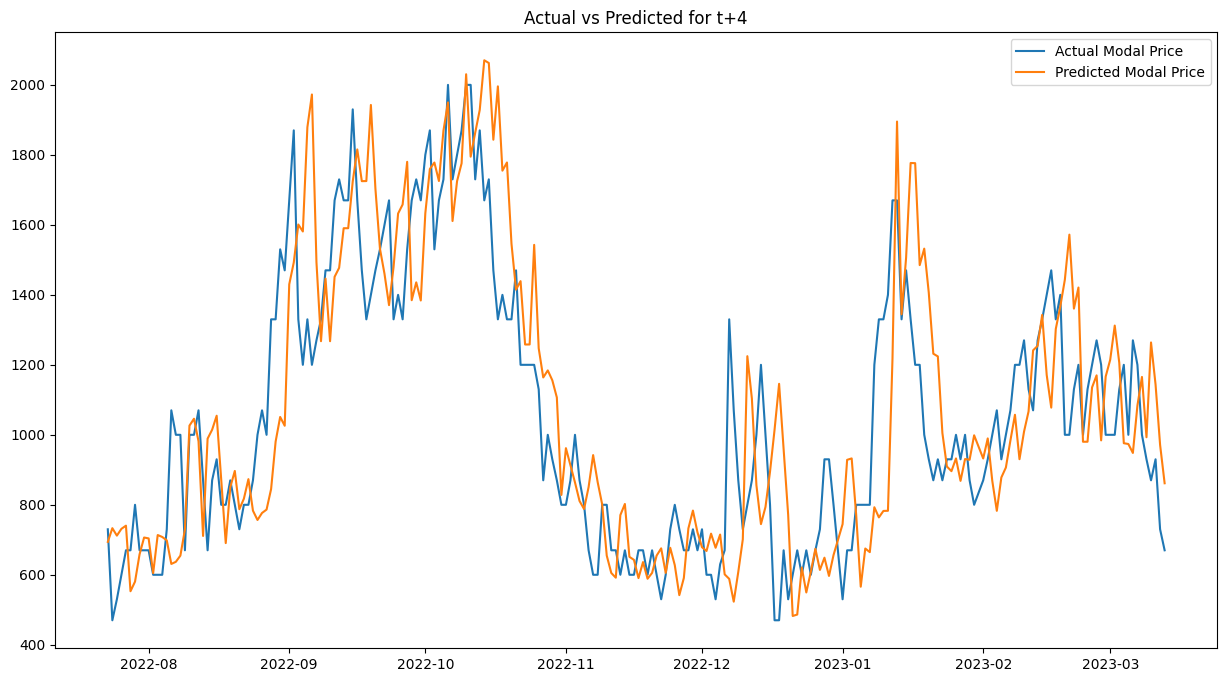

In [143]:
plt.plot(pred6_df['modal_price_actual_t4'], label='Actual Modal Price')
plt.plot(pred6_df['prediction_t4'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+4')
plt.show()

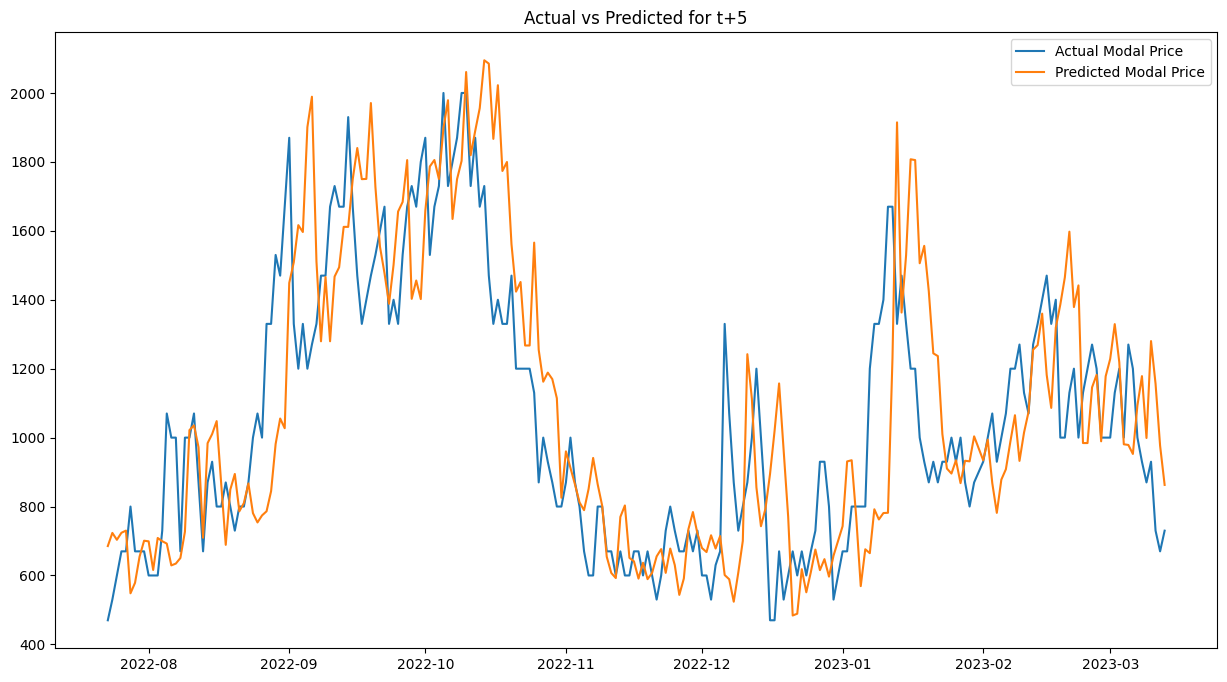

In [144]:
plt.plot(pred6_df['modal_price_actual_t5'], label='Actual Modal Price')
plt.plot(pred6_df['prediction_t5'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+5')
plt.show()

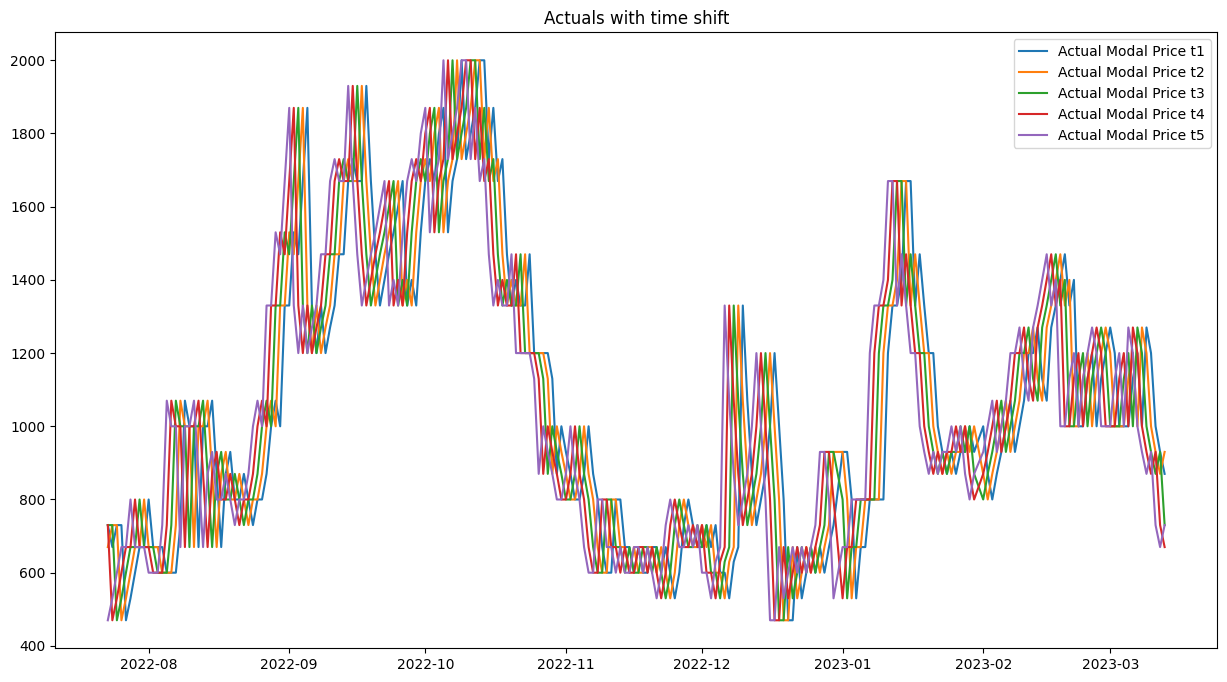

In [145]:
plt.plot(pred6_df['modal_price_actual_t1'], label='Actual Modal Price t1')
plt.plot(pred6_df['modal_price_actual_t2'],  label='Actual Modal Price t2')
plt.plot(pred6_df['modal_price_actual_t3'],  label='Actual Modal Price t3')
plt.plot(pred6_df['modal_price_actual_t4'],  label='Actual Modal Price t4')
plt.plot(pred6_df['modal_price_actual_t5'],  label='Actual Modal Price t5')
plt.legend()
plt.title('Actuals with time shift')
plt.show()

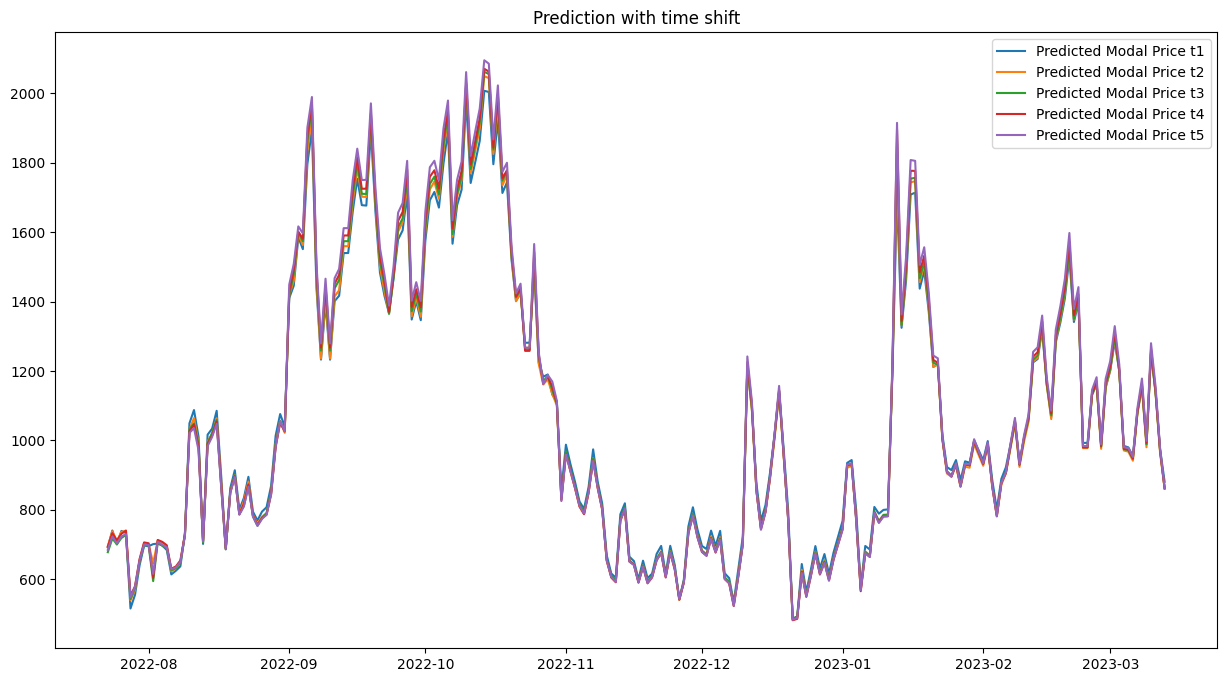

In [146]:
plt.plot(pred6_df['prediction_t1'], label='Predicted Modal Price t1')
plt.plot(pred6_df['prediction_t2'], label='Predicted Modal Price t2')
plt.plot(pred6_df['prediction_t3'], label='Predicted Modal Price t3')
plt.plot(pred6_df['prediction_t4'], label='Predicted Modal Price t4')
plt.plot(pred6_df['prediction_t5'], label='Predicted Modal Price t5')
plt.legend()
plt.title('Prediction with time shift')
plt.show()

In [147]:
inv_pred6_y.shape[1]

5

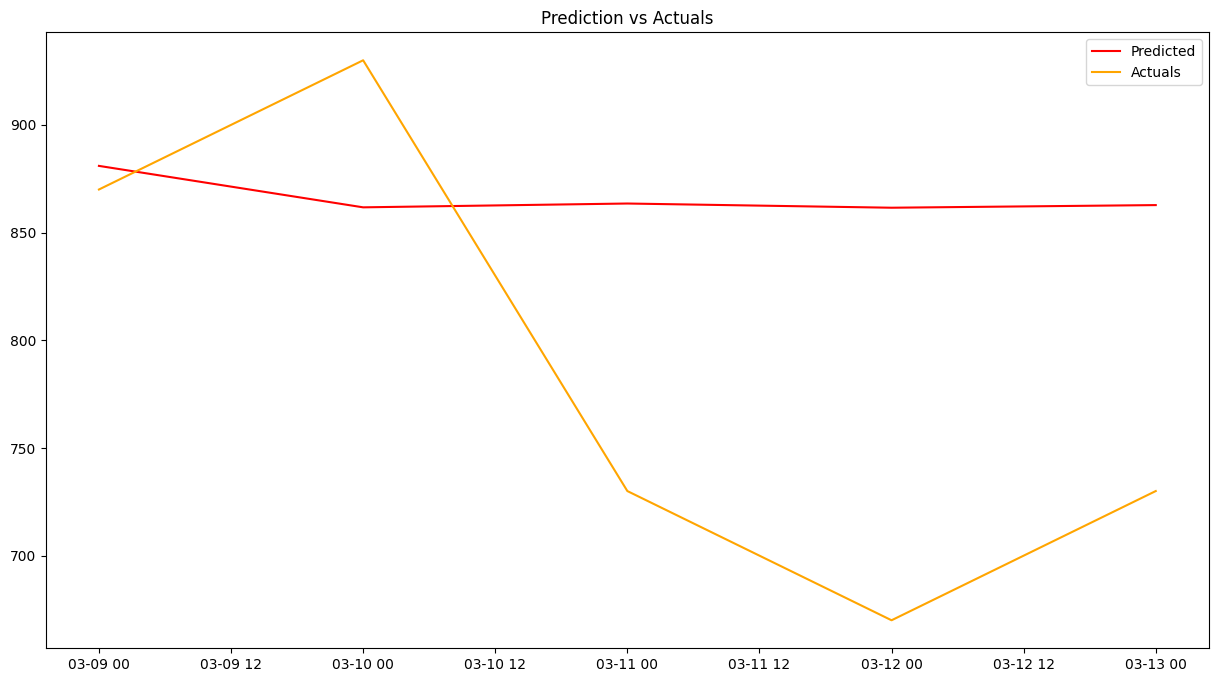

In [148]:
y_pred = inv_pred6_y[-1].reshape(inv_pred6_y.shape[1])
y_actual = inv_test_y[-1:].reshape(inv_test_y.shape[1])
x = pred6_df.index[-5:]
plt.plot(x, y_pred, color="red",label='Predicted')
plt.plot(x, y_actual, color="orange", label='Actuals')
plt.legend()
plt.title('Prediction vs Actuals')
plt.show()

In [149]:
model_comparision['Stacked_BiDir_LSTM_3'] = error6
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  
MAPE_1              0.109185              0.106879  
MAPE_2              0.146995              0.149848  
MAPE_3              0.168869              0.177406  
MAPE_4              0.179073              0.193330  
MAPE_5              0.188950              0.206578

# Model 7 - Stacked Bi Directional LSTM (Hyperparameter tuning) - With Dropout layer.

## Model Building

In [150]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h1 = Sequential()
model_Stacked_biDir_h1.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h1.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h1.add(Bidirectional(LSTM(50, activation='relu')))
model_Stacked_biDir_h1.add(Dropout(0.2))
model_Stacked_biDir_h1.add(Dense(vec_train_y.shape[1], activation='relu'))
model_Stacked_biDir_h1.compile(optimizer='adam', loss='mae')

In [151]:
calls=[
    EarlyStopping(monitor='mean_absolute_error', patience=10), 
    ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/capstone_7A_2.h5', 
                    monitor='mean_absolute_error',
                    save_best_only=True, mode='auto', 
                    save_freq=1)
    ]

In [152]:
# fit network
history_7 = model_Stacked_biDir_h1.fit(vec_train_X, vec_train_y, epochs=300, batch_size=250, 
                                    validation_data=(vec_test_X, vec_test_y),
                                    verbose=1,shuffle=False )

Epoch 1/300
4/4 [==============================] - 8s 247ms/step - loss: 0.1694 - val_loss: 0.1414
Epoch 2/300
4/4 [==============================] - 0s 23ms/step - loss: 0.1616 - val_loss: 0.1328
Epoch 3/300
4/4 [==============================] - 0s 24ms/step - loss: 0.1524 - val_loss: 0.1233
Epoch 4/300
4/4 [==============================] - 0s 25ms/step - loss: 0.1426 - val_loss: 0.1126
Epoch 5/300
4/4 [==============================] - 0s 24ms/step - loss: 0.1325 - val_loss: 0.1007
Epoch 6/300
4/4 [==============================] - 0s 26ms/step - loss: 0.1229 - val_loss: 0.0880
Epoch 7/300
4/4 [==============================] - 0s 25ms/step - loss: 0.1151 - val_loss: 0.0763
Epoch 8/300
4/4 [==============================] - 0s 23ms/step - loss: 0.1090 - val_loss: 0.0667
Epoch 9/300
4/4 [==============================] - 0s 23ms/step - loss: 0.1047 - val_loss: 0.0596
Epoch 10/300
4/4 [==============================] - 0s 23ms/step - loss: 0.1008 - val_loss: 0.0546
Epoch 11/300
4/4 [

In [153]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

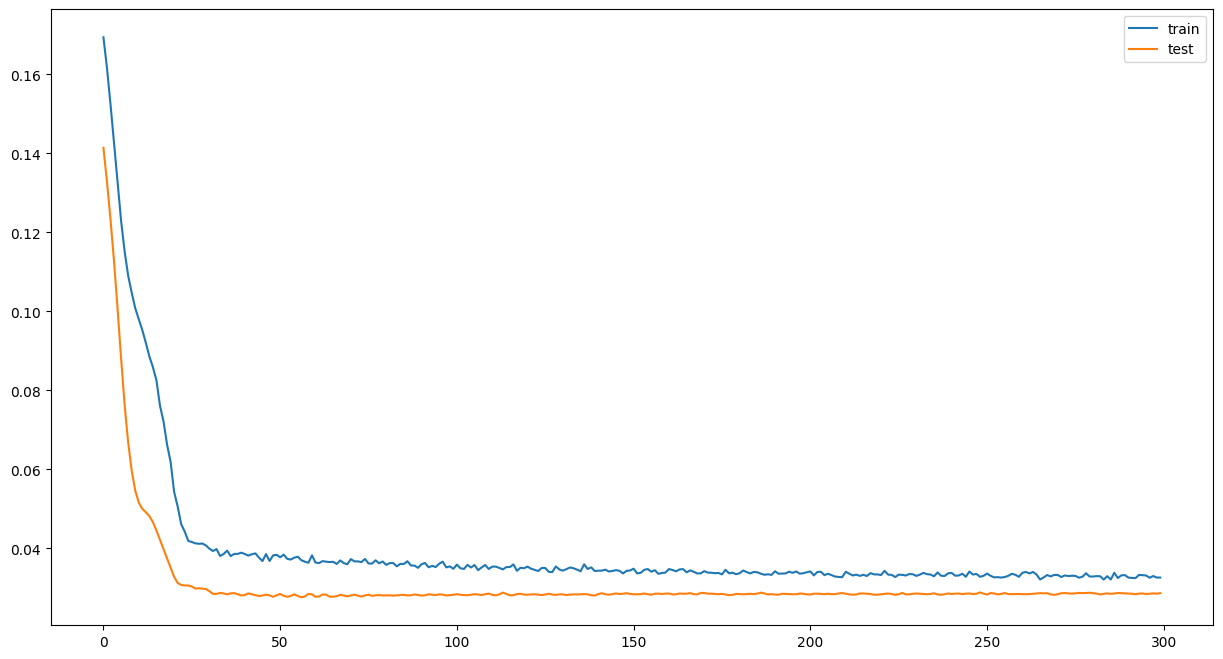

In [154]:
# plot history
plt.plot(history_7.history['loss'], label='train')
plt.plot(history_7.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [155]:
# make a prediction
pred7_y = model_Stacked_biDir_h1.predict(vec_test_X)

8/8 [==============================] - 1s 4ms/step


In [156]:
pred7_y[:5]

array([[0.07381302, 0.07278539, 0.0704601 , 0.07049888, 0.0708814 ],
       [0.08      , 0.07854921, 0.07520608, 0.07480122, 0.07550206],
       [0.0761391 , 0.07571123, 0.0739105 , 0.07413973, 0.07483228],
       [0.08155091, 0.08025876, 0.07691985, 0.07657517, 0.0773718 ],
       [0.07826602, 0.07760471, 0.07551776, 0.07563213, 0.07649437]],
      dtype=float32)

In [157]:
pred7_y.shape

(232, 5)

## Rescaling Prediction

In [158]:
data_pred7 = test_data.copy()
for i in data_pred7.columns:
  if i.startswith('target'):
    data_pred7.drop(columns=i,inplace=True)

In [159]:
for i in range(0,5):
  data_pred7['prediction_t'+str(i+1)] = pred7_y[:,i]

In [160]:
data_pred7

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.073813   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.080000   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.076139   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.081551   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.078266   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.136197   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.178912   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.157088   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.131840   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.111670   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.072785       0.070460       0.070499       0.070881  
2022-07-24         0.078549       0.075206       0.074801       0.075502  
2022-07-25         0.075711       0.073911       0.074140       0.074832  
2022-07-26         0.080259       0.076920       0.076575       0.077372  
2022-07-27         0.077605       0.075518       0.075632       0.076494  
...                     ...            ...            ...            ...  
2023-03-09         0.136391       0.136964       0.138088       0.138365  
2023-03-10         0.179972       0.182283       0.183592       0.184461  
2023-03-11         0.157687       0.159319       0.160495       0.161303  
2023-03-12         0.131817       0.132157       0.133167       0.133610  
2023-03-13         0.111273       0.110881       0.112021       0.112201  

[232 rows x 9 columns]

In [161]:
inv_pred7_y = scaler.inverse_transform(data_pred7)
inv_pred7_y = inv_pred7_y[:,-5:]

In [162]:
inv_pred7_y[:2,]

array([[628.11552286, 622.15527594, 608.66855681, 608.8935256 ,
        611.1121431 ],
       [663.99998963, 655.58539629, 636.19525582, 633.84708464,
        637.91195005]])

## Comapring Actuals vs Predicted

In [163]:
pred7_df = pd.DataFrame(index=test_data.index)

In [164]:
for i in range(0,5):
  pred7_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred7_df['prediction_t'+str(i+1)] = inv_pred7_y[:,i]

In [165]:
pred7_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     628.115523                  670.0   
2022-07-24                    670.0     663.999990                  730.0   
2022-07-25                    730.0     641.606779                  730.0   
2022-07-26                    730.0     672.995284                  470.0   
2022-07-27                    470.0     653.942899                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0     989.943987                 1200.0   
2023-03-10                   1200.0    1237.688470                 1000.0   
2023-03-11                   1000.0    1111.111936                  930.0   
2023-03-12                    930.0     964.669698                  870.0   
2023-03-13                    870.0     847.684890                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       622.155276                  730.0     608.668557   
2022-07-24       655.585396                  730.0     636.195256   
2022-07-25       639.125122                  470.0     628.680927   
2022-07-26       665.500833                  530.0     646.135151   
2022-07-27       650.107324                  600.0     638.003001   
...                     ...                    ...            ...   
2023-03-09       991.066238                 1000.0     994.388914   
2023-03-10      1243.837559                  930.0    1257.240012   
2023-03-11      1114.586464                  870.0    1124.048981   
2023-03-12       964.538935                  930.0     966.508427   
2023-03-13       845.384383                  730.0     843.108119   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     608.893526                  470.0   
2022-07-24                    470.0     633.847085                  530.0   
2022-07-25                    530.0     630.010429                  600.0   
2022-07-26                    600.0     644.136015                  670.0   
2022-07-27                    670.0     638.666369                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0    1000.913182                  870.0   
2023-03-10                    870.0    1264.832515                  930.0   
2023-03-11                    930.0    1130.871162                  730.0   
2023-03-12                    730.0     972.366431                  670.0   
2023-03-13                    670.0     849.722660                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       611.112143  
2022-07-24       637.911950  
2022-07-25       634.027241  
2022-07-26       648.756431  
2022-07-27       643.667322  
...                     ...  
2023-03-09      1002.515274  
2023-03-10      1269.875342  
2023-03-11      1135.555577  
2023-03-12       974.940133  
2023-03-13       850.764447  

[232 rows x 10 columns]

In [166]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred7_y[:,0])

0.10771612065681886

In [167]:
# Calculate the error
error7 = pd.Series()
for i in range(0,5):
  error7['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred7_y[:,i])
print("Results of sklearn.metrics:")
print(error7)

Results of sklearn.metrics:
MAPE_1    0.107716
MAPE_2    0.147669
MAPE_3    0.173840
MAPE_4    0.189186
MAPE_5    0.201251
dtype: float64


In [168]:
model_comparision['Stacked_BiDir_LSTM_H1'] = error7
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  Stacked_BiDir_LSTM_H1  
MAPE_1              0.109185              0.106879               0.107716  
MAPE_2              0.146995              0.149848               0.147669  
MAPE_3              0.168869              0.177406               0.173840  
MAPE_4              0.179073              0.193330               0.189186  
MAPE_5              0.188950              0.206578               0.201251

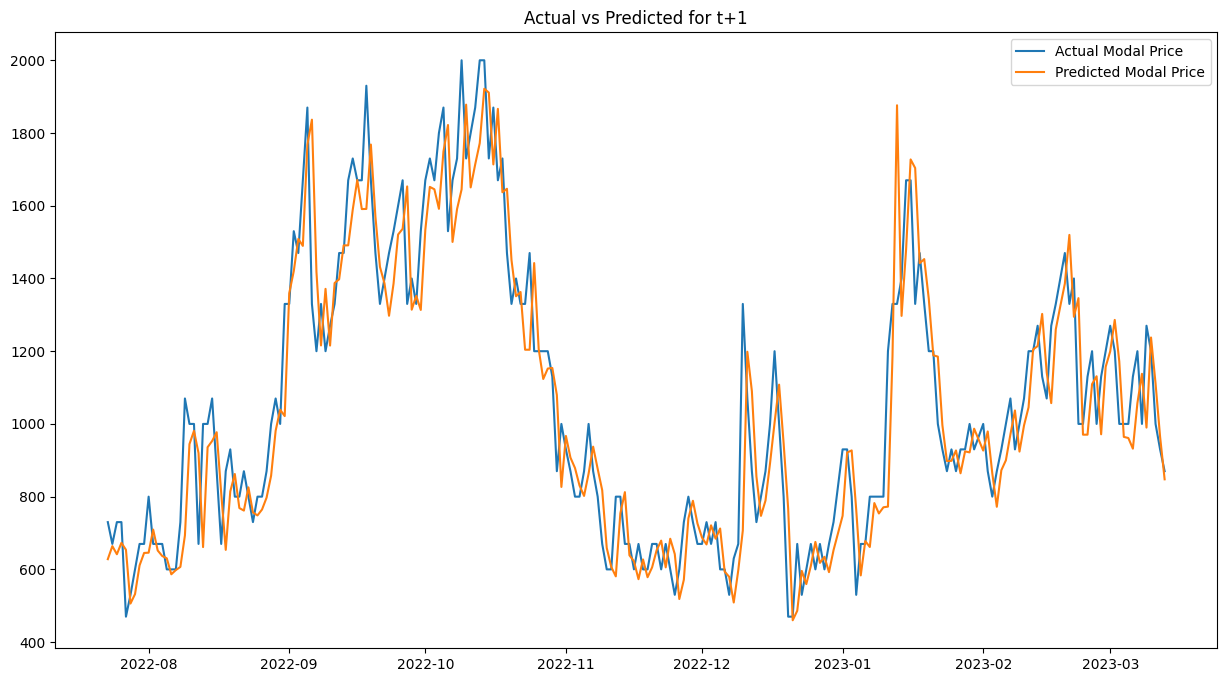

In [169]:
plt.plot(pred7_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred7_df['prediction_t1'],  label='Predicted Modal Price')
plt.legend()
plt.title('Actual vs Predicted for t+1')
plt.show()

# Model 8 - Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of nodes in hidden layers.

## Model Building

In [170]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h2 = Sequential()
model_Stacked_biDir_h2.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h2.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_h2.add(Bidirectional(LSTM(16, activation='relu')))
model_Stacked_biDir_h2.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_h2.add(Dense(vec_train_y.shape[1], activation='relu'))
model_Stacked_biDir_h2.compile(optimizer='adam', loss='mae')

In [171]:
model_Stacked_biDir_h2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 1, 64)            9472      
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1, 64)             0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 5)                 165       
                                                                 
Total params: 20,005
Trainable params: 20,005
Non-trai

In [172]:
# fit network
history_8 = model_Stacked_biDir_h2.fit(vec_train_X, vec_train_y, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y),
                                    verbose=1,shuffle=False )

Epoch 1/250
10/10 [==============================] - 7s 83ms/step - loss: 0.1648 - val_loss: 0.1330
Epoch 2/250
10/10 [==============================] - 0s 11ms/step - loss: 0.1489 - val_loss: 0.1149
Epoch 3/250
10/10 [==============================] - 0s 10ms/step - loss: 0.1318 - val_loss: 0.0946
Epoch 4/250
10/10 [==============================] - 0s 11ms/step - loss: 0.1178 - val_loss: 0.0762
Epoch 5/250
10/10 [==============================] - 0s 12ms/step - loss: 0.1095 - val_loss: 0.0640
Epoch 6/250
10/10 [==============================] - 0s 11ms/step - loss: 0.1043 - val_loss: 0.0570
Epoch 7/250
10/10 [==============================] - 0s 12ms/step - loss: 0.1016 - val_loss: 0.0529
Epoch 8/250
10/10 [==============================] - 0s 11ms/step - loss: 0.0973 - val_loss: 0.0500
Epoch 9/250
10/10 [==============================] - 0s 10ms/step - loss: 0.0941 - val_loss: 0.0475
Epoch 10/250
10/10 [==============================] - 0s 12ms/step - loss: 0.0903 - val_loss: 0.0453

In [173]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

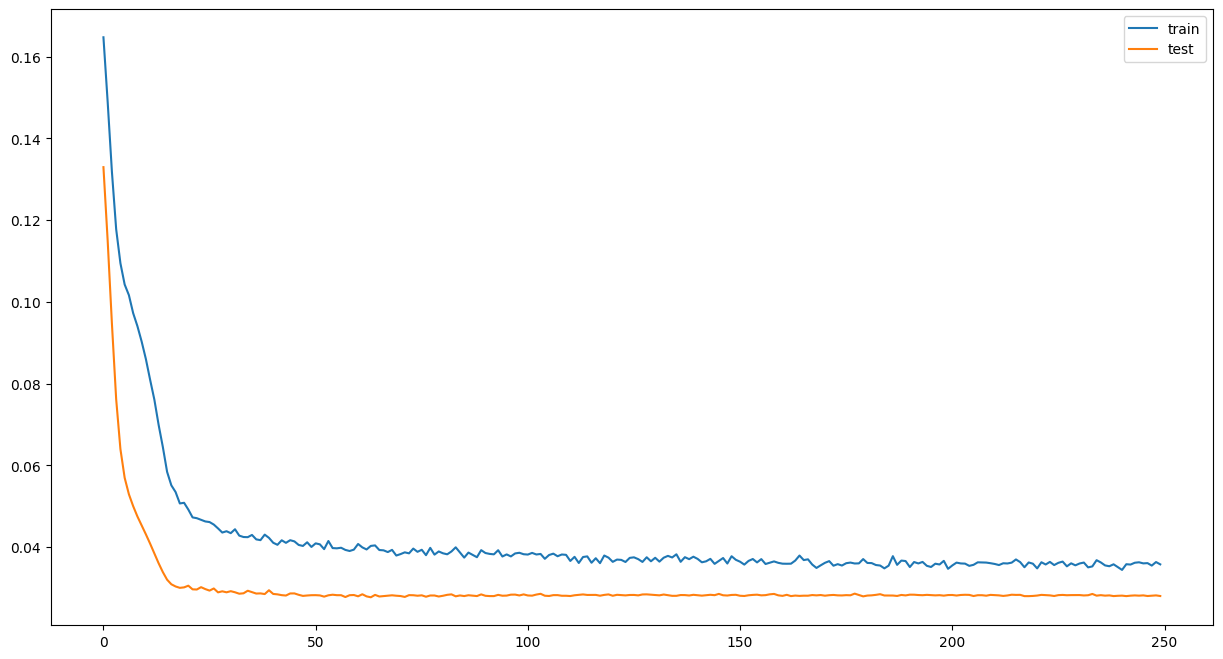

In [174]:
# plot history
plt.plot(history_8.history['loss'], label='train')
plt.plot(history_8.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [175]:
# make a prediction
pred8_y = model_Stacked_biDir_h2.predict(vec_test_X)

8/8 [==============================] - 1s 2ms/step


In [176]:
pred8_y[:5]

array([[0.07543288, 0.07565877, 0.07450762, 0.0750447 , 0.07474308],
       [0.08254441, 0.08257067, 0.08106838, 0.08147085, 0.08164726],
       [0.08235386, 0.08314751, 0.08174888, 0.08268262, 0.0822487 ],
       [0.08622856, 0.08642594, 0.08469829, 0.08520684, 0.08555104],
       [0.08439977, 0.0850824 , 0.08364373, 0.08453256, 0.08418359]],
      dtype=float32)

In [177]:
pred8_y.shape

(232, 5)

## Rescaling Prediction

In [178]:
data_pred8 = test_data.copy()
for i in data_pred8.columns:
  if i.startswith('target'):
    data_pred8.drop(columns=i,inplace=True)

In [179]:
for i in range(0,5):
  data_pred8['prediction_t'+str(i+1)] = pred8_y[:,i]

In [180]:
data_pred8

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.075433   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.082544   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.082354   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.086229   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.084400   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.138723   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.180190   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.158637   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.134216   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.114117   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.075659       0.074508       0.075045       0.074743  
2022-07-24         0.082571       0.081068       0.081471       0.081647  
2022-07-25         0.083148       0.081749       0.082683       0.082249  
2022-07-26         0.086426       0.084698       0.085207       0.085551  
2022-07-27         0.085082       0.083644       0.084533       0.084184  
...                     ...            ...            ...            ...  
2023-03-09         0.138467       0.138913       0.139260       0.139643  
2023-03-10         0.180482       0.181697       0.182354       0.181522  
2023-03-11         0.158696       0.159471       0.160050       0.159889  
2023-03-12         0.133873       0.134177       0.134419       0.134861  
2023-03-13         0.113464       0.113189       0.113180       0.114139  

[232 rows x 9 columns]

In [181]:
inv_pred8_y = scaler.inverse_transform(data_pred8)
inv_pred8_y = inv_pred8_y[:,-5:]

In [182]:
inv_pred8_y[:2,]

array([[637.51071393, 638.82085681, 632.14421868, 635.25925428,
        633.50984752],
       [678.75757068, 678.9098978 , 670.19661367, 672.53095657,
        673.55411947]])

## Comapring Actuals vs Predicted

In [183]:
pred8_df = pd.DataFrame(index=test_data.index)

In [184]:
for i in range(0,5):
  pred8_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred8_df['prediction_t'+str(i+1)] = inv_pred8_y[:,i]

In [185]:
pred8_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     637.510714                  670.0   
2022-07-24                    670.0     678.757571                  730.0   
2022-07-25                    730.0     677.652389                  730.0   
2022-07-26                    730.0     700.125630                  470.0   
2022-07-27                    470.0     689.518693                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0    1004.595739                 1200.0   
2023-03-10                   1200.0    1245.103884                 1000.0   
2023-03-11                   1000.0    1120.096859                  930.0   
2023-03-12                    930.0     978.450787                  870.0   
2023-03-13                    870.0     861.880222                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       638.820857                  730.0     632.144219   
2022-07-24       678.909898                  730.0     670.196614   
2022-07-25       682.255563                  470.0     674.143507   
2022-07-26       701.270439                  530.0     691.250080   
2022-07-27       693.477902                  600.0     685.133617   
...                     ...                    ...            ...   
2023-03-09      1003.110841                 1000.0    1005.695778   
2023-03-10      1246.794477                  930.0    1253.845084   
2023-03-11      1120.438936                  870.0    1124.932003   
2023-03-12       976.464528                  930.0     978.229189   
2023-03-13       858.091187                  730.0     856.498645   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     635.259254                  470.0   
2022-07-24                    470.0     672.530957                  530.0   
2022-07-25                    530.0     679.559222                  600.0   
2022-07-26                    600.0     694.199695                  670.0   
2022-07-27                    670.0     690.288842                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0    1007.706583                  870.0   
2023-03-10                    870.0    1257.655725                  930.0   
2023-03-11                    930.0    1128.289077                  730.0   
2023-03-12                    730.0     979.628611                  670.0   
2023-03-13                    670.0     856.441344                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       633.509848  
2022-07-24       673.554119  
2022-07-25       677.042475  
2022-07-26       696.196023  
2022-07-27       688.264814  
...                     ...  
2023-03-09      1009.928355  
2023-03-10      1252.825421  
2023-03-11      1127.358001  
2023-03-12       982.195485  
2023-03-13       862.004071  

[232 rows x 10 columns]

In [186]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred8_y[:,0])

0.10612902993909766

In [187]:
# Calculate the error
error8 = pd.Series()
for i in range(0,5):
  error8['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred8_y[:,i])
print("Results of sklearn.metrics:")
print(error8)

Results of sklearn.metrics:
MAPE_1    0.106129
MAPE_2    0.146629
MAPE_3    0.171409
MAPE_4    0.184121
MAPE_5    0.194481
dtype: float64


In [188]:
model_comparision['Stacked_BiDir_LSTM_H2'] = error8
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  Stacked_BiDir_LSTM_H1  \
MAPE_1              0.109185              0.106879               0.107716   
MAPE_2              0.146995              0.149848               0.147669   
MAPE_3              0.168869              0.177406               0.173840   
MAPE_4              0.179073              0.193330               0.189186   
MAPE_5              0.188950              0.206578               0.201251   

        Stacked_BiDir_LSTM_H2  
MAPE_1               0.106129  
MAPE_2               0.146629  
MAPE_3               0.171409  
MAPE_4               0.184121  
MAPE_5               0.194481

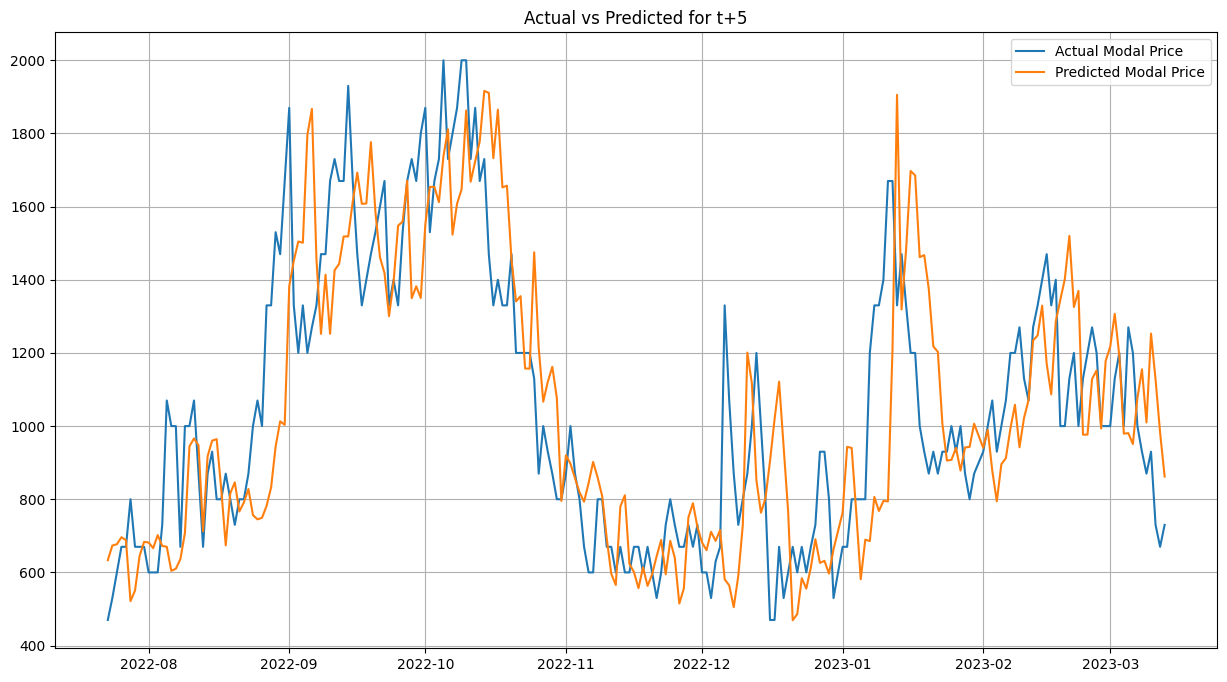

In [189]:
plt.plot(pred8_df['modal_price_actual_t5'], label='Actual Modal Price')
plt.plot(pred8_df['prediction_t5'],  label='Predicted Modal Price')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

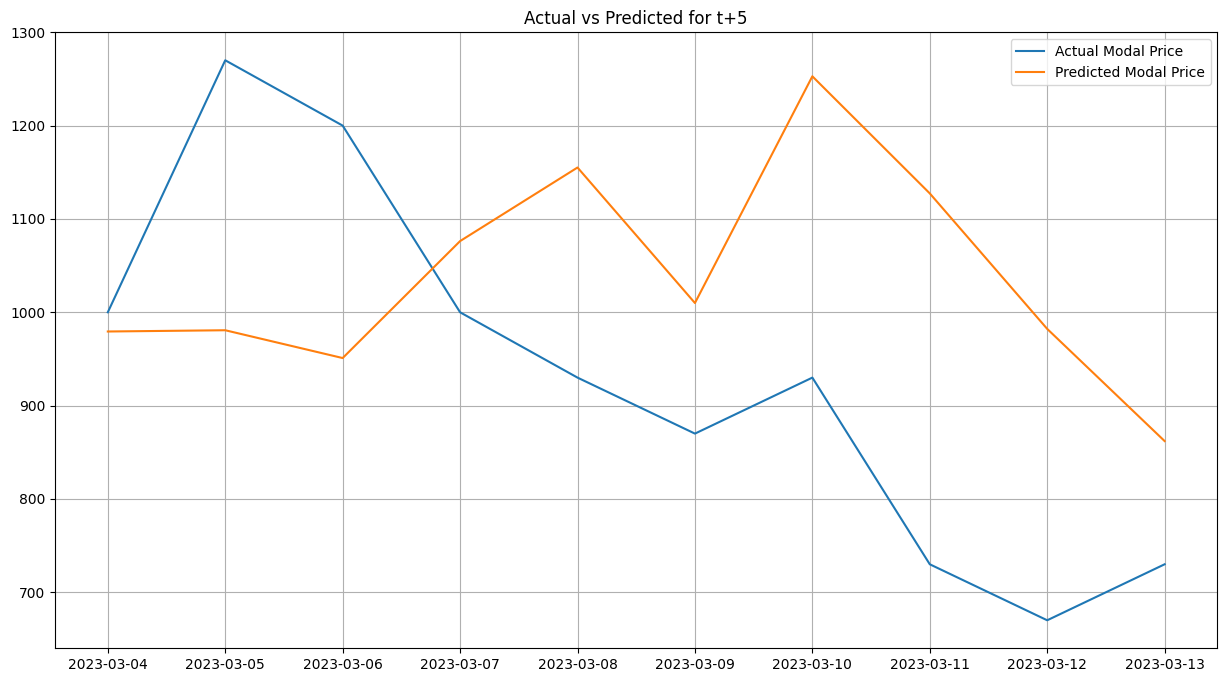

In [190]:
plt.plot(pred8_df['modal_price_actual_t5'][-10:], label='Actual Modal Price')
plt.plot(pred8_df['prediction_t5'][-10:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

In [191]:
pred8_df.index[-10:-5]

DatetimeIndex(['2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08'],
              dtype='datetime64[ns]', name='arrival_date', freq=None)

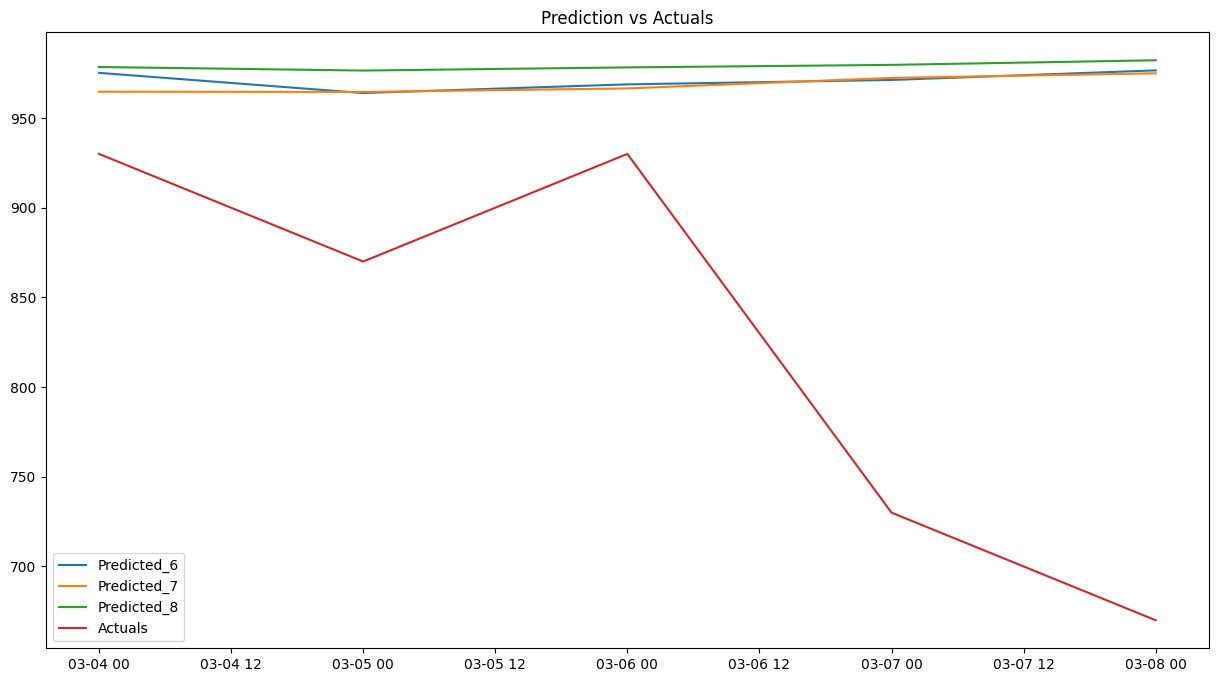

In [192]:
y_pred_6 = inv_pred6_y[-2:-1].reshape(inv_pred6_y.shape[1])
y_pred_7 = inv_pred7_y[-2:-1].reshape(inv_pred7_y.shape[1])
y_pred_8 = inv_pred8_y[-2:-1].reshape(inv_pred8_y.shape[1])
y_actual = inv_test_y[-2:-1].reshape(inv_test_y.shape[1])
x = pred8_df.index[-10:-5]
plt.plot(x, y_pred_6, label='Predicted_6')
plt.plot(x, y_pred_7, label='Predicted_7')
plt.plot(x, y_pred_8, label='Predicted_8')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.title('Prediction vs Actuals')
plt.show()

# Model 9 - Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of nodes in hidden layers.

## Model Building

In [193]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h3 = Sequential()
model_Stacked_biDir_h3.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h3.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_h3.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_h3.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_h3.add(Dense(vec_train_y.shape[1], activation='relu'))
model_Stacked_biDir_h3.compile(optimizer='adam', loss='mae')

In [194]:
model_Stacked_biDir_h3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 1, 16)            832       
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 16)             0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 85        
                                                                 
Total params: 2,517
Trainable params: 2,517
Non-traina

In [195]:
# fit network
history_9 = model_Stacked_biDir_h3.fit(vec_train_X, vec_train_y, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y),
                                    verbose=1,shuffle=False )

Epoch 1/250
10/10 [==============================] - 7s 79ms/step - loss: 0.1618 - val_loss: 0.1307
Epoch 2/250
10/10 [==============================] - 0s 10ms/step - loss: 0.1473 - val_loss: 0.1154
Epoch 3/250
10/10 [==============================] - 0s 10ms/step - loss: 0.1335 - val_loss: 0.1003
Epoch 4/250
10/10 [==============================] - 0s 12ms/step - loss: 0.1228 - val_loss: 0.0871
Epoch 5/250
10/10 [==============================] - 0s 10ms/step - loss: 0.1161 - val_loss: 0.0772
Epoch 6/250
10/10 [==============================] - 0s 12ms/step - loss: 0.1116 - val_loss: 0.0703
Epoch 7/250
10/10 [==============================] - 0s 10ms/step - loss: 0.1099 - val_loss: 0.0659
Epoch 8/250
10/10 [==============================] - 0s 11ms/step - loss: 0.1077 - val_loss: 0.0630
Epoch 9/250
10/10 [==============================] - 0s 12ms/step - loss: 0.1068 - val_loss: 0.0611
Epoch 10/250
10/10 [==============================] - 0s 12ms/step - loss: 0.1056 - val_loss: 0.0595

In [196]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

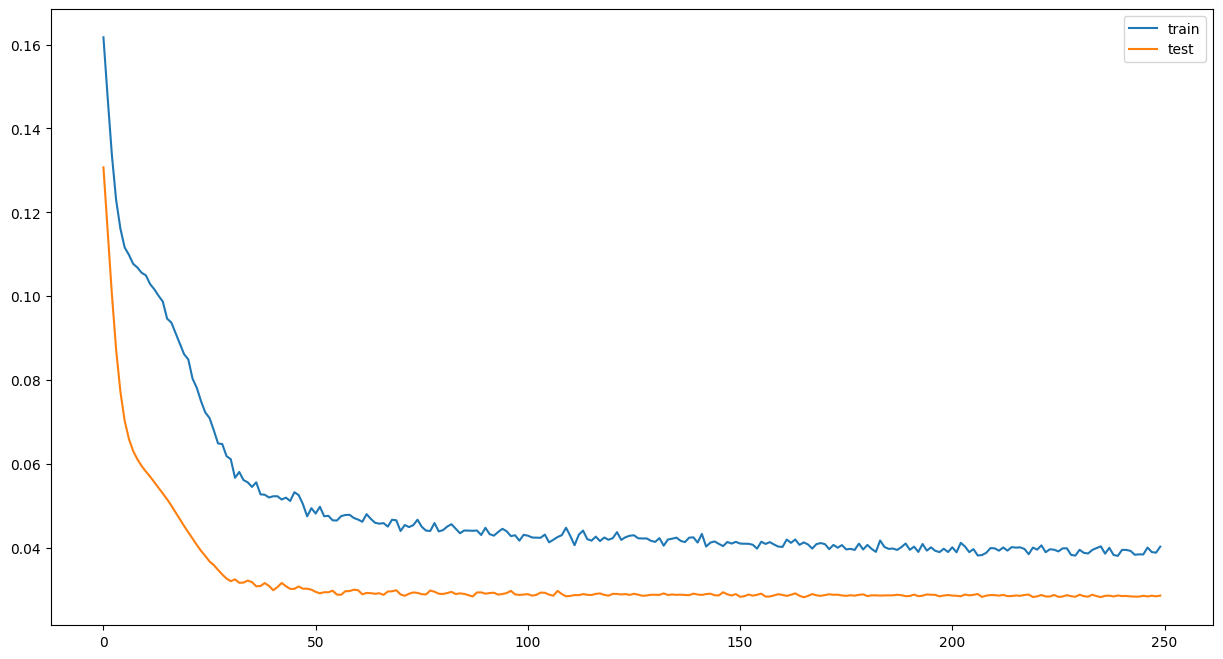

In [197]:
# plot history
plt.plot(history_9.history['loss'], label='train')
plt.plot(history_9.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [198]:
# make a prediction
pred9_y = model_Stacked_biDir_h3.predict(vec_test_X)

8/8 [==============================] - 1s 3ms/step


In [199]:
pred9_y[:5]

array([[0.07091504, 0.07054723, 0.0680199 , 0.06899512, 0.06847773],
       [0.07703741, 0.07634323, 0.07252681, 0.07446745, 0.0731118 ],
       [0.07841255, 0.07763024, 0.07361282, 0.07582299, 0.0742595 ],
       [0.0826827 , 0.08165553, 0.07674792, 0.07956631, 0.07745534],
       [0.07835573, 0.07758264, 0.07358275, 0.07574561, 0.07425974]],
      dtype=float32)

In [200]:
pred9_y.shape

(232, 5)

## Rescaling Prediction

In [201]:
data_pred9 = test_data.copy()
for i in data_pred9.columns:
  if i.startswith('target'):
    data_pred9.drop(columns=i,inplace=True)

In [202]:
for i in range(0,5):
  data_pred9['prediction_t'+str(i+1)] = pred9_y[:,i]

In [203]:
data_pred9

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.070915   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.077037   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.078413   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.082683   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.078356   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.143062   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.177975   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.159177   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.138070   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.116760   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.070547       0.068020       0.068995       0.068478  
2022-07-24         0.076343       0.072527       0.074467       0.073112  
2022-07-25         0.077630       0.073613       0.075823       0.074259  
2022-07-26         0.081656       0.076748       0.079566       0.077455  
2022-07-27         0.077583       0.073583       0.075746       0.074260  
...                     ...            ...            ...            ...  
2023-03-09         0.142909       0.138676       0.140375       0.138441  
2023-03-10         0.177117       0.174302       0.174732       0.173452  
2023-03-11         0.158585       0.155131       0.156156       0.154507  
2023-03-12         0.137958       0.133613       0.135475       0.133453  
2023-03-13         0.116813       0.111773       0.114429       0.111872  

[232 rows x 9 columns]

In [204]:
inv_pred9_y = scaler.inverse_transform(data_pred9)
inv_pred9_y = inv_pred9_y[:,-5:]

In [205]:
inv_pred9_y[:2,]

array([[611.30725145, 609.17393714, 594.51544434, 600.17168522,
        597.17086256],
       [646.8169719 , 642.79073924, 620.65551281, 631.91121221,
        624.04845357]])

## Comapring Actuals vs Predicted

In [206]:
pred9_df = pd.DataFrame(index=test_data.index)

In [207]:
for i in range(0,5):
  pred9_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred9_df['prediction_t'+str(i+1)] = inv_pred9_y[:,i]

In [208]:
pred9_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     611.307251                  670.0   
2022-07-24                    670.0     646.816972                  730.0   
2022-07-25                    730.0     654.792777                  730.0   
2022-07-26                    730.0     679.559654                  470.0   
2022-07-27                    470.0     654.463232                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0    1029.761562                 1200.0   
2023-03-10                   1200.0    1232.253957                 1000.0   
2023-03-11                   1000.0    1123.225421                  930.0   
2023-03-12                    930.0    1000.807136                  870.0   
2023-03-13                    870.0     877.209300                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       609.173937                  730.0     594.515444   
2022-07-24       642.790739                  730.0     620.655513   
2022-07-25       650.255373                  470.0     626.954336   
2022-07-26       673.602086                  530.0     645.137960   
2022-07-27       649.979326                  600.0     626.779927   
...                     ...                    ...            ...   
2023-03-09      1028.872144                 1000.0    1004.322803   
2023-03-10      1227.280962                  930.0    1210.953137   
2023-03-11      1119.790995                  870.0    1099.757710   
2023-03-12      1000.157294                  930.0     974.956900   
2023-03-13       877.513176                  730.0     848.284951   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     600.171685                  470.0   
2022-07-24                    470.0     631.911212                  530.0   
2022-07-25                    530.0     639.773366                  600.0   
2022-07-26                    600.0     661.484583                  670.0   
2022-07-27                    670.0     639.324552                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0    1014.176747                  870.0   
2023-03-10                    870.0    1213.445598                  930.0   
2023-03-11                    930.0    1105.703005                  730.0   
2023-03-12                    730.0     985.754019                  670.0   
2023-03-13                    670.0     863.689652                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       597.170863  
2022-07-24       624.048454  
2022-07-25       630.705084  
2022-07-26       649.240983  
2022-07-27       630.706467  
...                     ...  
2023-03-09      1002.958125  
2023-03-10      1206.021714  
2023-03-11      1096.142566  
2023-03-12       974.029195  
2023-03-13       848.854849  

[232 rows x 10 columns]

In [209]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred9_y[:,0])

0.10762055537100972

In [210]:
# Calculate the error
error9 = pd.Series()
for i in range(0,5):
  error9['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred9_y[:,i])
print("Results of sklearn.metrics:")
print(error9)

Results of sklearn.metrics:
MAPE_1    0.107621
MAPE_2    0.147887
MAPE_3    0.174011
MAPE_4    0.183825
MAPE_5    0.194072
dtype: float64


In [211]:
model_comparision['Stacked_BiDir_LSTM_H3'] = error9
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  Stacked_BiDir_LSTM_H1  \
MAPE_1              0.109185              0.106879               0.107716   
MAPE_2              0.146995              0.149848               0.147669   
MAPE_3              0.168869              0.177406               0.173840   
MAPE_4              0.179073              0.193330               0.189186   
MAPE_5              0.188950              0.206578               0.201251   

        Stacked_BiDir_LSTM_H2  Stacked_BiDir_LSTM_H3  
MAPE_1               0.106129               0.107621  
MAPE_2               0.146629               0.147887  
MAPE_3               0.171409               0.174011  
MAPE_4               0.184121               0.183825  
MAPE_5               0.194481               0.194072

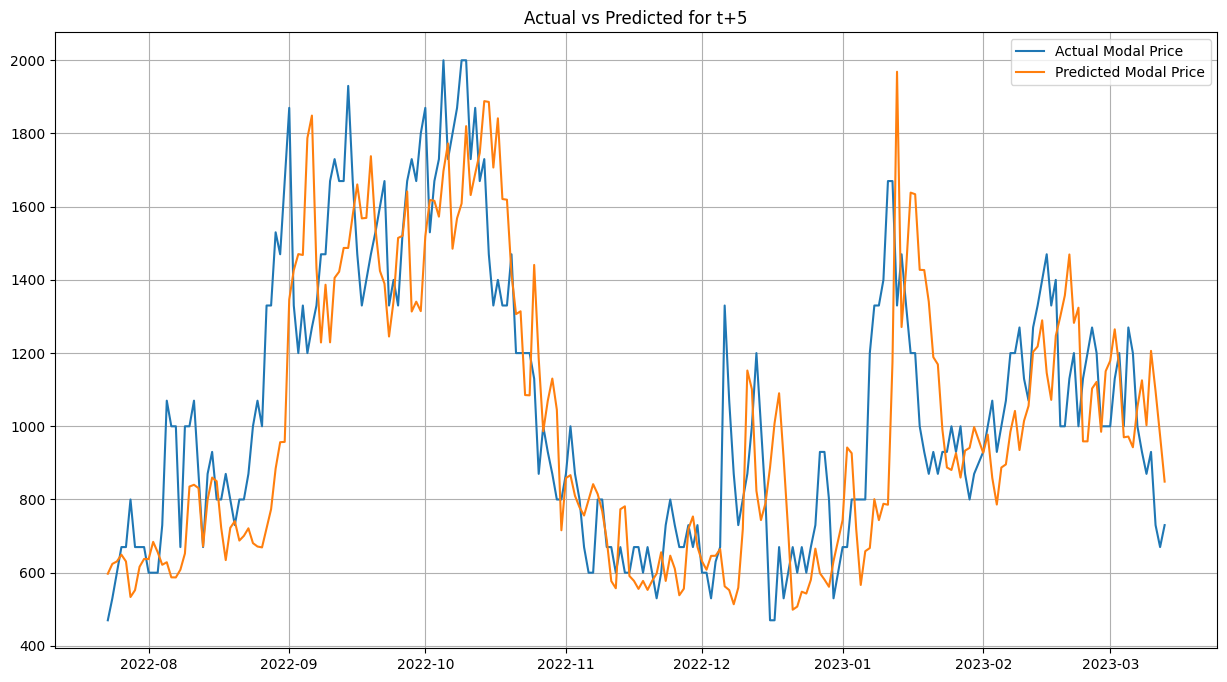

In [212]:
plt.plot(pred9_df['modal_price_actual_t5'], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t5'],  label='Predicted Modal Price')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

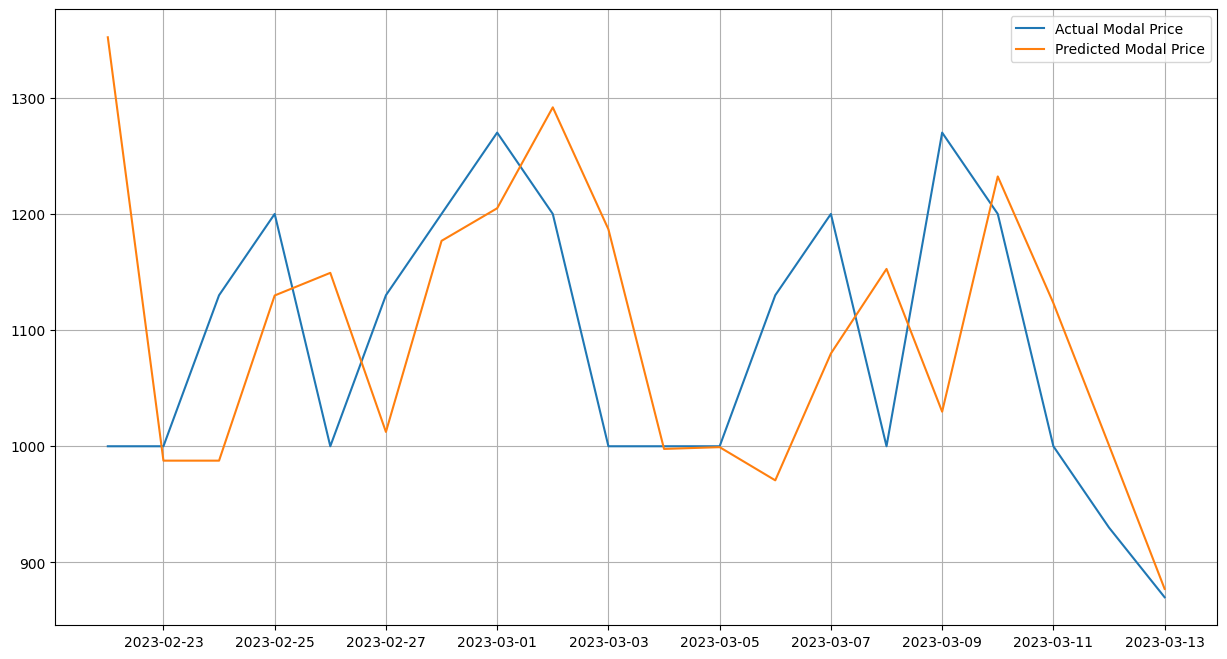

In [213]:
plt.plot(pred9_df['modal_price_actual_t1'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t1'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+1')
plt.show()

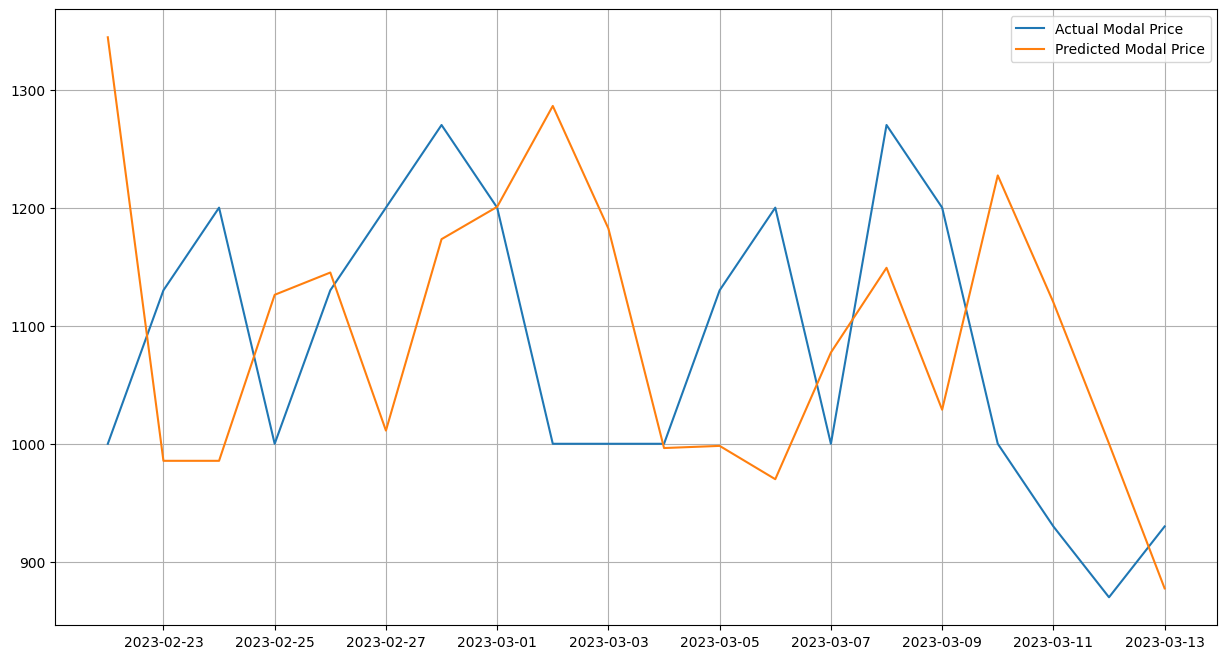

In [214]:
plt.plot(pred9_df['modal_price_actual_t2'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t2'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+2')
plt.show()

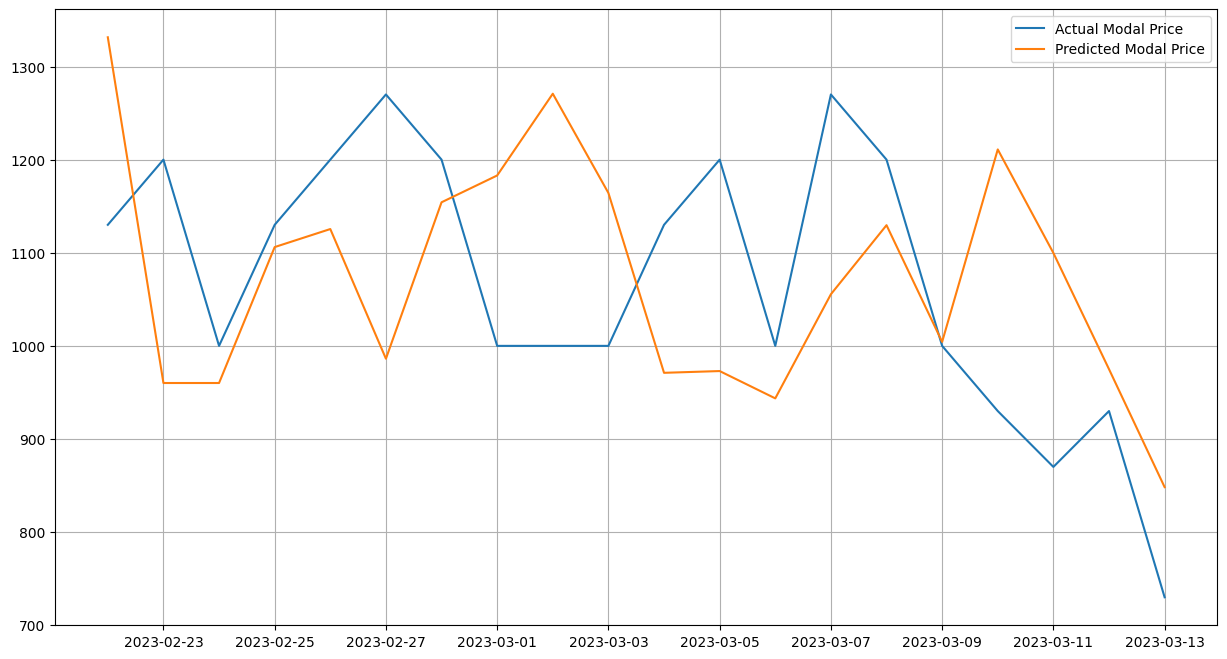

In [215]:
plt.plot(pred9_df['modal_price_actual_t3'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t3'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+3')
plt.show()

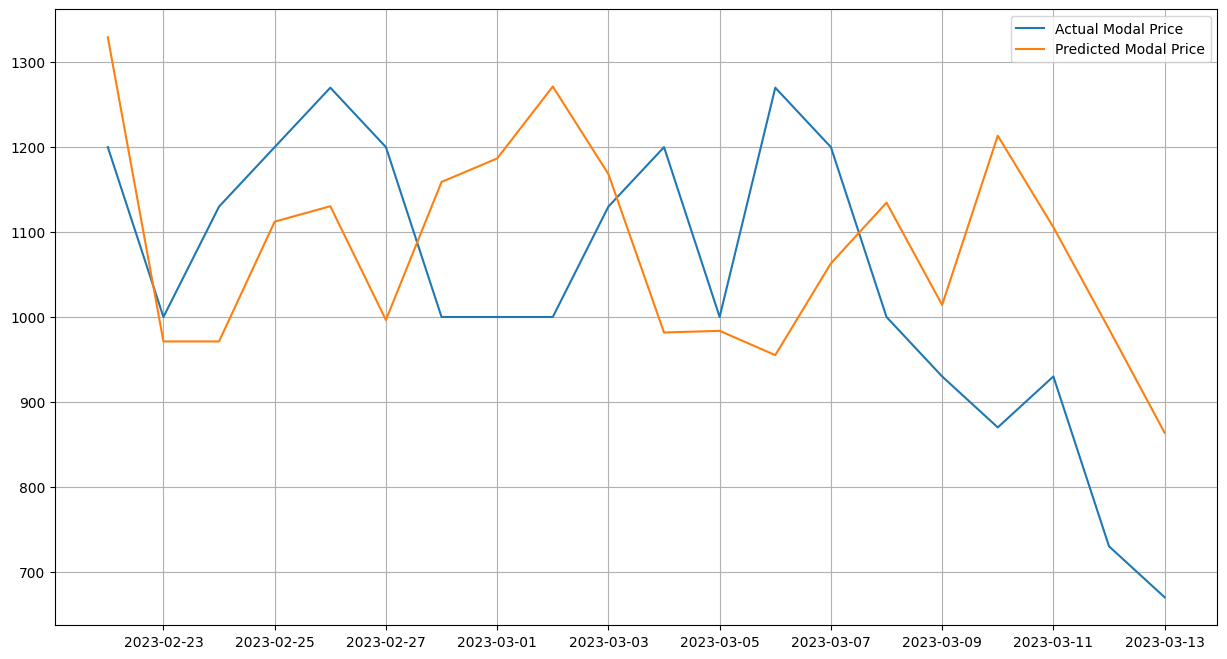

In [216]:
plt.plot(pred9_df['modal_price_actual_t4'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t4'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+4')
plt.show()

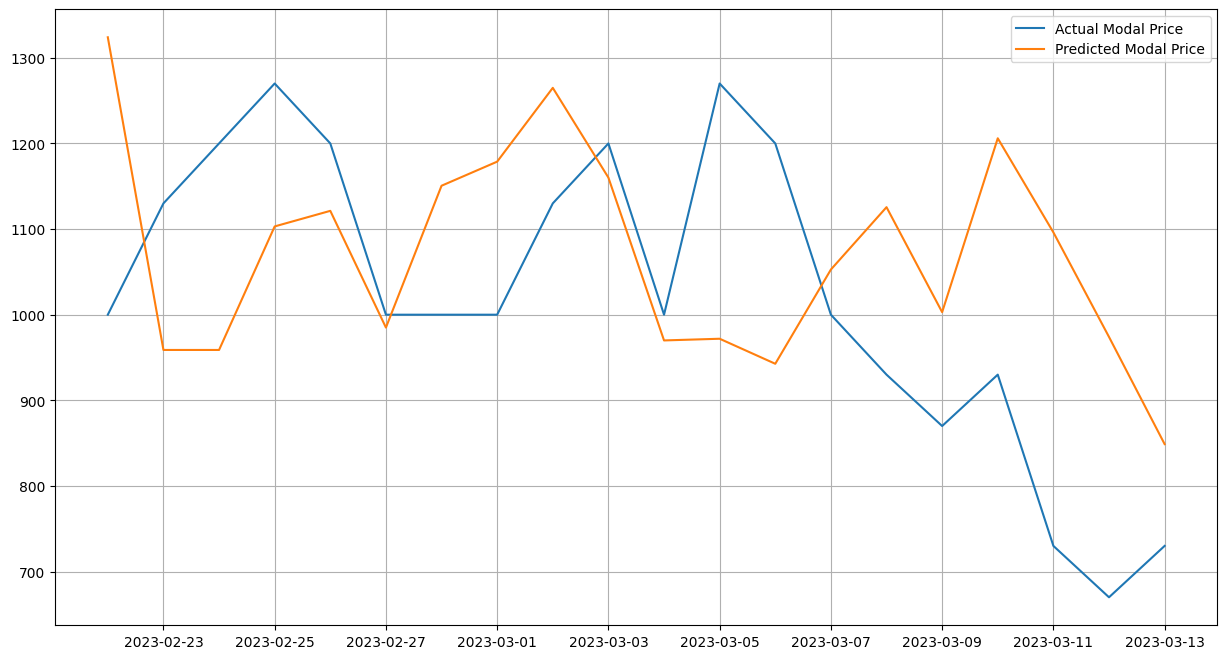

In [217]:
plt.plot(pred9_df['modal_price_actual_t5'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t5'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
#plt.title('Actual vs Predicted for t+5')
plt.show()

In [218]:
pred9_df.index[-10:-5]

DatetimeIndex(['2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08'],
              dtype='datetime64[ns]', name='arrival_date', freq=None)

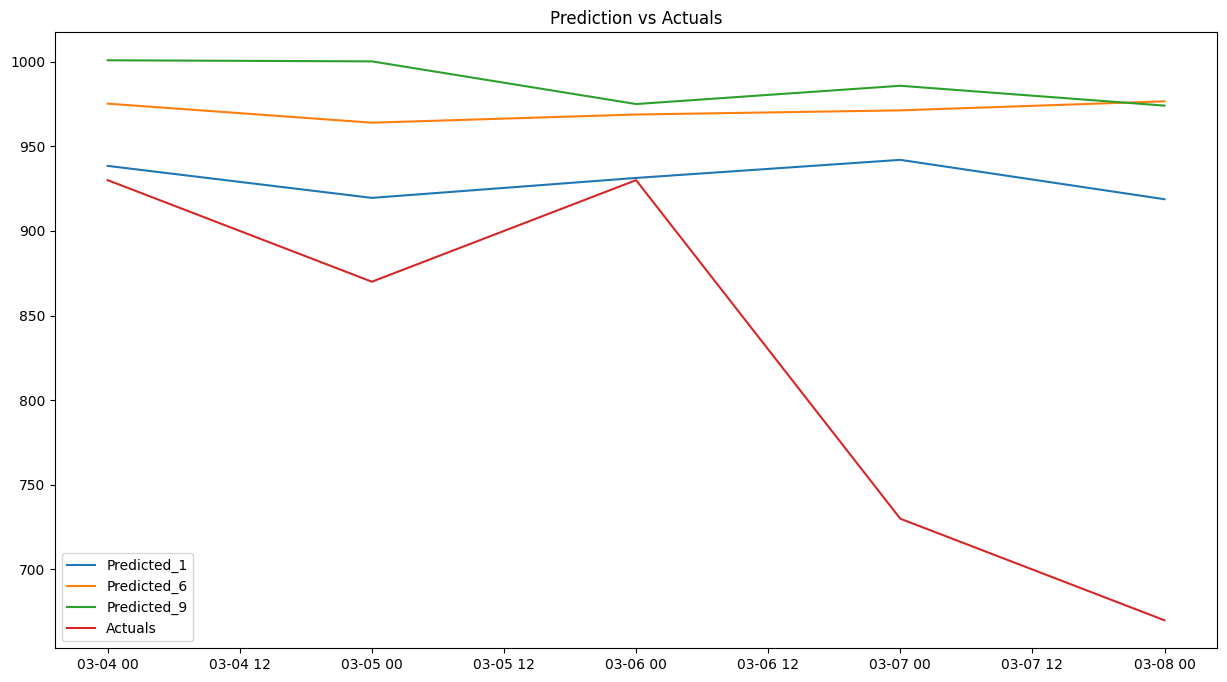

In [219]:
y_pred = inv_pred_y[-2:-1].reshape(inv_pred_y.shape[1])
y_pred_6 = inv_pred6_y[-2:-1].reshape(inv_pred6_y.shape[1])
y_pred_9 = inv_pred9_y[-2:-1].reshape(inv_pred9_y.shape[1])
y_actual = inv_test_y[-2:-1].reshape(inv_test_y.shape[1])
x = pred_df.index[-10:-5]
plt.plot(x, y_pred, label='Predicted_1')
plt.plot(x, y_pred_6, label='Predicted_6')
plt.plot(x, y_pred_9, label='Predicted_9')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.title('Prediction vs Actuals')
plt.show()

# Model 10 - Stacked Bi Directional LSTM (Hyperparameter tuning) - Decreasing the number of nodes in hidden layers.

## Model Building

In [220]:
# Build the Stacked Bi-Directional LSTM model
model_Stacked_biDir_h4 = Sequential()
model_Stacked_biDir_h4.add(Bidirectional(LSTM(4, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_h4.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_h4.add(Bidirectional(LSTM(4, activation='relu', return_sequences=True)))
model_Stacked_biDir_h4.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_h4.add(Bidirectional(LSTM(4, activation='relu')))
model_Stacked_biDir_h4.add(Dropout(0.2))
model_Stacked_biDir_h4.add(Dense(vec_train_y.shape[1], activation='relu'))
model_Stacked_biDir_h4.compile(optimizer='adam', loss='mae')

In [221]:
model_Stacked_biDir_h4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_12 (Bidirecti  (None, 1, 8)             288       
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 1, 8)              0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 1, 8)             416       
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 1, 8)              0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 8)                416       
 onal)                                                           
                                                      

In [222]:
# fit network
history_10 = model_Stacked_biDir_h4.fit(vec_train_X, vec_train_y, epochs=250, batch_size=75, 
                                    validation_data=(vec_test_X, vec_test_y),
                                    verbose=1,shuffle=False )

Epoch 1/250
13/13 [==============================] - 11s 90ms/step - loss: 0.1651 - val_loss: 0.1335
Epoch 2/250
13/13 [==============================] - 0s 12ms/step - loss: 0.1503 - val_loss: 0.1182
Epoch 3/250
13/13 [==============================] - 0s 11ms/step - loss: 0.1366 - val_loss: 0.1031
Epoch 4/250
13/13 [==============================] - 0s 12ms/step - loss: 0.1258 - val_loss: 0.0897
Epoch 5/250
13/13 [==============================] - 0s 12ms/step - loss: 0.1192 - val_loss: 0.0800
Epoch 6/250
13/13 [==============================] - 0s 11ms/step - loss: 0.1156 - val_loss: 0.0736
Epoch 7/250
13/13 [==============================] - 0s 12ms/step - loss: 0.1139 - val_loss: 0.0694
Epoch 8/250
13/13 [==============================] - 0s 11ms/step - loss: 0.1128 - val_loss: 0.0666
Epoch 9/250
13/13 [==============================] - 0s 13ms/step - loss: 0.1121 - val_loss: 0.0646
Epoch 10/250
13/13 [==============================] - 0s 10ms/step - loss: 0.1116 - val_loss: 0.063

In [223]:
# fit network
#history_6 = model_Stacked_biDir3.fit(vec_train_X, vec_train_y, initial_epoch=100, epochs=200,
#                                     batch_size=32, validation_data=(vec_test_X, vec_test_y), 
#                                    verbose=2, shuffle=False)

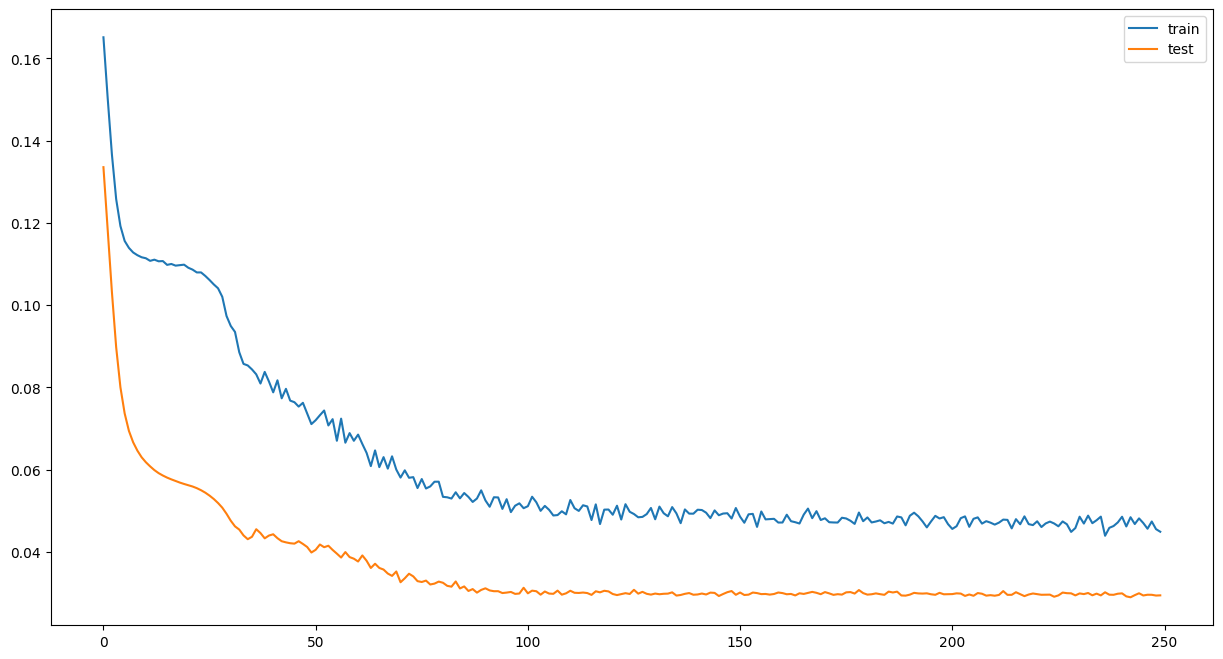

In [224]:
# plot history
plt.plot(history_10.history['loss'], label='train')
plt.plot(history_10.history['val_loss'], label='test')
plt.legend()
plt.show()

## Prediction

In [225]:
# make a prediction
pred10_y = model_Stacked_biDir_h4.predict(vec_test_X)

8/8 [==============================] - 1s 3ms/step


In [226]:
pred10_y[:5]

array([[0.06801292, 0.06710289, 0.0673819 , 0.06788856, 0.06822241],
       [0.0713619 , 0.07042199, 0.07078624, 0.07123722, 0.07162381],
       [0.0734911 , 0.07252954, 0.07295034, 0.0733644 , 0.0737763 ],
       [0.07558575, 0.0746062 , 0.07507432, 0.07545678, 0.07590476],
       [0.07236306, 0.07141461, 0.07180445, 0.07223783, 0.07264385]],
      dtype=float32)

In [227]:
pred10_y.shape

(232, 5)

## Rescaling Prediction

In [228]:
data_pred10 = test_data.copy()
for i in data_pred10.columns:
  if i.startswith('target'):
    data_pred10.drop(columns=i,inplace=True)

In [229]:
for i in range(0,5):
  data_pred10['prediction_t'+str(i+1)] = pred10_y[:,i]

In [230]:
data_pred10

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.068013   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.071362   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.073491   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.075586   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.072363   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.134087   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.169293   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.150002   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.128291   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.107134   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.067103       0.067382       0.067889       0.068222  
2022-07-24         0.070422       0.070786       0.071237       0.071624  
2022-07-25         0.072530       0.072950       0.073364       0.073776  
2022-07-26         0.074606       0.075074       0.075457       0.075905  
2022-07-27         0.071415       0.071804       0.072238       0.072644  
...                     ...            ...            ...            ...  
2023-03-09         0.132388       0.133807       0.134064       0.133891  
2023-03-10         0.167128       0.168839       0.168880       0.168609  
2023-03-11         0.148088       0.149724       0.149805       0.149616  
2023-03-12         0.126666       0.128017       0.128303       0.128158  
2023-03-13         0.105763       0.106830       0.107194       0.107158  

[232 rows x 9 columns]

In [231]:
inv_pred10_y = scaler.inverse_transform(data_pred10)
inv_pred10_y = inv_pred10_y[:,-5:]

In [232]:
inv_pred10_y[:2,]

array([[594.47495341, 589.19678628, 590.81504047, 593.75363588,
        595.68998367],
       [613.89901638, 608.44752043, 610.56017876, 613.17588389,
        615.41809589]])

## Comapring Actuals vs Predicted

In [233]:
pred10_df = pd.DataFrame(index=test_data.index)

In [234]:
for i in range(0,5):
  pred10_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred10_df['prediction_t'+str(i+1)] = inv_pred10_y[:,i]

In [235]:
pred10_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     594.474953                  670.0   
2022-07-24                    670.0     613.899016                  730.0   
2022-07-25                    730.0     626.248403                  730.0   
2022-07-26                    730.0     638.397366                  470.0   
2022-07-27                    470.0     619.705769                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0     977.705961                 1200.0   
2023-03-10                   1200.0    1181.897593                 1000.0   
2023-03-11                   1000.0    1070.009369                  930.0   
2023-03-12                    930.0     944.088554                  870.0   
2023-03-13                    870.0     821.375555                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       589.196786                  730.0     590.815040   
2022-07-24       608.447520                  730.0     610.560179   
2022-07-25       620.671329                  470.0     623.111977   
2022-07-26       632.715932                  530.0     635.431027   
2022-07-27       614.204751                  600.0     616.465804   
...                     ...                    ...            ...   
2023-03-09       967.852968                 1000.0     976.078632   
2023-03-10      1169.339702                  930.0    1179.265726   
2023-03-11      1058.913299                  870.0    1068.402091   
2023-03-12       934.662768                  930.0     942.496055   
2023-03-13       813.427536                  730.0     819.611153   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     593.753636                  470.0   
2022-07-24                    470.0     613.175884                  530.0   
2022-07-25                    530.0     625.513516                  600.0   
2022-07-26                    600.0     637.649299                  670.0   
2022-07-27                    670.0     618.979439                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0     977.571568                  870.0   
2023-03-10                    870.0    1179.502362                  930.0   
2023-03-11                    930.0    1068.866202                  730.0   
2023-03-12                    730.0     944.156140                  670.0   
2023-03-13                    670.0     821.727873                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       595.689984  
2022-07-24       615.418096  
2022-07-25       627.902567  
2022-07-26       640.247589  
2022-07-27       621.334352  
...                     ...  
2023-03-09       976.570660  
2023-03-10      1177.932507  
2023-03-11      1067.774287  
2023-03-12       943.314689  
2023-03-13       821.515566  

[232 rows x 10 columns]

In [236]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred10_y[:,0])

0.11599695385681433

In [237]:
# Calculate the error
error10 = pd.Series()
for i in range(0,5):
  error10['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred10_y[:,i])
print("Results of sklearn.metrics:")
print(error10)

Results of sklearn.metrics:
MAPE_1    0.115997
MAPE_2    0.151253
MAPE_3    0.172031
MAPE_4    0.181551
MAPE_5    0.191373
dtype: float64


In [238]:
model_comparision['Stacked_BiDir_LSTM_H4'] = error10
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  Stacked_BiDir_LSTM_H1  \
MAPE_1              0.109185              0.106879               0.107716   
MAPE_2              0.146995              0.149848               0.147669   
MAPE_3              0.168869              0.177406               0.173840   
MAPE_4              0.179073              0.193330               0.189186   
MAPE_5              0.188950              0.206578               0.201251   

        Stacked_BiDir_LSTM_H2  Stacked_BiDir_LSTM_H3  Stacked_BiDir_LSTM_H4  
MAPE_1               0.106129               0.107621               0.115997  
MAPE_2               0.146629               0.147887               0.151253  
MAPE_3               0.171409               0.174011               0.172031  
MAPE_4               0.184121               0.183825               0.181551  
MAPE_5               0.194481               0.194072               0.191373

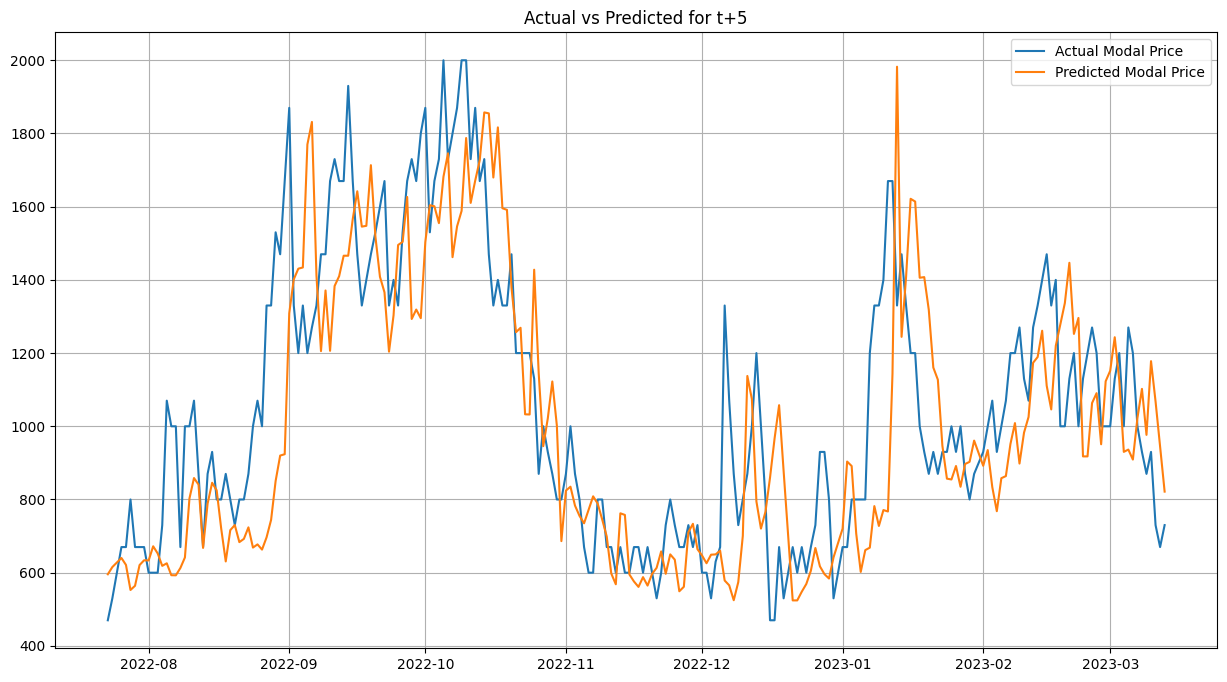

In [239]:
plt.plot(pred10_df['modal_price_actual_t5'], label='Actual Modal Price')
plt.plot(pred10_df['prediction_t5'],  label='Predicted Modal Price')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

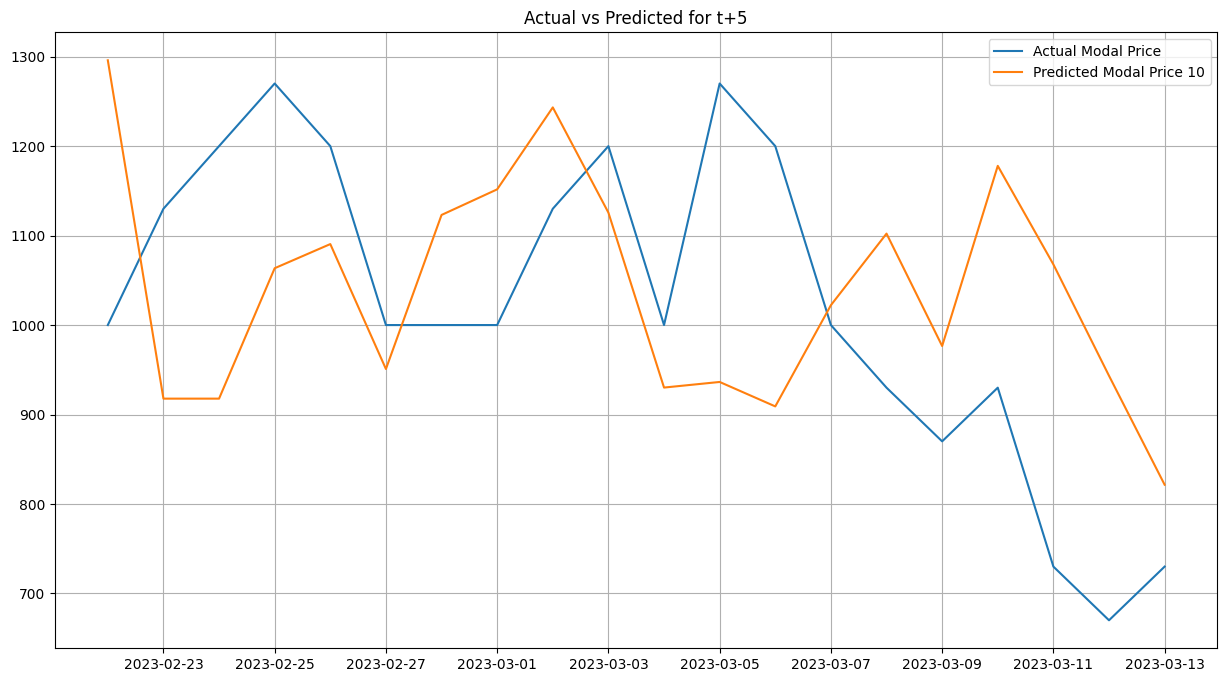

In [240]:
plt.plot(pred10_df['modal_price_actual_t5'][-20:], label='Actual Modal Price')
plt.plot(pred10_df['prediction_t5'][-20:],  label='Predicted Modal Price 10')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

In [241]:
pred10_df.index[-10:-5]

DatetimeIndex(['2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08'],
              dtype='datetime64[ns]', name='arrival_date', freq=None)

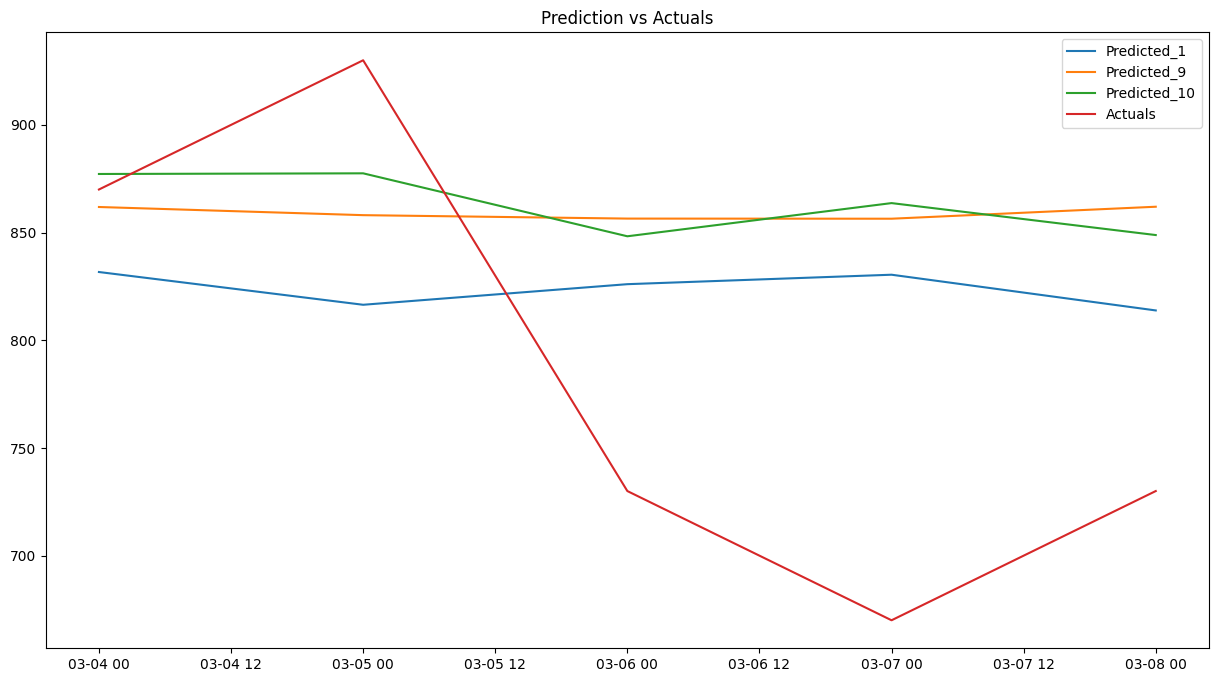

In [242]:
y_pred_1 = inv_pred_y[-1].reshape(inv_pred_y.shape[1])
y_pred_9 = inv_pred8_y[-1].reshape(inv_pred9_y.shape[1])
y_pred_10 = inv_pred9_y[-1].reshape(inv_pred10_y.shape[1])
y_actual = inv_test_y[-1].reshape(inv_test_y.shape[1])
x = pred10_df.index[-10:-5]
plt.plot(x, y_pred_1, label='Predicted_1')
plt.plot(x, y_pred_9, label='Predicted_9')
plt.plot(x, y_pred_10, label='Predicted_10')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.title('Prediction vs Actuals')
plt.show()

# Model 11 - Stacked Bi Directional LSTM Parallel Model

In [243]:
# Verifying the shape of train and test
print(vec_train_X.shape, vec_train_y.shape, vec_test_X.shape, vec_test_y.shape)

(926, 1, 4) (926, 5) (232, 1, 4) (232, 5)


## Preparing Target Features

In [244]:
# Traget variable t+1
vec_train_y1 = vec_train_y[:,0].reshape((int(train_X.shape[0]), 1))
vec_test_y1 = vec_test_y[:,0].reshape((int(test_X.shape[0]), 1))
# Traget variable t+2
vec_train_y2 = vec_train_y[:,1].reshape((int(train_X.shape[0]), 1))
vec_test_y2 = vec_test_y[:,1].reshape((int(test_X.shape[0]), 1))
# Traget variable t+2
vec_train_y3 = vec_train_y[:,2].reshape((int(train_X.shape[0]), 1))
vec_test_y3 = vec_test_y[:,2].reshape((int(test_X.shape[0]), 1))
# Traget variable t+2
vec_train_y4 = vec_train_y[:,3].reshape((int(train_X.shape[0]), 1))
vec_test_y4 = vec_test_y[:,3].reshape((int(test_X.shape[0]), 1))
# Traget variable t+1
vec_train_y5 = vec_train_y[:,4].reshape((int(train_X.shape[0]), 1))
vec_test_y5 = vec_test_y[:,4].reshape((int(test_X.shape[0]), 1))

In [245]:
print(vec_train_X.shape, vec_train_y1.shape, vec_train_y2.shape, vec_train_y3.shape, vec_train_y4.shape, vec_train_y5.shape)
print(vec_test_X.shape, vec_test_y1.shape, vec_test_y2.shape, vec_test_y3.shape, vec_test_y4.shape, vec_test_y5.shape)

(926, 1, 4) (926, 1) (926, 1) (926, 1) (926, 1) (926, 1)
(232, 1, 4) (232, 1) (232, 1) (232, 1) (232, 1) (232, 1)


## Model Building and Prediction t+1

In [246]:
model_Stacked_biDir_p1A = Sequential()
model_Stacked_biDir_p1A.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_p1A.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1A.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_p1A.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1A.add(Dense(vec_train_y1.shape[1], activation='relu'))
model_Stacked_biDir_p1A.compile(optimizer='adam', loss='mae')

In [247]:
model_Stacked_biDir_p1A.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_15 (Bidirecti  (None, 1, 16)            832       
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 1, 16)             0         
                                                                 
 bidirectional_16 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,449
Trainable params: 2,449
Non-train

In [248]:
# fit network for Prediction 1
history_p1A = model_Stacked_biDir_p1A.fit(vec_train_X, vec_train_y1, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y1),
                                    verbose=0,shuffle=False )

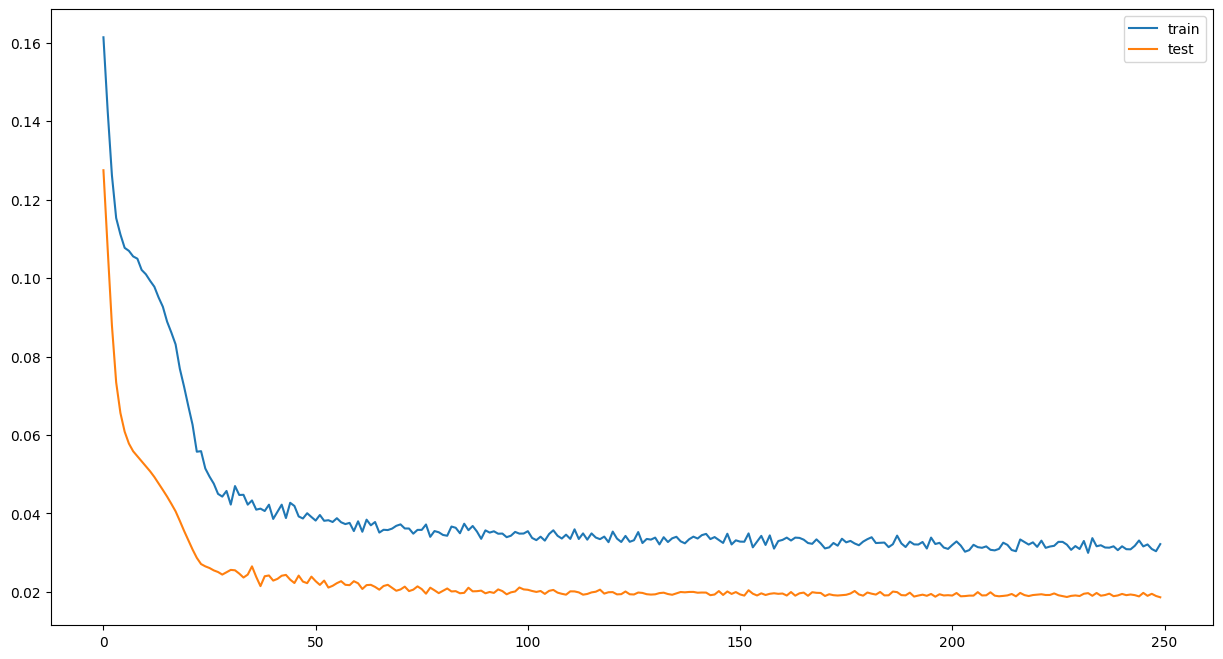

In [249]:
# plot history
plt.plot(history_p1A.history['loss'], label='train')
plt.plot(history_p1A.history['val_loss'], label='test')
plt.legend()
plt.show()

In [250]:
# make a prediction
pred_p1A_y = model_Stacked_biDir_p1A.predict(vec_test_X)

8/8 [==============================] - 1s 2ms/step


In [251]:
pred_p1A_y[:5]

array([[0.07777435],
       [0.08448447],
       [0.0816405 ],
       [0.08782868],
       [0.08249396]], dtype=float32)

In [252]:
pred_p1A_y.shape

(232, 1)

## Model Building and Prediction t+2

In [253]:
model_Stacked_biDir_p1B = Sequential()
model_Stacked_biDir_p1B.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_p1B.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1B.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_p1B.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1B.add(Dense(vec_train_y2.shape[1], activation='relu'))
model_Stacked_biDir_p1B.compile(optimizer='adam', loss='mae')

In [254]:
model_Stacked_biDir_p1B.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_17 (Bidirecti  (None, 1, 16)            832       
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 1, 16)             0         
                                                                 
 bidirectional_18 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,449
Trainable params: 2,449
Non-train

In [255]:
# fit network for Prediction 1
history_p1B = model_Stacked_biDir_p1B.fit(vec_train_X, vec_train_y2, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y2),
                                    verbose=0,shuffle=False )

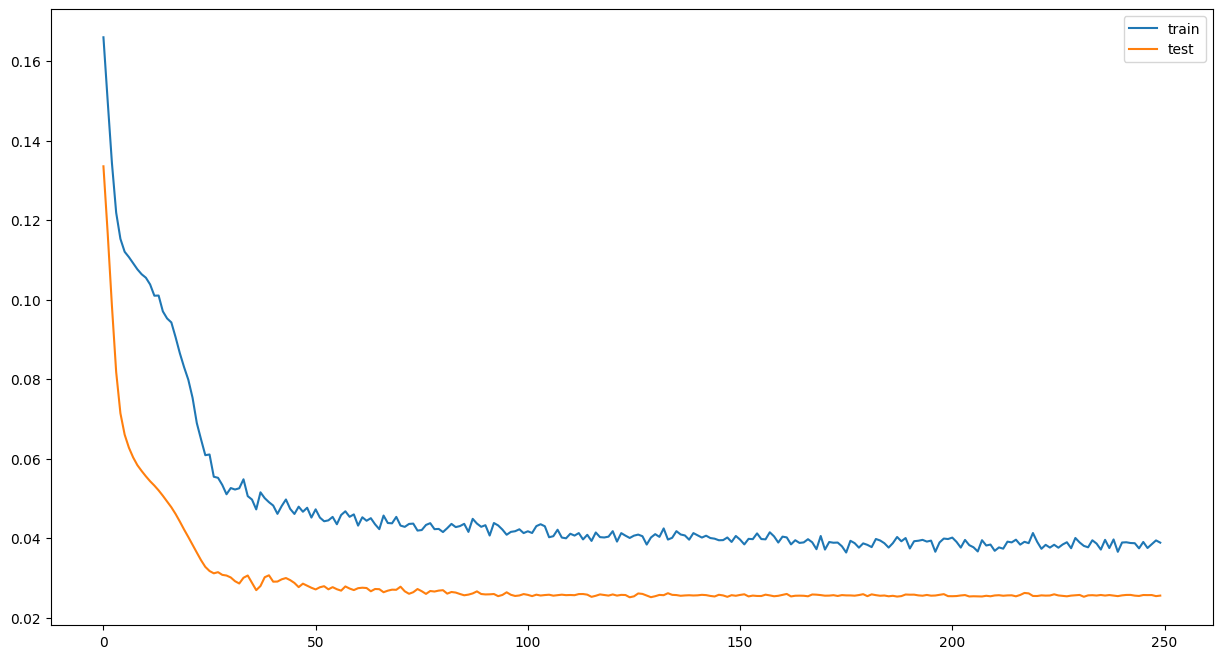

In [256]:
# plot history
plt.plot(history_p1B.history['loss'], label='train')
plt.plot(history_p1B.history['val_loss'], label='test')
plt.legend()
plt.show()

In [257]:
# make a prediction
pred_p1B_y = model_Stacked_biDir_p1B.predict(vec_test_X)

8/8 [==============================] - 1s 4ms/step


In [258]:
pred_p1B_y[:5]

array([[0.06936731],
       [0.07649048],
       [0.07678238],
       [0.0811637 ],
       [0.07765719]], dtype=float32)

In [259]:
pred_p1B_y.shape

(232, 1)

## Model Building and Prediction t+3

In [260]:
model_Stacked_biDir_p1C = Sequential()
model_Stacked_biDir_p1C.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_p1C.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1C.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_p1C.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1C.add(Dense(vec_train_y3.shape[1], activation='relu'))
model_Stacked_biDir_p1C.compile(optimizer='adam', loss='mae')

In [261]:
model_Stacked_biDir_p1C.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_19 (Bidirecti  (None, 1, 16)            832       
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 1, 16)             0         
                                                                 
 bidirectional_20 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 16)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,449
Trainable params: 2,449
Non-train

In [262]:
# fit network for Prediction 1
history_p1C = model_Stacked_biDir_p1C.fit(vec_train_X, vec_train_y3, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y3),
                                    verbose=0,shuffle=False )

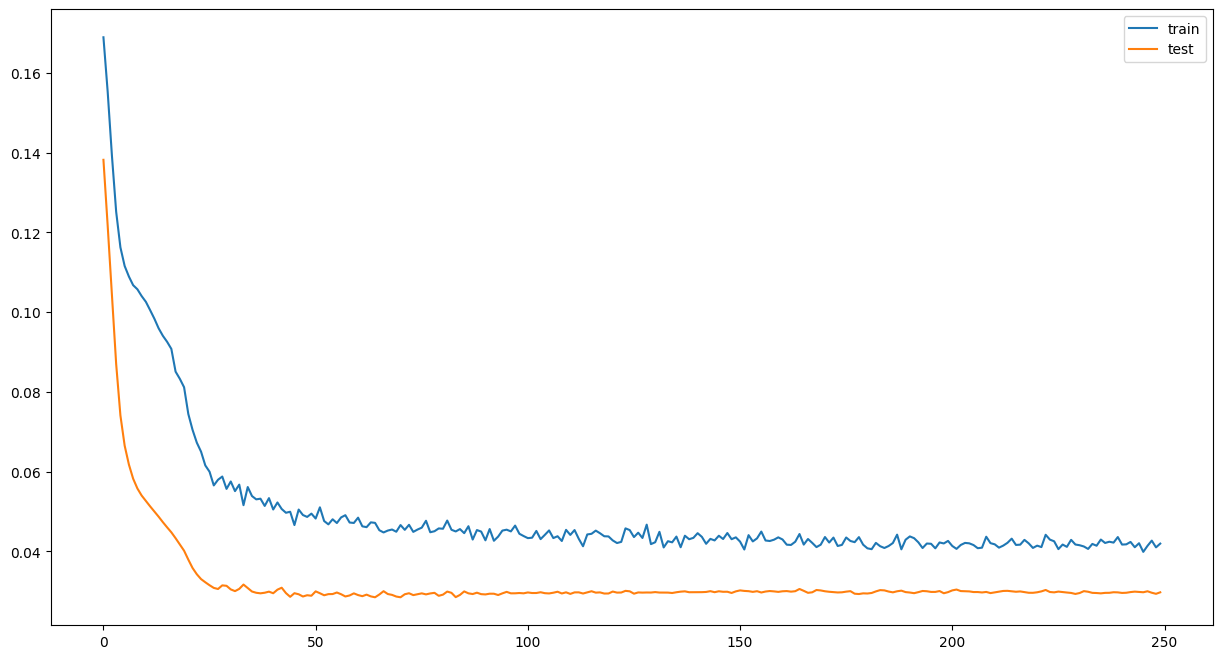

In [263]:
# plot history
plt.plot(history_p1C.history['loss'], label='train')
plt.plot(history_p1C.history['val_loss'], label='test')
plt.legend()
plt.show()

In [264]:
# make a prediction
pred_p1C_y = model_Stacked_biDir_p1C.predict(vec_test_X)

8/8 [==============================] - 1s 4ms/step


In [265]:
pred_p1C_y[:5]

array([[0.07410088],
       [0.07912339],
       [0.08043592],
       [0.08419612],
       [0.08006746]], dtype=float32)

In [266]:
pred_p1C_y.shape

(232, 1)

## Model Building and Prediction t+4

In [267]:
model_Stacked_biDir_p1D = Sequential()
model_Stacked_biDir_p1D.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_p1D.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1D.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_p1D.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1D.add(Dense(vec_train_y4.shape[1], activation='relu'))
model_Stacked_biDir_p1D.compile(optimizer='adam', loss='mae')

In [268]:
model_Stacked_biDir_p1D.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_21 (Bidirecti  (None, 1, 16)            832       
 onal)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 1, 16)             0         
                                                                 
 bidirectional_22 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,449
Trainable params: 2,449
Non-train

In [269]:
# fit network for Prediction 1
history_p1D = model_Stacked_biDir_p1D.fit(vec_train_X, vec_train_y4, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y4),
                                    verbose=0,shuffle=False )

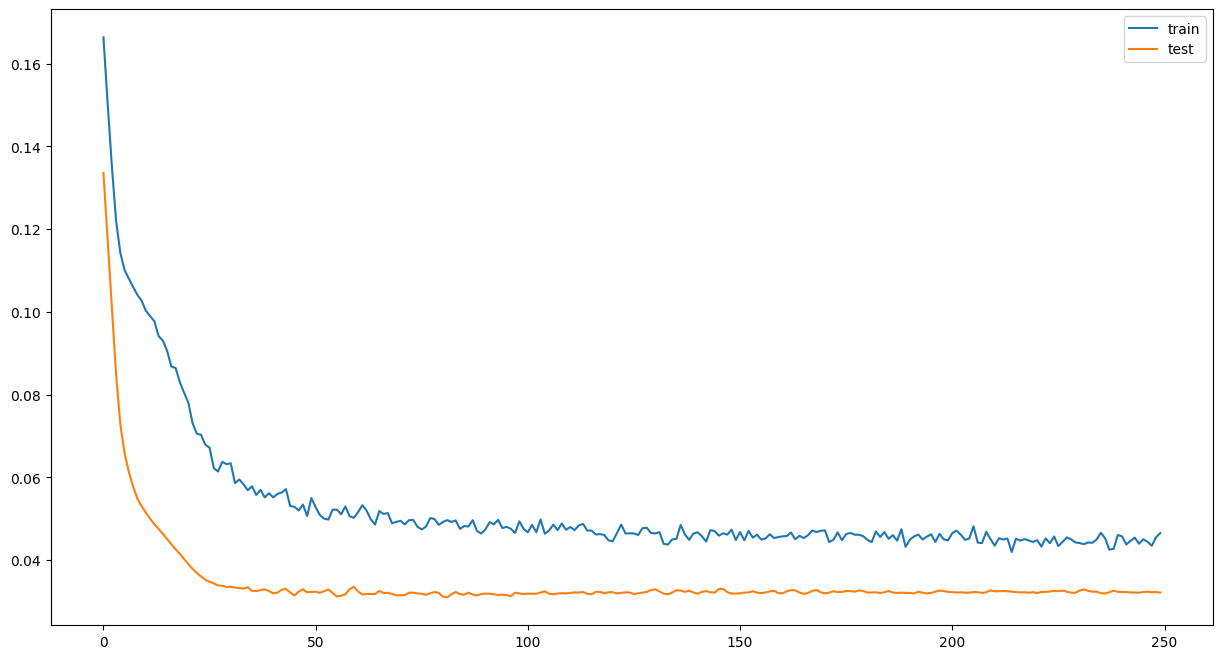

In [270]:
# plot history
plt.plot(history_p1D.history['loss'], label='train')
plt.plot(history_p1D.history['val_loss'], label='test')
plt.legend()
plt.show()

In [271]:
# make a prediction
pred_p1D_y = model_Stacked_biDir_p1D.predict(vec_test_X)

8/8 [==============================] - 1s 4ms/step


In [272]:
pred_p1D_y[:5]

array([[0.0673012 ],
       [0.0712781 ],
       [0.07496901],
       [0.0772258 ],
       [0.07390345]], dtype=float32)

In [273]:
pred_p1D_y.shape

(232, 1)

## Model Building and Prediction t+5

In [274]:
model_Stacked_biDir_p1E = Sequential()
model_Stacked_biDir_p1E.add(Bidirectional(LSTM(8, activation='relu', return_sequences=True),
                                      input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
model_Stacked_biDir_p1E.add(Dropout(0.2, input_shape=(vec_train_X.shape[1], vec_train_X.shape[2])))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1E.add(Bidirectional(LSTM(8, activation='relu')))
model_Stacked_biDir_p1E.add(Dropout(0.2))
#model_Stacked_biDir_h2.add(BatchNormalization())
model_Stacked_biDir_p1E.add(Dense(vec_train_y5.shape[1], activation='relu'))
model_Stacked_biDir_p1E.compile(optimizer='adam', loss='mae')

In [275]:
model_Stacked_biDir_p1E.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_23 (Bidirecti  (None, 1, 16)            832       
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 1, 16)             0         
                                                                 
 bidirectional_24 (Bidirecti  (None, 16)               1600      
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,449
Trainable params: 2,449
Non-train

In [276]:
# fit network for Prediction 1
history_p1E = model_Stacked_biDir_p1E.fit(vec_train_X, vec_train_y5, epochs=250, batch_size=100, 
                                    validation_data=(vec_test_X, vec_test_y5),
                                    verbose=0,shuffle=False )

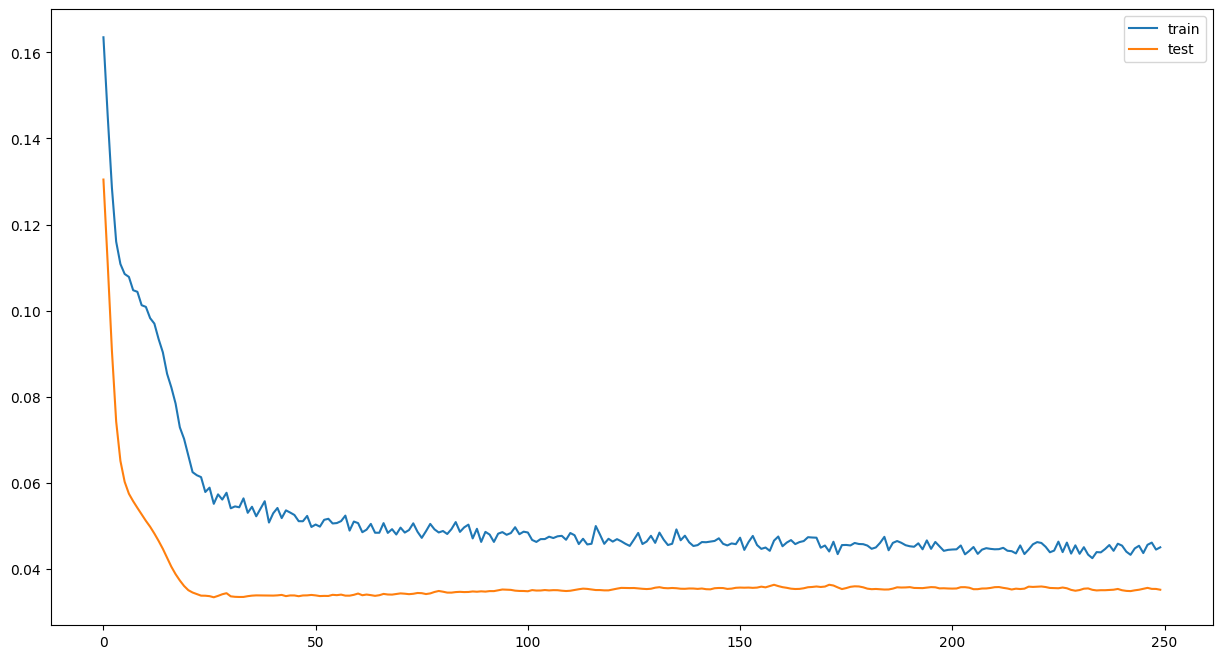

In [277]:
# plot history
plt.plot(history_p1E.history['loss'], label='train')
plt.plot(history_p1E.history['val_loss'], label='test')
plt.legend()
plt.show()

In [278]:
# make a prediction
pred_p1E_y = model_Stacked_biDir_p1E.predict(vec_test_X)

8/8 [==============================] - 1s 3ms/step


In [279]:
pred_p1E_y[:5]

array([[0.07030817],
       [0.07294164],
       [0.07441379],
       [0.07678268],
       [0.07409454]], dtype=float32)

In [280]:
pred_p1E_y.shape

(232, 1)

## Rescaling Prediction

In [281]:
data_pred11 = test_data.copy()
for i in data_pred11.columns:
  if i.startswith('target'):
    data_pred11.drop(columns=i,inplace=True)

In [282]:
data_pred11['prediction_t1'] = pred_p1A_y
data_pred11['prediction_t2'] = pred_p1B_y
data_pred11['prediction_t3'] = pred_p1C_y
data_pred11['prediction_t4'] = pred_p1D_y
data_pred11['prediction_t5'] = pred_p1E_y

In [283]:
data_pred11

quantity  min_price  max_price  modal_price  prediction_t1  \
arrival_date                                                               
2022-07-23    0.875515   0.067344   0.072551     0.081034       0.077774   
2022-07-24    0.864548   0.067344   0.081016     0.091379       0.084484   
2022-07-25    0.804913   0.067344   0.105200     0.081034       0.081641   
2022-07-26    0.854483   0.067344   0.105200     0.091379       0.087829   
2022-07-27    0.798577   0.059720   0.096735     0.091379       0.082494   
...                ...        ...        ...          ...            ...   
2023-03-09    0.045354   0.085133   0.169287     0.137931       0.142106   
2023-03-10    0.060756   0.118170   0.193470     0.184483       0.177968   
2023-03-11    0.065435   0.085133   0.177751     0.172414       0.158322   
2023-03-12    0.047206   0.085133   0.153567     0.137931       0.138076   
2023-03-13    0.064948   0.067344   0.124547     0.125862       0.117613   

              prediction_t2  prediction_t3  prediction_t4  prediction_t5  
arrival_date                                                              
2022-07-23         0.069367       0.074101       0.067301       0.070308  
2022-07-24         0.076490       0.079123       0.071278       0.072942  
2022-07-25         0.076782       0.080436       0.074969       0.074414  
2022-07-26         0.081164       0.084196       0.077226       0.076783  
2022-07-27         0.077657       0.080067       0.073903       0.074095  
...                     ...            ...            ...            ...  
2023-03-09         0.139109       0.146553       0.143002       0.144977  
2023-03-10         0.174322       0.187486       0.180139       0.184355  
2023-03-11         0.156755       0.166446       0.158513       0.166493  
2023-03-12         0.135092       0.139826       0.136118       0.137114  
2023-03-13         0.117263       0.116278       0.113053       0.112626  

[232 rows x 9 columns]

In [284]:
inv_pred11_y = scaler.inverse_transform(data_pred11)
inv_pred11_y = inv_pred11_y[:,-5:]

In [285]:
inv_pred11_y[:2,]

array([[651.09120607, 602.33040899, 629.78511453, 590.34695327,
        607.78739303],
       [690.00994265, 643.64476502, 658.91563445, 613.41295242,
        623.06150347]])

## Comapring Actuals vs Predicted

In [286]:
pred11_df = pd.DataFrame(index=test_data.index)

In [287]:
for i in range(0,5):
  pred11_df['modal_price_actual_t'+str(i+1)] = inv_test_y[:,i]
  pred11_df['prediction_t'+str(i+1)] = inv_pred11_y[:,i]

In [288]:
pred11_df

modal_price_actual_t1  prediction_t1  modal_price_actual_t2  \
arrival_date                                                                
2022-07-23                    730.0     651.091206                  670.0   
2022-07-24                    670.0     690.009943                  730.0   
2022-07-25                    730.0     673.514925                  730.0   
2022-07-26                    730.0     709.406349                  470.0   
2022-07-27                    470.0     678.464973                  530.0   
...                             ...            ...                    ...   
2023-03-09                   1270.0    1024.213484                 1200.0   
2023-03-10                   1200.0    1232.216880                 1000.0   
2023-03-11                   1000.0    1118.266168                  930.0   
2023-03-12                    930.0    1000.841016                  870.0   
2023-03-13                    870.0     882.152563                  930.0   

              prediction_t2  modal_price_actual_t3  prediction_t3  \
arrival_date                                                        
2022-07-23       602.330409                  730.0     629.785115   
2022-07-24       643.644765                  730.0     658.915634   
2022-07-25       645.337778                  470.0     666.528317   
2022-07-26       670.749442                  530.0     688.337499   
2022-07-27       650.411719                  600.0     664.391287   
...                     ...                    ...            ...   
2023-03-09      1006.830388                 1000.0    1050.006765   
2023-03-10      1211.064887                  930.0    1287.416425   
2023-03-11      1109.179348                  870.0    1165.389222   
2023-03-12       983.535445                  930.0    1010.992008   
2023-03-13       880.125554                  730.0     874.411623   

              modal_price_actual_t4  prediction_t4  modal_price_actual_t5  \
arrival_date                                                                
2022-07-23                    730.0     590.346953                  470.0   
2022-07-24                    470.0     613.412952                  530.0   
2022-07-25                    530.0     634.820250                  600.0   
2022-07-26                    600.0     647.909665                  670.0   
2022-07-27                    670.0     628.640004                  670.0   
...                             ...            ...                    ...   
2023-03-09                    930.0    1029.413348                  870.0   
2023-03-10                    870.0    1244.804329                  930.0   
2023-03-11                    930.0    1119.374764                  730.0   
2023-03-12                    730.0     989.483333                  670.0   
2023-03-13                    670.0     855.706760                  730.0   

              prediction_t5  
arrival_date                 
2022-07-23       607.787393  
2022-07-24       623.061503  
2022-07-25       631.599990  
2022-07-26       645.339550  
2022-07-27       629.748340  
...                     ...  
2023-03-09      1040.866274  
2023-03-10      1269.260848  
2023-03-11      1165.658787  
2023-03-12       995.262516  
2023-03-13       853.232147  

[232 rows x 10 columns]

In [289]:
mean_absolute_percentage_error(inv_test_y[:,0],inv_pred11_y[:,0])

0.10435579678756256

In [290]:
# Calculate the error
error11 = pd.Series()
for i in range(0,5):
  error11['MAPE_'+str(i+1)] = mean_absolute_percentage_error(inv_test_y[:,i],inv_pred11_y[:,i])
print("Results of sklearn.metrics:")
print(error11)

Results of sklearn.metrics:
MAPE_1    0.104356
MAPE_2    0.145196
MAPE_3    0.174377
MAPE_4    0.183794
MAPE_5    0.200141
dtype: float64


In [291]:
model_comparision['Stacked_BiDir_LSTM_P1'] = error11
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  Stacked_BiDir_LSTM_H1  \
MAPE_1              0.109185              0.106879               0.107716   
MAPE_2              0.146995              0.149848               0.147669   
MAPE_3              0.168869              0.177406               0.173840   
MAPE_4              0.179073              0.193330               0.189186   
MAPE_5              0.188950              0.206578               0.201251   

        Stacked_BiDir_LSTM_H2  Stacked_BiDir_LSTM_H3  Stacked_BiDir_LSTM_H4  \
MAPE_1               0.106129               0.107621               0.115997   
MAPE_2               0.146629               0.147887               0.151253   
MAPE_3               0.171409               0.174011               0.172031   
MAPE_4               0.184121               0.183825               0.181551   
MAPE_5               0.194481               0.194072               0.191373   

        Stacked_BiDir_LSTM_P1  
MAPE_1               0.104356  
MAPE_2               0.145196  
MAPE_3               0.174377  
MAPE_4               0.183794  
MAPE_5               0.200141

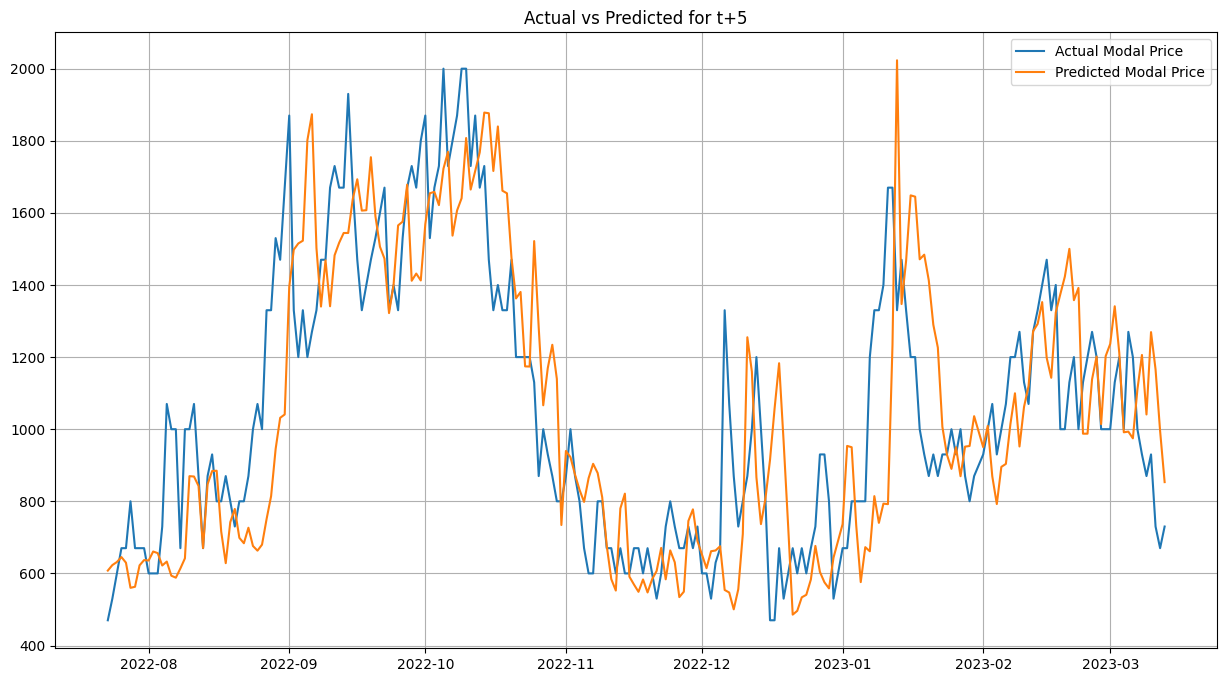

In [292]:
plt.plot(pred11_df['modal_price_actual_t5'], label='Actual Modal Price')
plt.plot(pred11_df['prediction_t5'],  label='Predicted Modal Price')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

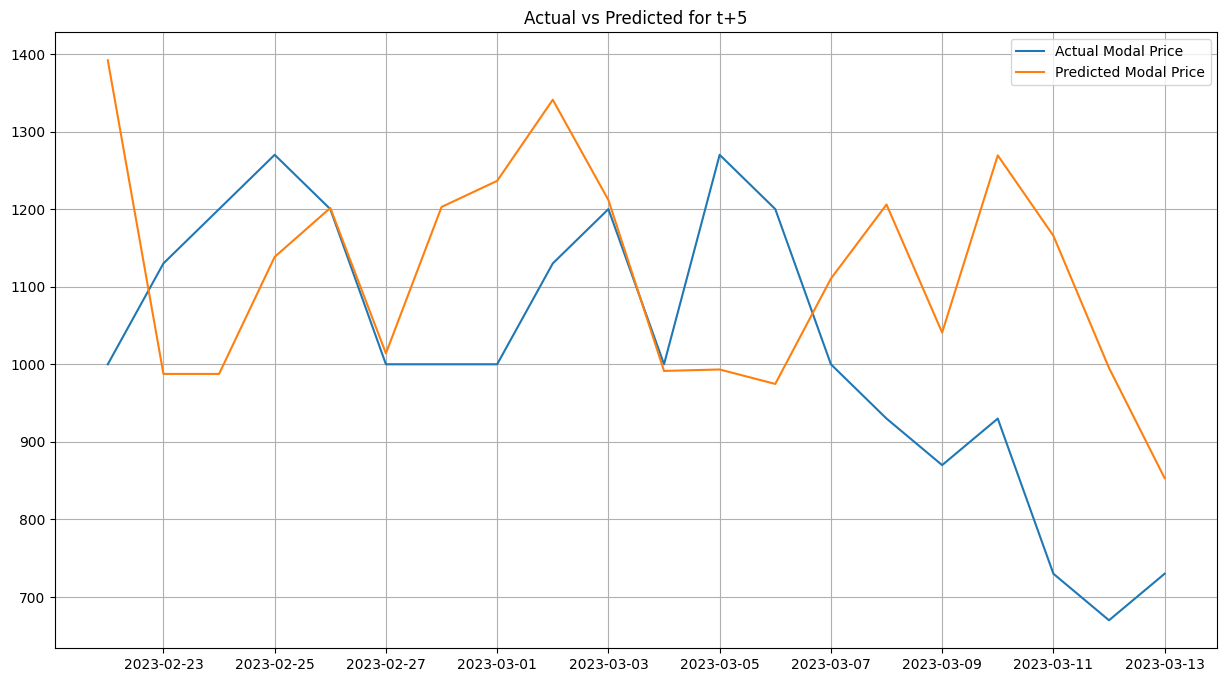

In [293]:
plt.plot(pred11_df['modal_price_actual_t5'][-20:], label='Actual Modal Price')
plt.plot(pred11_df['prediction_t5'][-20:],  label='Predicted Modal Price')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+5')
plt.show()

In [294]:
pred11_df.index[-10:-5]

DatetimeIndex(['2023-03-04', '2023-03-05', '2023-03-06', '2023-03-07',
               '2023-03-08'],
              dtype='datetime64[ns]', name='arrival_date', freq=None)

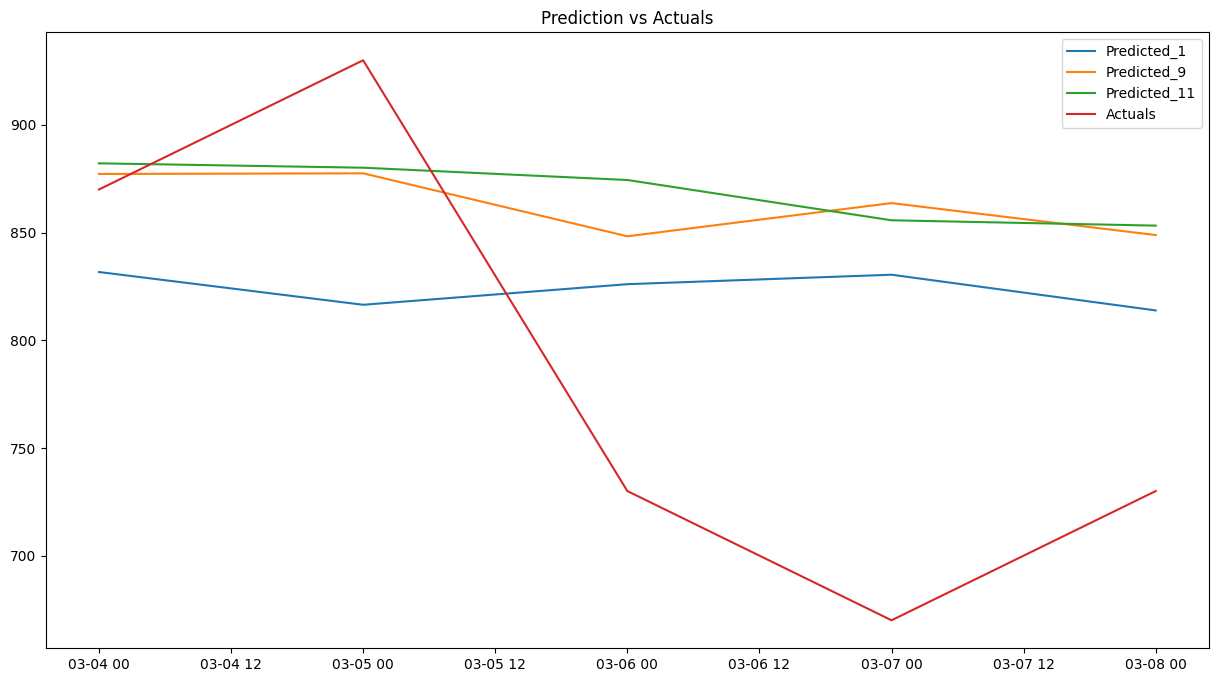

In [295]:
y_pred_1 = inv_pred_y[-1].reshape(inv_pred_y.shape[1])
y_pred_9 = inv_pred9_y[-1].reshape(inv_pred9_y.shape[1])
y_pred_11 = inv_pred11_y[-1].reshape(inv_pred11_y.shape[1])
y_actual = inv_test_y[-1].reshape(inv_test_y.shape[1])
x = pred11_df.index[-10:-5]
plt.plot(x, y_pred_1, label='Predicted_1')
plt.plot(x, y_pred_9, label='Predicted_9')
plt.plot(x, y_pred_11, label='Predicted_11')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.title('Prediction vs Actuals')
plt.show()

# Comparing all models


In [296]:
model_comparision

LSTM  Stacked_LSTM  BiDir_LSTM  Stacked_BiDir_LSTM  \
MAPE_1  0.107036      0.108226    0.107729            0.110836   
MAPE_2  0.144214      0.145803    0.146773            0.149013   
MAPE_3  0.165055      0.166310    0.165301            0.169834   
MAPE_4  0.177170      0.178558    0.178150            0.182323   
MAPE_5  0.186863      0.187744    0.187349            0.192973   

        Stacked_BiDir_LSTM_2  Stacked_BiDir_LSTM_3  Stacked_BiDir_LSTM_H1  \
MAPE_1              0.109185              0.106879               0.107716   
MAPE_2              0.146995              0.149848               0.147669   
MAPE_3              0.168869              0.177406               0.173840   
MAPE_4              0.179073              0.193330               0.189186   
MAPE_5              0.188950              0.206578               0.201251   

        Stacked_BiDir_LSTM_H2  Stacked_BiDir_LSTM_H3  Stacked_BiDir_LSTM_H4  \
MAPE_1               0.106129               0.107621               0.115997   
MAPE_2               0.146629               0.147887               0.151253   
MAPE_3               0.171409               0.174011               0.172031   
MAPE_4               0.184121               0.183825               0.181551   
MAPE_5               0.194481               0.194072               0.191373   

        Stacked_BiDir_LSTM_P1  
MAPE_1               0.104356  
MAPE_2               0.145196  
MAPE_3               0.174377  
MAPE_4               0.183794  
MAPE_5               0.200141

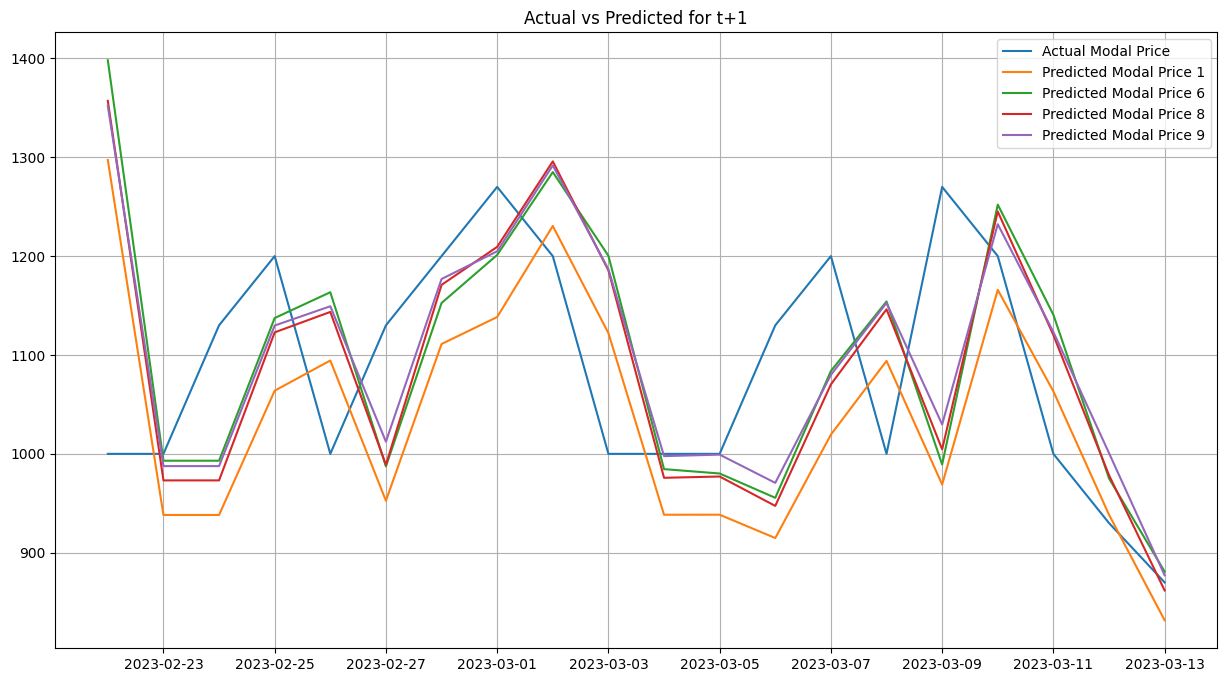

In [297]:
plt.plot(pred_df['modal_price_actual_t1'][-20:], label='Actual Modal Price')
plt.plot(pred_df['prediction_t1'][-20:],  label='Predicted Modal Price 1')
plt.plot(pred6_df['prediction_t1'][-20:],  label='Predicted Modal Price 6')
plt.plot(pred8_df['prediction_t1'][-20:],  label='Predicted Modal Price 8')
plt.plot(pred9_df['prediction_t1'][-20:],  label='Predicted Modal Price 9')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+1')
plt.show()

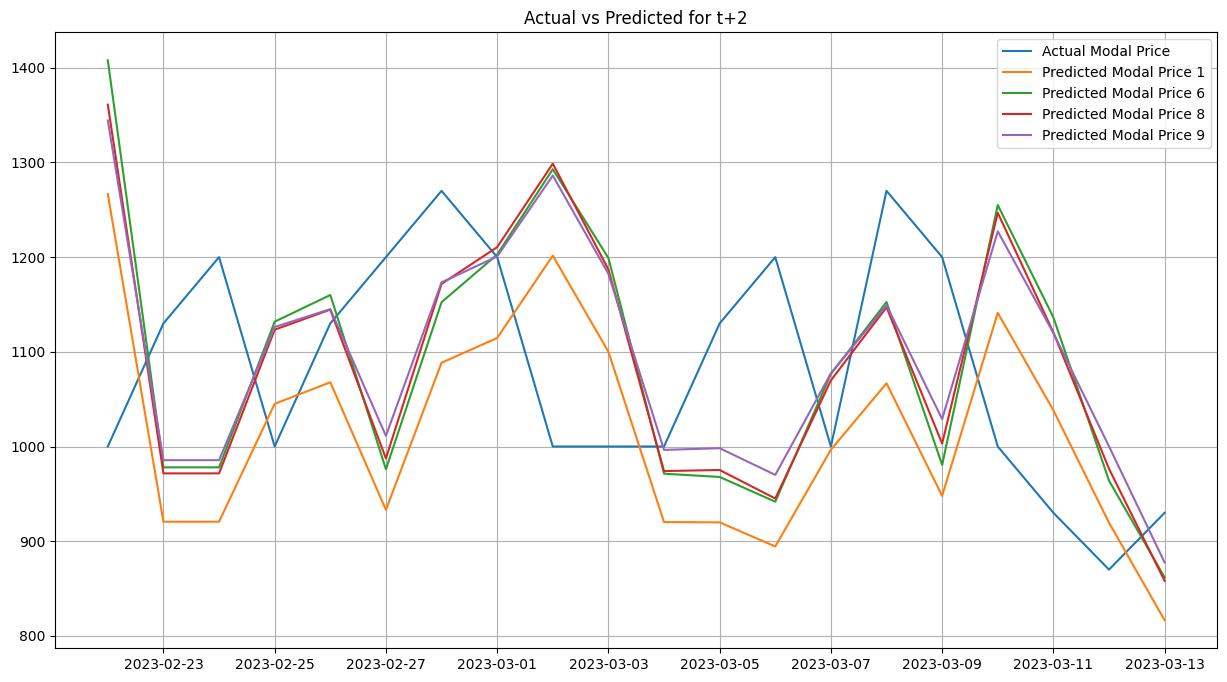

In [298]:
plt.plot(pred_df['modal_price_actual_t2'][-20:], label='Actual Modal Price')
plt.plot(pred_df['prediction_t2'][-20:],  label='Predicted Modal Price 1')
plt.plot(pred6_df['prediction_t2'][-20:],  label='Predicted Modal Price 6')
plt.plot(pred8_df['prediction_t2'][-20:],  label='Predicted Modal Price 8')
plt.plot(pred9_df['prediction_t2'][-20:],  label='Predicted Modal Price 9')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+2')
plt.show()

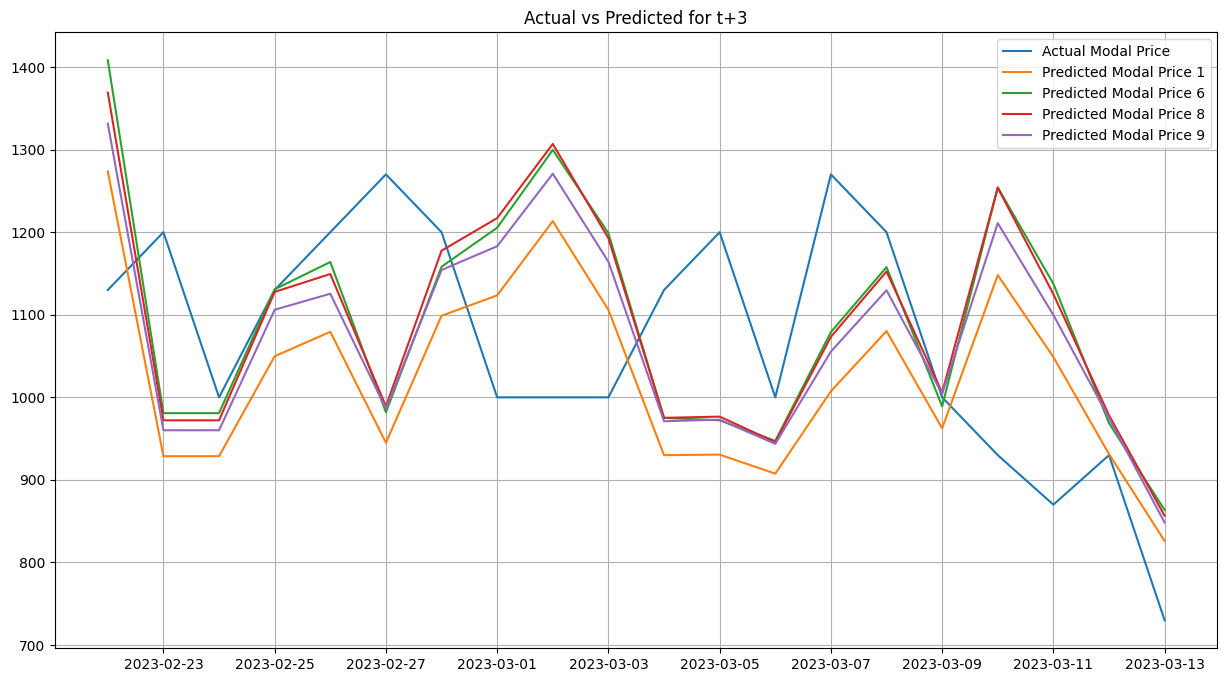

In [299]:
plt.plot(pred_df['modal_price_actual_t3'][-20:], label='Actual Modal Price')
plt.plot(pred_df['prediction_t3'][-20:],  label='Predicted Modal Price 1')
plt.plot(pred6_df['prediction_t3'][-20:],  label='Predicted Modal Price 6')
plt.plot(pred8_df['prediction_t3'][-20:],  label='Predicted Modal Price 8')
plt.plot(pred9_df['prediction_t3'][-20:],  label='Predicted Modal Price 9')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+3')
plt.show()

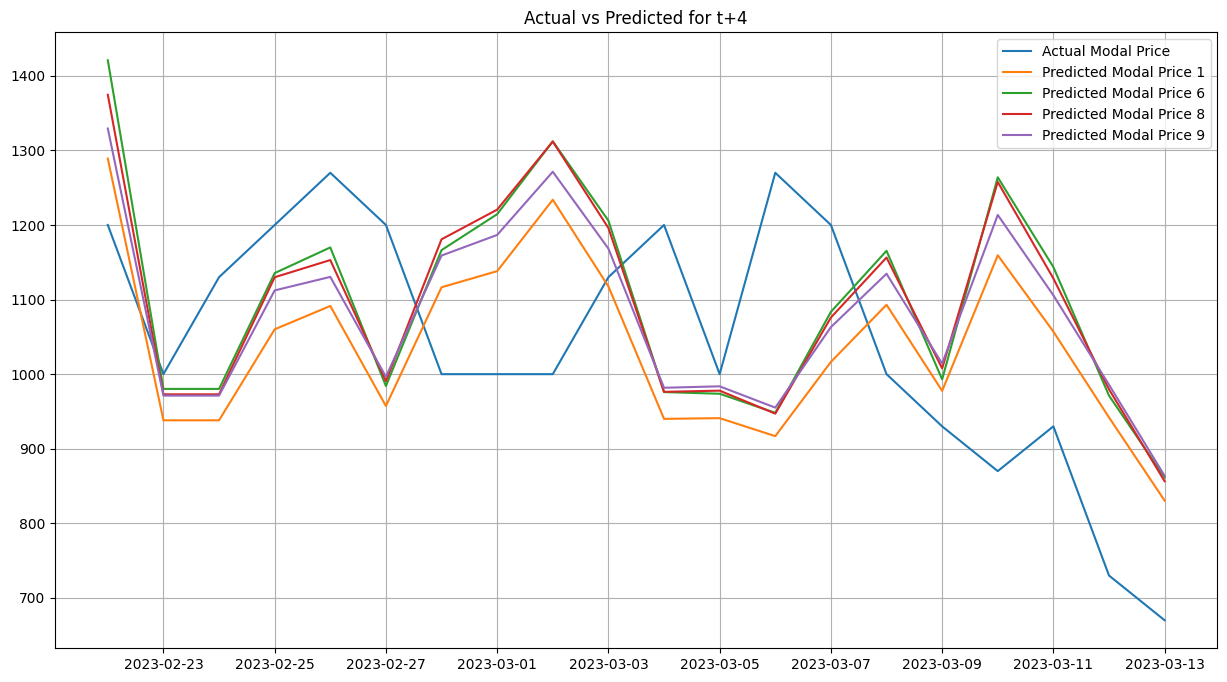

In [300]:
plt.plot(pred_df['modal_price_actual_t4'][-20:], label='Actual Modal Price')
plt.plot(pred_df['prediction_t4'][-20:],  label='Predicted Modal Price 1')
plt.plot(pred6_df['prediction_t4'][-20:],  label='Predicted Modal Price 6')
plt.plot(pred8_df['prediction_t4'][-20:],  label='Predicted Modal Price 8')
plt.plot(pred9_df['prediction_t4'][-20:],  label='Predicted Modal Price 9')
plt.legend()
plt.grid()
plt.title('Actual vs Predicted for t+4')
plt.show()

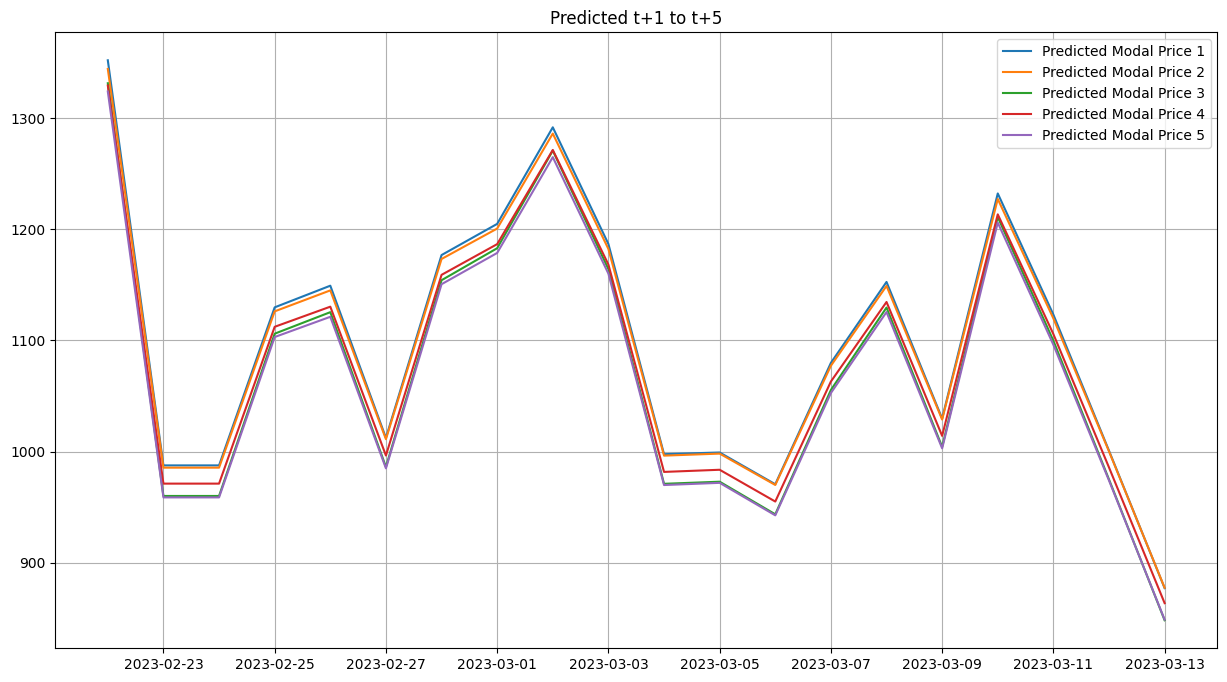

In [301]:
#plt.plot(pred_df['modal_price_actual_t5'][-20:], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t1'][-20:],  label='Predicted Modal Price 1')
plt.plot(pred9_df['prediction_t2'][-20:],  label='Predicted Modal Price 2')
plt.plot(pred9_df['prediction_t3'][-20:],  label='Predicted Modal Price 3')
plt.plot(pred9_df['prediction_t4'][-20:],  label='Predicted Modal Price 4')
plt.plot(pred9_df['prediction_t5'][-20:],  label='Predicted Modal Price 5')
plt.legend()
plt.grid()
plt.title('Predicted t+1 to t+5')
plt.show()

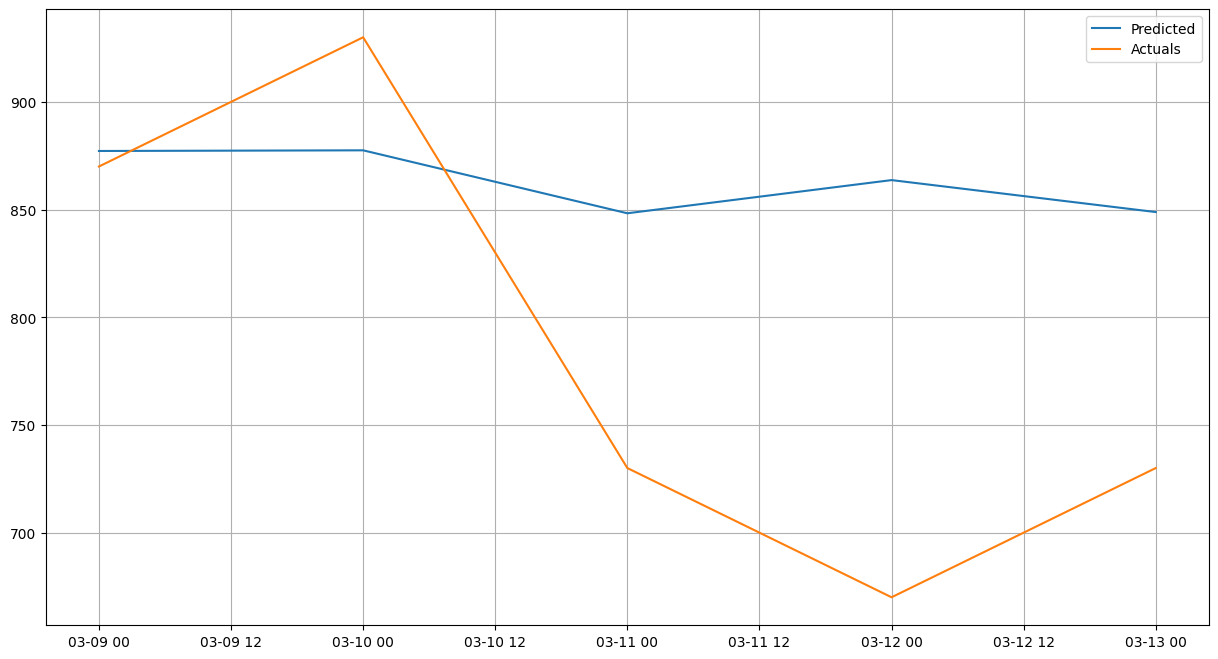

In [306]:
#y_pred = inv_pred_y[-1:].reshape(inv_pred_y.shape[1])
#y_pred_6 = inv_pred6_y[-2:-1].reshape(inv_pred6_y.shape[1])
y_pred_9 = inv_pred9_y[-1:].reshape(inv_pred9_y.shape[1])
y_actual = inv_test_y[-1:].reshape(inv_test_y.shape[1])
x = pred_df.index[-5:]
#plt.plot(x, y_pred, label='Predicted_1')
#plt.plot(x, y_pred_6, label='Predicted_6')
plt.plot(x, y_pred_9, label='Predicted')
plt.plot(x, y_actual, label='Actuals')
plt.legend()
plt.grid()
#plt.title('Prediction vs Actuals')
plt.show()

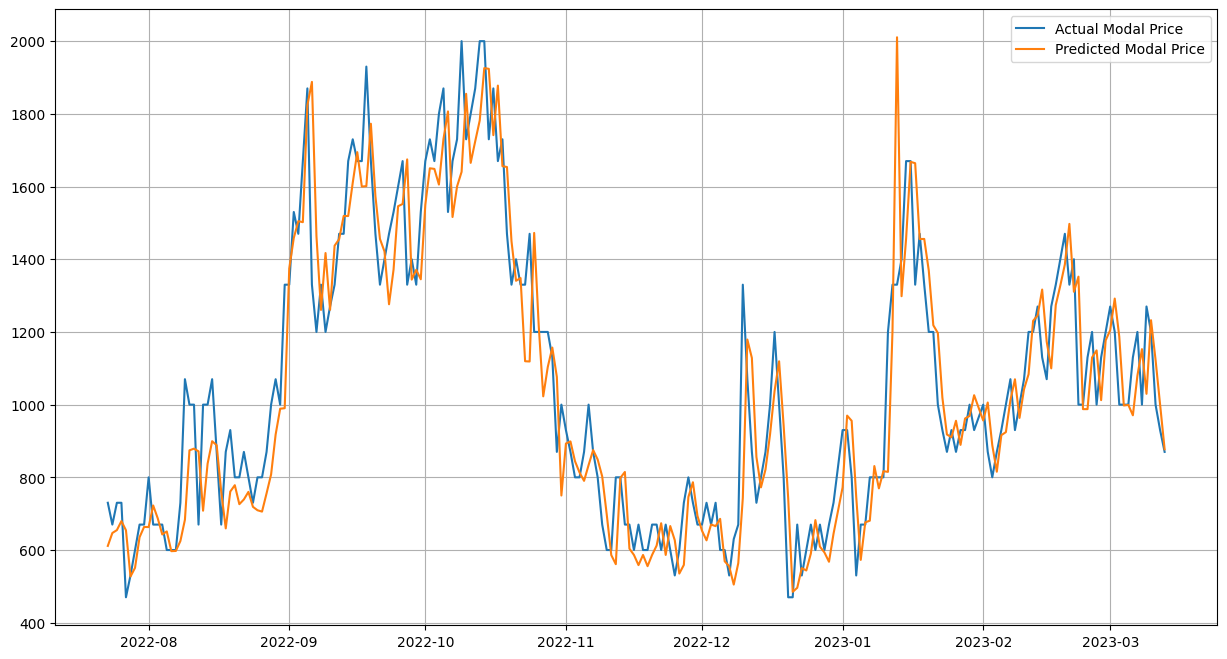

In [305]:
plt.plot(pred9_df['modal_price_actual_t1'], label='Actual Modal Price')
plt.plot(pred9_df['prediction_t1'],  label='Predicted Modal Price')
#plt.plot(pred9_df['prediction_t2'][-20:],  label='Predicted Modal Price 2')
#plt.plot(pred9_df['prediction_t3'][-20:],  label='Predicted Modal Price 3')
#plt.plot(pred9_df['prediction_t4'][-20:],  label='Predicted Modal Price 4')
#plt.plot(pred9_df['prediction_t5'][-20:],  label='Predicted Modal Price 5')
plt.legend()
plt.grid()
#plt.title('Predicted t+1 to t+5')
plt.show()